In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from utilities import dLambda
from solver_1d import false_transient_one_iteration_python
import global_parameters as gp
from supportfunctions import PDESolver_2d, finiteDiff
import matplotlib.pyplot as plt
from numba import njit,jit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode
import plotly.graph_objects as go
from scipy import interpolate
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

# Smooth Ambiguity
Base line model, no ambiguity:
$$
\begin{aligned}
0 = \max_{\tilde e}\min_h & - \delta \phi(y) + \delta\eta \log\tilde e \\
&  + \frac{\xi_m}{2} h'h + \frac{d\phi(y)}{dy} \tilde e (\theta + \sigma_y h) + \frac{1}{2}\frac{d^2\phi(y)}{dy^2}|\sigma_y|^2(\tilde e)^2\\
                           & + (\eta -1 )\cdot(\gamma_1 + \gamma_2 y)\cdot\tilde e\cdot (\theta + \sigma_y h)
\end{aligned}
$$

In [2]:
δ = 0.01
η = 0.032
μ = 1.86/1000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
σy = 1.2*np.mean(θ_list)
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.array([0, 2*0.0197, 2*0.3853])
ȳ= 2
ξₘ = 0.002
ξₐ = 1/10_000
years = np.linspace(0,100)

In [3]:
# y grid
n_y = 200
y_min = 1e-10
y_max = 4
y_grid = np.linspace(y_min, y_max, n_y)
dy = y_grid[1] - y_grid[0]

In [11]:
# no ambguity
def solve_no_ambiguity(y_grid, args, tol=1e-8, ϵ=0.3):
    δ, η, θ, σy, γ1, γ2, γ3, ȳ = args
    hy = y_grid[1] - y_grid[0]
    # initialize the while loop
    episode = 0
    lhs_error = 1
    dΛ = γ1 + γ2*y_grid + γ3*(y_grid - ȳ)*(y_grid>ȳ)
    ϕ =  - δ*η*y_grid**2
    ems = - δ*η/((η-1)*dΛ*θ)
    ems_old = ems
    h_star = 0
    while lhs_error > tol:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, hy)
        dϕdyy = derivative_1d(ϕ, 2, hy)
        temp = dϕdy + (η-1)*dΛ
        a = dϕdyy*σy**2  
        b = temp*θ
        c = δ*η
        Δ = b**2 - 4*a*c
        ems_new = (-b - np.sqrt(Δ))/(2*a)
        ems_new[ems_new <= 1e-15] = 1e-15    
        ems = ems_new*1 + ems_old*0
        # coefficients
        A = -δ*np.ones(y_grid.shape)
        B = ems*θ
        C = σy**2*ems**2/2
        D = δ*η*np.log(ems) + (η-1)*dΛ*ems*θ

        ϕ_new = solve_ode(A, B, C, D, y_grid, ϕ, ϵ, (False, 0))
        rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        ems_old = ems
        episode += 1
        print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    return ϕ, ems

In [12]:
@njit 
def simulate_no_amb(y_grid, ems, θ,  dt=1, T=100):
    # initiate
    periods = int(T/dt)
    ems_t = np.zeros(periods)
    y_t = np.zeros(periods)
    # interpolate
    y0 = θ*290
    y = y0
    for t in range(periods):
        ems_point = np.interp(y, y_grid, ems)
        ems_t[t] = ems_point
        dy = ems_point*θ*dt
        y = dy + y
        y_t[t] = y
    return y_t, ems_t

In [13]:
γ3 = np.average(γ3_list, weights=[0.5, 0.5, 0])
args = (δ, η, μ, σy, γ1, γ2, γ3, ȳ)
ϕ_avg_no_amb, ems_avg_no_amb = solve_no_ambiguity(y_grid, args)

episode: 1,	 ode error: 0.0015766763841096481,	 ft error: 0.0014676685630658616
episode: 2,	 ode error: 0.001493766434348463,	 ft error: 0.0013174960200154299
episode: 3,	 ode error: 0.0013652266098781109,	 ft error: 0.0012769471488738066
episode: 4,	 ode error: 0.001293352203485799,	 ft error: 0.0012222876280597289
episode: 5,	 ode error: 0.0012373829938298504,	 ft error: 0.0011817920441123347
episode: 6,	 ode error: 0.0011939232460112192,	 ft error: 0.0011479074330843055
episode: 7,	 ode error: 0.0011578202371921504,	 ft error: 0.00111863013754007
episode: 8,	 ode error: 0.001127408984766105,	 ft error: 0.001093217386936208
episode: 9,	 ode error: 0.0011009929580508998,	 ft error: 0.0010706306339171576
episode: 10,	 ode error: 0.001077579482566057,	 ft error: 0.0010499808102310327
episode: 11,	 ode error: 0.001056334523915209,	 ft error: 0.0010313506615008483
episode: 12,	 ode error: 0.0010371438891582522,	 ft error: 0.001014269539772545
episode: 13,	 ode error: 0.0010195658663514065

episode: 188,	 ode error: 0.00033384416140996333,	 ft error: 0.0003324859030415239
episode: 189,	 ode error: 0.0003321264869723978,	 ft error: 0.0003307811914029143
episode: 190,	 ode error: 0.0003304172400583088,	 ft error: 0.00032908474564991946
episode: 191,	 ode error: 0.00032871638765198804,	 ft error: 0.00032739653644084843
episode: 192,	 ode error: 0.0003270214645996705,	 ft error: 0.0003265273624827638
episode: 193,	 ode error: 0.0003253467722708716,	 ft error: 0.00032487243290725554
episode: 194,	 ode error: 0.0003236774703132978,	 ft error: 0.00032322020053784006
episode: 195,	 ode error: 0.0003220142713598113,	 ft error: 0.00032157231548641624
episode: 196,	 ode error: 0.00032035768545262853,	 ft error: 0.00031992988240111636
episode: 197,	 ode error: 0.0003187080782035951,	 ft error: 0.0003182936446478879
episode: 198,	 ode error: 0.00031706571153349613,	 ft error: 0.00031666410791680405
episode: 199,	 ode error: 0.0003154307725452241,	 ft error: 0.0003150416201353849
episo

episode: 397,	 ode error: 0.00011443891452843575,	 ft error: 0.0001142865612039958
episode: 398,	 ode error: 0.00011387000657963687,	 ft error: 0.00011372009991813167
episode: 399,	 ode error: 0.0001133041006147193,	 ft error: 0.00011315661205729226
episode: 400,	 ode error: 0.00011274117958153895,	 ft error: 0.0001125960810699489
episode: 401,	 ode error: 0.00011218122653202571,	 ft error: 0.00011203849049655953
episode: 402,	 ode error: 0.0001116242246219667,	 ft error: 0.00011148382396417948
episode: 403,	 ode error: 0.00011107015711068027,	 ft error: 0.00011093206519645349
episode: 404,	 ode error: 0.000110519007360787,	 ft error: 0.0001103831980062836
episode: 405,	 ode error: 0.00010997075883786096,	 ft error: 0.00010983720629922922
episode: 406,	 ode error: 0.00010942539511013289,	 ft error: 0.00010929407407353024
episode: 407,	 ode error: 0.00010888289984812215,	 ft error: 0.00010875378541684577
episode: 408,	 ode error: 0.00010834325682425327,	 ft error: 0.0001082163245113658


episode: 612,	 ode error: 4.041821592733858e-05,	 ft error: 4.048794515980336e-05
episode: 613,	 ode error: 4.0227582122541244e-05,	 ft error: 4.0297633067630054e-05
episode: 614,	 ode error: 4.003787180728276e-05,	 ft error: 4.010824067030942e-05
episode: 615,	 ode error: 3.9849080155474276e-05,	 ft error: 3.991976316027509e-05
episode: 616,	 ode error: 3.966120237127195e-05,	 ft error: 3.9732195760306774e-05
episode: 617,	 ode error: 3.947423368884113e-05,	 ft error: 3.9545533721679904e-05
episode: 618,	 ode error: 3.928816937218821e-05,	 ft error: 3.9359772327357545e-05
episode: 619,	 ode error: 3.9103004714911805e-05,	 ft error: 3.917490688812771e-05
episode: 620,	 ode error: 3.891873503999543e-05,	 ft error: 3.8990932745147644e-05
episode: 621,	 ode error: 3.873535569960684e-05,	 ft error: 3.8807845267584594e-05
episode: 622,	 ode error: 3.855286207484995e-05,	 ft error: 3.862563985437366e-05
episode: 623,	 ode error: 3.8371249575588754e-05,	 ft error: 3.84443119318123e-05
episode

episode: 825,	 ode error: 1.4882687341120785e-05,	 ft error: 1.4953992648220987e-05
episode: 826,	 ode error: 1.4813316909889954e-05,	 ft error: 1.4884352413646607e-05
episode: 827,	 ode error: 1.474427007855687e-05,	 ft error: 1.4815033171263389e-05
episode: 828,	 ode error: 1.4675545306592434e-05,	 ft error: 1.47460333828342e-05
episode: 829,	 ode error: 1.4607141061209294e-05,	 ft error: 1.4677351505380336e-05
episode: 830,	 ode error: 1.4539055817295709e-05,	 ft error: 1.4608986014195507e-05
episode: 831,	 ode error: 1.4471288057404269e-05,	 ft error: 1.4540935383393813e-05
episode: 832,	 ode error: 1.4403836271693676e-05,	 ft error: 1.4473198098446013e-05
episode: 833,	 ode error: 1.4336698957882559e-05,	 ft error: 1.4405772657174095e-05
episode: 834,	 ode error: 1.426987462123093e-05,	 ft error: 1.4338657555410899e-05
episode: 835,	 ode error: 1.4203361774496929e-05,	 ft error: 1.4271851304601773e-05
episode: 836,	 ode error: 1.4137158937884884e-05,	 ft error: 1.4205352415891381e

episode: 1030,	 ode error: 6.194114190391465e-06,	 ft error: 5.65318817385511e-06
episode: 1031,	 ode error: 6.179960145679254e-06,	 ft error: 5.625511417389761e-06
episode: 1032,	 ode error: 6.165882032488205e-06,	 ft error: 5.5979539157850295e-06
episode: 1033,	 ode error: 6.151879564847418e-06,	 ft error: 5.570515056984212e-06
episode: 1034,	 ode error: 6.137952459027581e-06,	 ft error: 5.543194249816678e-06
episode: 1035,	 ode error: 6.124100432843504e-06,	 ft error: 5.515990889974158e-06
episode: 1036,	 ode error: 6.110323206233838e-06,	 ft error: 5.488904386771742e-06
episode: 1037,	 ode error: 6.096620500844314e-06,	 ft error: 5.461934138399164e-06
episode: 1038,	 ode error: 6.082992040466512e-06,	 ft error: 5.435079565505041e-06
episode: 1039,	 ode error: 6.069437550290527e-06,	 ft error: 5.408340076386761e-06
episode: 1040,	 ode error: 6.055956757520251e-06,	 ft error: 5.3817150764273736e-06
episode: 1041,	 ode error: 6.042549391486237e-06,	 ft error: 5.355203986506796e-06
epi

episode: 1235,	 ode error: 4.739944292976193e-06,	 ft error: 2.6724115566312268e-06
episode: 1236,	 ode error: 4.746964130401842e-06,	 ft error: 2.28401780417072e-06
episode: 1237,	 ode error: 4.713460551031062e-06,	 ft error: 2.4230599359835e-06
episode: 1238,	 ode error: 4.7136559657210255e-06,	 ft error: 2.449389786343681e-06
episode: 1239,	 ode error: 4.715507678064814e-06,	 ft error: 2.479578611868742e-06
episode: 1240,	 ode error: 4.719138697079463e-06,	 ft error: 2.5160563025862967e-06
episode: 1241,	 ode error: 4.724804268005172e-06,	 ft error: 2.5626879000701748e-06
episode: 1242,	 ode error: 4.73296559167077e-06,	 ft error: 2.626001184268904e-06
episode: 1243,	 ode error: 4.739342930447084e-06,	 ft error: 2.2230412999544686e-06
episode: 1244,	 ode error: 4.705080309190318e-06,	 ft error: 2.388957780855942e-06
episode: 1245,	 ode error: 4.7054766471035445e-06,	 ft error: 2.4261168350576496e-06
episode: 1246,	 ode error: 4.708135834174715e-06,	 ft error: 2.4705166826293388e-06


episode: 1436,	 ode error: 4.044073016338666e-06,	 ft error: 1.0750304166769662e-06
episode: 1437,	 ode error: 4.024946244352771e-06,	 ft error: 1.633698106159413e-06
episode: 1438,	 ode error: 4.04464935475652e-06,	 ft error: 1.0686342425079525e-06
episode: 1439,	 ode error: 4.025274480463806e-06,	 ft error: 1.6289361074473911e-06
episode: 1440,	 ode error: 4.0448797568737186e-06,	 ft error: 1.0623370078760574e-06
episode: 1441,	 ode error: 4.025269982606749e-06,	 ft error: 1.6205388725723524e-06
episode: 1442,	 ode error: 4.044628087083134e-06,	 ft error: 1.0561264050801267e-06
episode: 1443,	 ode error: 4.0248063824208395e-06,	 ft error: 1.6087668088665685e-06
episode: 1444,	 ode error: 4.0437872774674085e-06,	 ft error: 1.0499907573494986e-06
episode: 1445,	 ode error: 4.0237844927903076e-06,	 ft error: 1.5939328201648266e-06
episode: 1446,	 ode error: 4.042278220346392e-06,	 ft error: 1.0439193056747491e-06
episode: 1447,	 ode error: 4.022131393062781e-06,	 ft error: 1.57641318046

episode: 1636,	 ode error: 3.850224688499589e-06,	 ft error: 1.0623376833311198e-06
episode: 1637,	 ode error: 3.871459476559574e-06,	 ft error: 7.605451716787467e-07
episode: 1638,	 ode error: 3.849412776009116e-06,	 ft error: 7.584950451518709e-07
episode: 1639,	 ode error: 3.832879294843154e-06,	 ft error: 9.744408313467716e-07
episode: 1640,	 ode error: 3.851114662046379e-06,	 ft error: 7.548435676981343e-07
episode: 1641,	 ode error: 3.834731149081577e-06,	 ft error: 1.0515166560277438e-06
episode: 1642,	 ode error: 3.856567808031386e-06,	 ft error: 7.513494910728798e-07
episode: 1643,	 ode error: 3.835232174596707e-06,	 ft error: 7.49240437770508e-07
episode: 1644,	 ode error: 3.819406417721158e-06,	 ft error: 9.76003832626101e-07
episode: 1645,	 ode error: 3.838695412808975e-06,	 ft error: 7.456685475563478e-07
episode: 1646,	 ode error: 3.822942950712635e-06,	 ft error: 1.063464508584596e-06
episode: 1647,	 ode error: 3.846192809293003e-06,	 ft error: 7.425780914708617e-07
epis

episode: 1832,	 ode error: 3.7516044881905942e-06,	 ft error: 9.679502424702244e-07
episode: 1833,	 ode error: 3.773760393178862e-06,	 ft error: 6.413661466040759e-07
episode: 1834,	 ode error: 3.7559587785205868e-06,	 ft error: 9.990899603346908e-07
episode: 1835,	 ode error: 3.7787245509142376e-06,	 ft error: 6.449646911335649e-07
episode: 1836,	 ode error: 3.755909330483342e-06,	 ft error: 6.401479689157238e-07
episode: 1837,	 ode error: 3.7386069702336064e-06,	 ft error: 7.137750849285178e-07
episode: 1838,	 ode error: 3.7551112025997887e-06,	 ft error: 6.372987941538621e-07
episode: 1839,	 ode error: 3.7380534504099887e-06,	 ft error: 7.838246686431294e-07
episode: 1840,	 ode error: 3.756388587547281e-06,	 ft error: 6.357991917902799e-07
episode: 1841,	 ode error: 3.7394087131489362e-06,	 ft error: 8.481846068437531e-07
episode: 1842,	 ode error: 3.7592591544330367e-06,	 ft error: 6.356237807041606e-07
episode: 1843,	 ode error: 3.742239905244046e-06,	 ft error: 9.080125826232965e

episode: 2029,	 ode error: 3.521611223065253e-06,	 ft error: 4.109017384447874e-07
episode: 2030,	 ode error: 3.510668186077078e-06,	 ft error: 4.098362952250264e-07
episode: 2031,	 ode error: 3.5004756394578637e-06,	 ft error: 4.087167077236146e-07
episode: 2032,	 ode error: 3.4953196918762223e-06,	 ft error: 1.1407995827277437e-06
episode: 2033,	 ode error: 3.5266113809198554e-06,	 ft error: 4.074411868078739e-07
episode: 2034,	 ode error: 3.5151891720145833e-06,	 ft error: 4.063982140857977e-07
episode: 2035,	 ode error: 3.504558109634448e-06,	 ft error: 4.0528858033517245e-07
episode: 2036,	 ode error: 3.4991658814173413e-06,	 ft error: 1.1989889729668857e-06
episode: 2037,	 ode error: 3.5315833923433085e-06,	 ft error: 4.040988293753841e-07
episode: 2038,	 ode error: 3.519709366346592e-06,	 ft error: 4.031249030654142e-07
episode: 2039,	 ode error: 3.5086646882704015e-06,	 ft error: 4.0207998009781737e-07
episode: 2040,	 ode error: 3.5029319734572375e-06,	 ft error: 1.209991849389

episode: 2222,	 ode error: 3.456458796671758e-06,	 ft error: 3.555554327812812e-07
episode: 2223,	 ode error: 3.4482438738258356e-06,	 ft error: 3.5452007251154016e-07
episode: 2224,	 ode error: 3.440574069231341e-06,	 ft error: 3.534382763311269e-07
episode: 2225,	 ode error: 3.4334046854154468e-06,	 ft error: 3.523197827232094e-07
episode: 2226,	 ode error: 3.4266948151657475e-06,	 ft error: 3.511716615880086e-07
episode: 2227,	 ode error: 3.4204070446507704e-06,	 ft error: 3.499990761564783e-07
episode: 2228,	 ode error: 3.4191484545557796e-06,	 ft error: 1.3213056811063144e-06
episode: 2229,	 ode error: 3.456274990446093e-06,	 ft error: 3.485324419118715e-07
episode: 2230,	 ode error: 3.4477445107474955e-06,	 ft error: 3.476685615326029e-07
episode: 2231,	 ode error: 3.439790489406509e-06,	 ft error: 3.4674456037923446e-07
episode: 2232,	 ode error: 3.432365712889053e-06,	 ft error: 3.457649470905988e-07
episode: 2233,	 ode error: 3.425426843636217e-06,	 ft error: 3.447421718696016

episode: 2417,	 ode error: 3.406074286675621e-06,	 ft error: 2.9168610708498377e-07
episode: 2418,	 ode error: 3.4019290222851977e-06,	 ft error: 1.269693223985661e-06
episode: 2419,	 ode error: 3.434870336724207e-06,	 ft error: 3.0410067503502025e-07
episode: 2420,	 ode error: 3.4242529834635233e-06,	 ft error: 2.9683070211274554e-07
episode: 2421,	 ode error: 3.4144060055818883e-06,	 ft error: 2.942411100765689e-07
episode: 2422,	 ode error: 3.4052653127667094e-06,	 ft error: 2.908681725801351e-07
episode: 2423,	 ode error: 3.4012527291124757e-06,	 ft error: 1.2849702202624713e-06
episode: 2424,	 ode error: 3.4346341643451362e-06,	 ft error: 3.0400604655173025e-07
episode: 2425,	 ode error: 3.424067103899829e-06,	 ft error: 2.9629443074978096e-07
episode: 2426,	 ode error: 3.4142660674317364e-06,	 ft error: 2.9375969014949765e-07
episode: 2427,	 ode error: 3.405167356173677e-06,	 ft error: 2.9043891004026934e-07
episode: 2428,	 ode error: 3.401253659682875e-06,	 ft error: 1.307181580

episode: 2611,	 ode error: 3.212195301850805e-06,	 ft error: 1.579574958332497e-07
episode: 2612,	 ode error: 3.2117927487316025e-06,	 ft error: 1.5744046020597463e-07
episode: 2613,	 ode error: 3.2113925775822385e-06,	 ft error: 1.5691468427854924e-07
episode: 2614,	 ode error: 3.2109947663210925e-06,	 ft error: 1.5638025529599958e-07
episode: 2615,	 ode error: 3.210599293334811e-06,	 ft error: 1.558372659156889e-07
episode: 2616,	 ode error: 3.210206137510725e-06,	 ft error: 1.5528581587265222e-07
episode: 2617,	 ode error: 3.2098152781816647e-06,	 ft error: 1.5472601022174331e-07
episode: 2618,	 ode error: 3.2094266951365833e-06,	 ft error: 1.541894679990552e-07
episode: 2619,	 ode error: 3.2090403685852134e-06,	 ft error: 1.5370071354547932e-07
episode: 2620,	 ode error: 3.2086562791273834e-06,	 ft error: 1.532036586482377e-07
episode: 2621,	 ode error: 3.208274407791507e-06,	 ft error: 1.5269837773853231e-07
episode: 2622,	 ode error: 3.2078947359567367e-06,	 ft error: 1.521849498

episode: 2804,	 ode error: 3.2017523709685714e-06,	 ft error: 1.2390069512036028e-07
episode: 2805,	 ode error: 3.2013414301839153e-06,	 ft error: 1.2343706311720068e-07
episode: 2806,	 ode error: 3.2009356644556062e-06,	 ft error: 1.2295478625986198e-07
episode: 2807,	 ode error: 3.2005348961091458e-06,	 ft error: 1.2245436787257832e-07
episode: 2808,	 ode error: 3.200138956736061e-06,	 ft error: 1.219363287655965e-07
episode: 2809,	 ode error: 3.1997476866750052e-06,	 ft error: 1.214012081603618e-07
episode: 2810,	 ode error: 3.199360934426289e-06,	 ft error: 1.2084955994251523e-07
episode: 2811,	 ode error: 3.198978556188492e-06,	 ft error: 1.202819510196888e-07
episode: 2812,	 ode error: 3.1986004153919303e-06,	 ft error: 1.1969896109020883e-07
episode: 2813,	 ode error: 3.198226382261941e-06,	 ft error: 1.1910118012196473e-07
episode: 2814,	 ode error: 3.1978563334020054e-06,	 ft error: 1.1865853637623344e-07
episode: 2815,	 ode error: 3.1974901514552614e-06,	 ft error: 1.18230035

episode: 2997,	 ode error: 3.158929704342008e-06,	 ft error: 6.6599167430903e-08
episode: 2998,	 ode error: 3.1588049478849982e-06,	 ft error: 6.64023986722088e-08
episode: 2999,	 ode error: 3.15868082164186e-06,	 ft error: 6.62061396446608e-08
episode: 3000,	 ode error: 3.158557322156157e-06,	 ft error: 6.60103901169625e-08
episode: 3001,	 ode error: 3.1584344459865228e-06,	 ft error: 6.581515038979932e-08
episode: 3002,	 ode error: 3.158312189701783e-06,	 ft error: 6.562042046317126e-08
episode: 3003,	 ode error: 3.1581905498773762e-06,	 ft error: 6.542620098470842e-08
episode: 3004,	 ode error: 3.158069523084622e-06,	 ft error: 6.523249181563293e-08
episode: 3005,	 ode error: 3.157949105922378e-06,	 ft error: 6.503929330288946e-08
episode: 3006,	 ode error: 3.157829294980611e-06,	 ft error: 6.484660607097847e-08
episode: 3007,	 ode error: 3.1577100868547103e-06,	 ft error: 6.465443007364069e-08
episode: 3008,	 ode error: 3.1575914781550255e-06,	 ft error: 6.446276556530221e-08
episo

episode: 3189,	 ode error: 3.1431789802446267e-06,	 ft error: 3.774452190611714e-08
episode: 3190,	 ode error: 3.1431267147332635e-06,	 ft error: 3.763420764838858e-08
episode: 3191,	 ode error: 3.1430746614914467e-06,	 ft error: 3.7524217298227455e-08
episode: 3192,	 ode error: 3.143022819531902e-06,	 ft error: 3.741454990731826e-08
episode: 3193,	 ode error: 3.142971187861934e-06,	 ft error: 3.730520450421586e-08
episode: 3194,	 ode error: 3.1429197654973037e-06,	 ft error: 3.7196179955567565e-08
episode: 3195,	 ode error: 3.1428685514595187e-06,	 ft error: 3.708747485046497e-08
episode: 3196,	 ode error: 3.1428175447795192e-06,	 ft error: 3.6979088587537255e-08
episode: 3197,	 ode error: 3.142766744485535e-06,	 ft error: 3.687101991778352e-08
episode: 3198,	 ode error: 3.1427161496095897e-06,	 ft error: 3.676326756907322e-08
episode: 3199,	 ode error: 3.142665759206368e-06,	 ft error: 3.6655830685609444e-08
episode: 3200,	 ode error: 3.142615572318411e-06,	 ft error: 3.6548707810224

episode: 3386,	 ode error: 3.135991582860231e-06,	 ft error: 2.1189281694996197e-08
episode: 3387,	 ode error: 3.1359669999186457e-06,	 ft error: 2.1127195109123718e-08
episode: 3388,	 ode error: 3.135942505146658e-06,	 ft error: 2.1065289790289654e-08
episode: 3389,	 ode error: 3.1359180981813855e-06,	 ft error: 2.1003565553456838e-08
episode: 3390,	 ode error: 3.1358937786512718e-06,	 ft error: 2.0942021774124818e-08
episode: 3391,	 ode error: 3.135869546190724e-06,	 ft error: 2.088065812847854e-08
episode: 3392,	 ode error: 3.1358454004305715e-06,	 ft error: 2.0819473621943217e-08
episode: 3393,	 ode error: 3.1358213410241946e-06,	 ft error: 2.075846809261132e-08
episode: 3394,	 ode error: 3.1357973676052414e-06,	 ft error: 2.0697640962241692e-08
episode: 3395,	 ode error: 3.135773479815817e-06,	 ft error: 2.063699169885247e-08
episode: 3396,	 ode error: 3.1357496773050733e-06,	 ft error: 2.0576519654813552e-08
episode: 3397,	 ode error: 3.135725959712405e-06,	 ft error: 2.051622471

episode: 3588,	 ode error: 3.132416204755647e-06,	 ft error: 1.1710566151050077e-08
episode: 3589,	 ode error: 3.1324038503611215e-06,	 ft error: 1.167622815564003e-08
episode: 3590,	 ode error: 3.132391535994581e-06,	 ft error: 1.1641990912969469e-08
episode: 3591,	 ode error: 3.1323792615098756e-06,	 ft error: 1.1607853775408294e-08
episode: 3592,	 ode error: 3.132367026766384e-06,	 ft error: 1.1573816835475093e-08
episode: 3593,	 ode error: 3.132354831613402e-06,	 ft error: 1.1539879561187998e-08
episode: 3594,	 ode error: 3.13234267590814e-06,	 ft error: 1.1506041744380191e-08
episode: 3595,	 ode error: 3.1323305595094353e-06,	 ft error: 1.147230322314415e-08
episode: 3596,	 ode error: 3.1323184822623553e-06,	 ft error: 1.1438663511757301e-08
episode: 3597,	 ode error: 3.132306444027797e-06,	 ft error: 1.1405122193886008e-08
episode: 3598,	 ode error: 3.1322944446777155e-06,	 ft error: 1.137167910762275e-08
episode: 3599,	 ode error: 3.1322824840705147e-06,	 ft error: 1.13383340216

In [14]:
yt_avg_no, et_avg_no = simulate_no_amb(y_grid, ems_avg_no_amb, θ_list.mean())

# Case 1: drop h
$$
\begin{aligned}
0 = \max_{\tilde e} \min_h \min_{\pi^c} &- \delta \phi(y) + \delta\eta \log\tilde e \\
& + \sum \pi^c_i \left[\frac{d\phi}{dy} + (\eta -1)(\gamma_1 + \gamma_2 y) \right]\tilde e \theta_i \\
& + \frac{1}{2}(\eta - 1)\cdot (\gamma_2 + \gamma_3 \mathcal{I}\{y > \bar y\}) (\tilde e )^2 |\sigma_y|^2\\
& + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2 + \xi_a \sum \pi^c_i (\log \pi^c_i - \log \hat\pi^c_i)
\end{aligned}
$$

Optimald distribution:
$$
\pi^c_j \propto \hat\pi^c_j \exp\left( -\frac{1}{\xi_a}\left[\frac{d\phi}{dy} + (\eta -1)(\gamma_1 + \gamma_2 y) \right]\tilde e \theta_j \right)
$$

First order condition for $\tilde e^*$:

$$
  \left[ \frac{d^2\phi(y)}{dy^2} + (\eta - 1)\cdot (\gamma_2 + \gamma_3 \mathcal{I}\{y > \bar y\})\right] \cdot|\sigma_y|^2\cdot(\tilde e)^2 + \sum_j \pi^c_j \left[\frac{d\phi(y)}{dy} + (\eta - 1)(\gamma_1 + \gamma_2 y)\right]\theta_j \tilde e + \delta\eta = 0
$$

$$
A =  \left[ \frac{d^2\phi(y)}{dy^2} + (\eta - 1)\cdot (\gamma_2 + \gamma_3 \mathcal{I}\{y > \bar y\})\right] \cdot|\sigma_y|^2
$$

$$
B = \sum_j \pi_j^c \left[\frac{d\phi(y)}{dy} + (\eta - 1)(\gamma_1 + \gamma_2 y)\right]\theta_j
$$

$$
C = \delta\eta
$$
And
$$
\tilde e^* = \frac{-B -  \sqrt{B^2 - 4AC}}{2A}
$$

In [22]:
# def func
def solve_smooth(y_grid, args, tol=1e-8, ϵ=0.3, max_iter=10_000):
    δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξₐ = args
    dy = y_grid[1] - y_grid[0]
    dΛ = γ1 + γ2*y_grid + γ3*(y_grid-ȳ)*(y_grid>ȳ)
    ddΛ = γ2 + γ3*(y_grid>ȳ)
    ϕ = - δ*η*y_grid**2
    ems = δ*η
    ems_old = ems
    πo = np.ones((len(θ_list), n_y))/len(θ_list)
    lhs_error = 1
    episode = 0
    while lhs_error > tol and episode < max_iter:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, dy)
        dϕdyy = derivative_1d(ϕ, 2, dy)
        temp = dϕdy + (η-1)*dΛ
        # update belief
        weight = np.array([ - 1/ξₐ*temp*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        π = πo*np.exp(weight)
        π[π <= 1e-15] = 1e-15
        π = π/np.sum(π, axis=0)
        # update control
        a = (dϕdyy + (η-1)*ddΛ)*σy**2
        b = (θ_list@π)*temp
        c = δ*η
        Δ = b**2 - 4*a*c
        Δ[Δ < 0] = 0
        root1 = (-b - np.sqrt(Δ))/(2*a)
        root2 = (-b + np.sqrt(Δ))/(2*a)
        if root1.all() > 0:
            ems_new = root1
        else:
            ems_new = root2
        ems_new[ems_new < 1e-15] = 1e-15
        ems = ems_new*0.5 + ems_old*0.5
        # solve for ode
        A = - δ*np.ones(y_grid.shape)
        B = (θ_list@π)*ems
#         C = np.zeros(y_grid.shape)
        C = ems**2*σy**2/2
        D = δ*η*np.log(ems) + (θ_list@π)*(η-1)*dΛ*ems \
        + ξₐ*np.sum(π*(np.log(π) - np.log(πo)), axis=0)\
        + 1/2*(η-1)*ddΛ*ems**2*σy**2
        ϕ_new = solve_ode(A, B, C, D, y_grid, ϕ, ϵ, (False, 0))
        rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        ems_old = ems
        episode += 1
        print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    return ϕ, ems, π

In [76]:
def simulate_traj(y_grid, ems, π_mat, θ_list,  dt=1, T=100):
    # initiate
    periods = int(T/dt)
    ems_t = np.zeros(periods)
    y_t = np.zeros(periods)
    π_t = np.zeros((periods, len(θ_list)))
    # interpolate
    get_π = interpolate.interp1d(y_grid, π_mat)
    y0 = np.median(θ_list)*290
    y = y0
    for t in range(periods):
        ems_point = np.interp(y, y_grid, ems)
        π_list = get_π(y)
        ems_t[t] = ems_point
        π_t[t] = π_list
        dy = ems_point*np.median(θ_list)*dt
        y = dy + y
        y_t[t] = y
    return y_t, ems_t, π_t

# average over high and low damage

In [23]:
ξₐ = 1/4000
γ3 = np.average(γ3_list, weights=[0.5,0.5,0])
args = (δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξₐ)
ϕ_avg, ems_avg, π_avg = solve_smooth(y_grid, args)

episode: 1,	 ode error: 0.0012172938111854213,	 ft error: 0.0011973882935587354
episode: 2,	 ode error: 0.001256086655402313,	 ft error: 0.0012281423396807815
episode: 3,	 ode error: 0.0012301847422398569,	 ft error: 0.0011986336165937725
episode: 4,	 ode error: 0.0011960551228243094,	 ft error: 0.0011646577962023171
episode: 5,	 ode error: 0.001164185861150829,	 ft error: 0.001134830145107812
episode: 6,	 ode error: 0.0011358891171243035,	 ft error: 0.0011088490045317555
episode: 7,	 ode error: 0.001110691249720994,	 ft error: 0.001085835180226117
episode: 8,	 ode error: 0.0010879774941029365,	 ft error: 0.0010646128621261985
episode: 9,	 ode error: 0.0010671728822688287,	 ft error: 0.0010456970788511205
episode: 10,	 ode error: 0.0010480821296736881,	 ft error: 0.00102819915109937
episode: 11,	 ode error: 0.001030409949711975,	 ft error: 0.0010118885487389582
episode: 12,	 ode error: 0.0010139413830663338,	 ft error: 0.000996599352332039
episode: 13,	 ode error: 0.0009985125271959648

episode: 170,	 ode error: 0.00036088148994517055,	 ft error: 0.0003594598986327256
episode: 171,	 ode error: 0.00035902382185810564,	 ft error: 0.00035761483424603485
episode: 172,	 ode error: 0.00035717516199467055,	 ft error: 0.0003557786592877736
episode: 173,	 ode error: 0.0003553354642548426,	 ft error: 0.0003539513292243057
episode: 174,	 ode error: 0.00035350468380145755,	 ft error: 0.0003521328007300567
episode: 175,	 ode error: 0.00035168277699447947,	 ft error: 0.0003503230316257572
episode: 176,	 ode error: 0.000349869701327635,	 ft error: 0.0003485219808182366
episode: 177,	 ode error: 0.00034806541536735243,	 ft error: 0.0003467296082426454
episode: 178,	 ode error: 0.000346269878693955,	 ft error: 0.0003449458748067356
episode: 179,	 ode error: 0.00034448305184512317,	 ft error: 0.0003431707423369226
episode: 180,	 ode error: 0.0003427048962615167,	 ft error: 0.00034140417352661323
episode: 181,	 ode error: 0.00034093537423456066,	 ft error: 0.00033964613188652387
episode

episode: 344,	 ode error: 0.0001462066823980973,	 ft error: 0.00014602769862659867
episode: 345,	 ode error: 0.0001454604319580656,	 ft error: 0.0001452840179418565
episode: 346,	 ode error: 0.00014471821701292082,	 ft error: 0.00014454434473037958
episode: 347,	 ode error: 0.00014398001501896452,	 ft error: 0.00014380865686329514
episode: 348,	 ode error: 0.00014324580354154934,	 ft error: 0.0001430769323110953
episode: 349,	 ode error: 0.00014251556025519105,	 ft error: 0.00014234914914553384
episode: 350,	 ode error: 0.00014178926294362544,	 ft error: 0.00014162528553860837
episode: 351,	 ode error: 0.00014106688949988555,	 ft error: 0.0001409053197635781
episode: 352,	 ode error: 0.0001403484179263668,	 ft error: 0.00014018923019503324
episode: 353,	 ode error: 0.00013963382633480582,	 ft error: 0.00013947699530884872
episode: 354,	 ode error: 0.00013892309294635146,	 ft error: 0.00013876859368341007
episode: 355,	 ode error: 0.00013821619609149746,	 ft error: 0.0001380640039985957

episode: 518,	 ode error: 6.138791561845127e-05,	 ft error: 6.141966688936093e-05
episode: 519,	 ode error: 6.108936415410559e-05,	 ft error: 6.112149273959182e-05
episode: 520,	 ode error: 6.079232342185467e-05,	 ft error: 6.082482254150812e-05
episode: 521,	 ode error: 6.049678516681356e-05,	 ft error: 6.052964805454882e-05
episode: 522,	 ode error: 6.020274118544351e-05,	 ft error: 6.023596108894562e-05
episode: 523,	 ode error: 5.9910183325245e-05,	 ft error: 5.994375350544534e-05
episode: 524,	 ode error: 5.961910348441517e-05,	 ft error: 5.9653017214778004e-05
episode: 525,	 ode error: 5.9329493611525136e-05,	 ft error: 5.9363744177703036e-05
episode: 526,	 ode error: 5.904134570517067e-05,	 ft error: 5.9075926404662346e-05
episode: 527,	 ode error: 5.875465181363925e-05,	 ft error: 5.878955595547963e-05
episode: 528,	 ode error: 5.8469404034598e-05,	 ft error: 5.850462493850461e-05
episode: 529,	 ode error: 5.818559451473398e-05,	 ft error: 5.822112551123748e-05
episode: 530,	 o

episode: 693,	 ode error: 2.6447770745616933e-05,	 ft error: 2.6431195443409515e-05
episode: 694,	 ode error: 2.632212350192956e-05,	 ft error: 2.6304307409533156e-05
episode: 695,	 ode error: 2.6197085334158624e-05,	 ft error: 2.6178008736809276e-05
episode: 696,	 ode error: 2.6072653234824445e-05,	 ft error: 2.6052296086404025e-05
episode: 697,	 ode error: 2.5948824213481458e-05,	 ft error: 2.59271661283191e-05
episode: 698,	 ode error: 2.5825595296666065e-05,	 ft error: 2.580261554157674e-05
episode: 699,	 ode error: 2.570296352782963e-05,	 ft error: 2.567864101017207e-05
episode: 700,	 ode error: 2.5580925967264327e-05,	 ft error: 2.555523922469216e-05
episode: 701,	 ode error: 2.5459479692013245e-05,	 ft error: 2.5432406885646706e-05
episode: 702,	 ode error: 2.533862179583267e-05,	 ft error: 2.531014070013734e-05
episode: 703,	 ode error: 2.5218349389143947e-05,	 ft error: 2.5188437375496996e-05
episode: 704,	 ode error: 2.509865959893047e-05,	 ft error: 2.5067293632728232e-05
ep

episode: 868,	 ode error: 1.1588136229593888e-05,	 ft error: 1.1601381275557395e-05
episode: 869,	 ode error: 1.1533122737131534e-05,	 ft error: 1.1546458243231566e-05
episode: 870,	 ode error: 1.1478367406426559e-05,	 ft error: 1.1491793066286301e-05
episode: 871,	 ode error: 1.1423869098376588e-05,	 ft error: 1.1437384619741864e-05
episode: 872,	 ode error: 1.136962667530226e-05,	 ft error: 1.13832317770457e-05
episode: 873,	 ode error: 1.1315639001180009e-05,	 ft error: 1.1329333410974493e-05
episode: 874,	 ode error: 1.1261904941838085e-05,	 ft error: 1.127568839425867e-05
episode: 875,	 ode error: 1.1208423365162879e-05,	 ft error: 1.1222295599628656e-05
episode: 876,	 ode error: 1.1155193141328124e-05,	 ft error: 1.1169153900878841e-05
episode: 877,	 ode error: 1.1102213142964354e-05,	 ft error: 1.1116262172566893e-05
episode: 878,	 ode error: 1.1049482245373363e-05,	 ft error: 1.1063619290337575e-05
episode: 879,	 ode error: 1.0996999326685843e-05,	 ft error: 1.1011224136682023e

episode: 1041,	 ode error: 5.025854817335379e-06,	 ft error: 6.028967097943909e-06
episode: 1042,	 ode error: 5.005323148912018e-06,	 ft error: 5.998605611008216e-06
episode: 1043,	 ode error: 4.984831541559329e-06,	 ft error: 5.968469424568376e-06
episode: 1044,	 ode error: 4.964379118996059e-06,	 ft error: 5.938567534761556e-06
episode: 1045,	 ode error: 4.943965037067276e-06,	 ft error: 5.908905938064221e-06
episode: 1046,	 ode error: 4.923633543157924e-06,	 ft error: 5.8794881339224725e-06
episode: 1047,	 ode error: 4.9035083968989104e-06,	 ft error: 5.85031541748086e-06
episode: 1048,	 ode error: 4.8861972359367915e-06,	 ft error: 5.82138731731093e-06
episode: 1049,	 ode error: 4.870216999449143e-06,	 ft error: 5.792701815674854e-06
episode: 1050,	 ode error: 4.8544112846131285e-06,	 ft error: 5.764255627283925e-06
episode: 1051,	 ode error: 4.838771287763593e-06,	 ft error: 5.736044415953953e-06
episode: 1052,	 ode error: 4.823288896177967e-06,	 ft error: 5.708063025924859e-06
ep

episode: 1217,	 ode error: 3.37987113978403e-06,	 ft error: 2.4389955484889945e-06
episode: 1218,	 ode error: 3.3751233216479924e-06,	 ft error: 2.425685781473619e-06
episode: 1219,	 ode error: 3.370405322545265e-06,	 ft error: 2.412426520354005e-06
episode: 1220,	 ode error: 3.3657170197157562e-06,	 ft error: 2.39921735985249e-06
episode: 1221,	 ode error: 3.361058287916171e-06,	 ft error: 2.386057902324194e-06
episode: 1222,	 ode error: 3.3564289994748734e-06,	 ft error: 2.3729477770934038e-06
episode: 1223,	 ode error: 3.3518290238724073e-06,	 ft error: 2.359886616398743e-06
episode: 1224,	 ode error: 3.3472582280006215e-06,	 ft error: 2.3468740689471432e-06
episode: 1225,	 ode error: 3.342716475999768e-06,	 ft error: 2.333909799011787e-06
episode: 1226,	 ode error: 3.338203629154365e-06,	 ft error: 2.3209934847899056e-06
episode: 1227,	 ode error: 3.3337195458465205e-06,	 ft error: 2.3081248158585144e-06
episode: 1228,	 ode error: 3.329264081571384e-06,	 ft error: 2.295303497129586

episode: 1393,	 ode error: 2.6879791963303258e-06,	 ft error: 1.375163996147899e-06
episode: 1394,	 ode error: 2.692096360336154e-06,	 ft error: 1.4808740824804694e-06
episode: 1395,	 ode error: 2.6781140586665275e-06,	 ft error: 1.3682481127495298e-06
episode: 1396,	 ode error: 2.682471333740591e-06,	 ft error: 1.468391831321858e-06
episode: 1397,	 ode error: 2.6687223732910627e-06,	 ft error: 1.361375015287991e-06
episode: 1398,	 ode error: 2.6732907647160895e-06,	 ft error: 1.4560745610394297e-06
episode: 1399,	 ode error: 2.659747604611426e-06,	 ft error: 1.354539267024261e-06
episode: 1400,	 ode error: 2.6645022921306725e-06,	 ft error: 1.4439211264612637e-06
episode: 1401,	 ode error: 2.651141541369444e-06,	 ft error: 1.34773729893826e-06
episode: 1402,	 ode error: 2.656061247933506e-06,	 ft error: 1.431930442321224e-06
episode: 1403,	 ode error: 2.6428629960184168e-06,	 ft error: 1.3409667606647155e-06
episode: 1404,	 ode error: 2.6479294478116196e-06,	 ft error: 1.4201014244402

episode: 1571,	 ode error: 2.37241188900852e-06,	 ft error: 8.853500047788695e-07
episode: 1572,	 ode error: 2.377899014968665e-06,	 ft error: 8.850674941551784e-07
episode: 1573,	 ode error: 2.380726287004402e-06,	 ft error: 8.580406617858527e-07
episode: 1574,	 ode error: 2.3657621825831556e-06,	 ft error: 8.748643225720925e-07
episode: 1575,	 ode error: 2.3714254785866975e-06,	 ft error: 8.762531477149449e-07
episode: 1576,	 ode error: 2.3768380383104647e-06,	 ft error: 8.760025695224901e-07
episode: 1577,	 ode error: 2.379596812087921e-06,	 ft error: 8.518917381470741e-07
episode: 1578,	 ode error: 2.3645664419461162e-06,	 ft error: 8.658746211929562e-07
episode: 1579,	 ode error: 2.3701740289901858e-06,	 ft error: 8.672951444059034e-07
episode: 1580,	 ode error: 2.375535930764492e-06,	 ft error: 8.670779620227147e-07
episode: 1581,	 ode error: 2.378248200809118e-06,	 ft error: 8.458376091433999e-07
episode: 1582,	 ode error: 2.3631711952766684e-06,	 ft error: 8.570309476448509e-07

episode: 1750,	 ode error: 2.440418929051697e-06,	 ft error: 5.169035385601169e-07
episode: 1751,	 ode error: 2.441899928674006e-06,	 ft error: 5.145311731541424e-07
episode: 1752,	 ode error: 2.443367000396087e-06,	 ft error: 5.122585396375816e-07
episode: 1753,	 ode error: 2.444820783552553e-06,	 ft error: 5.10046353346949e-07
episode: 1754,	 ode error: 2.4445458317627015e-06,	 ft error: 7.081207919687471e-07
episode: 1755,	 ode error: 2.4449603665672418e-06,	 ft error: 5.081741559960958e-07
episode: 1756,	 ode error: 2.4464146964304307e-06,	 ft error: 5.0586074532936e-07
episode: 1757,	 ode error: 2.4478550196379754e-06,	 ft error: 5.036477986284742e-07
episode: 1758,	 ode error: 2.4492820122765037e-06,	 ft error: 5.014958915037597e-07
episode: 1759,	 ode error: 2.44898036937108e-06,	 ft error: 7.112540351822405e-07
episode: 1760,	 ode error: 2.4493680350858764e-06,	 ft error: 4.997448721973571e-07
episode: 1761,	 ode error: 2.450795635336998e-06,	 ft error: 4.974931113131225e-07
ep

episode: 1928,	 ode error: 2.4632963168261853e-06,	 ft error: 4.409732196064553e-07
episode: 1929,	 ode error: 2.46455318871758e-06,	 ft error: 4.3027631484402845e-07
episode: 1930,	 ode error: 2.464065824509887e-06,	 ft error: 6.39172407547924e-07
episode: 1931,	 ode error: 2.4642633423594025e-06,	 ft error: 4.3271437367292664e-07
episode: 1932,	 ode error: 2.465509668359597e-06,	 ft error: 4.2617586565087595e-07
episode: 1933,	 ode error: 2.4650126991446306e-06,	 ft error: 6.465574061443695e-07
episode: 1934,	 ode error: 2.4652017407730646e-06,	 ft error: 4.2540703493419246e-07
episode: 1935,	 ode error: 2.4664394670959196e-06,	 ft error: 4.231125948911396e-07
episode: 1936,	 ode error: 2.4659335702396663e-06,	 ft error: 6.536413929096134e-07
episode: 1937,	 ode error: 2.466114868668139e-06,	 ft error: 4.211713577895182e-07
episode: 1938,	 ode error: 2.467345328370041e-06,	 ft error: 4.1963226408749576e-07
episode: 1939,	 ode error: 2.466831240405189e-06,	 ft error: 6.600938603588495

episode: 2107,	 ode error: 2.5418088086074384e-06,	 ft error: 7.834165445993099e-07
episode: 2108,	 ode error: 2.5415257761621387e-06,	 ft error: 3.0049587744033584e-07
episode: 2109,	 ode error: 2.540554634223734e-06,	 ft error: 7.778347082867029e-07
episode: 2110,	 ode error: 2.540279120581397e-06,	 ft error: 3.095592666692756e-07
episode: 2111,	 ode error: 2.54106721643446e-06,	 ft error: 3.0110836177441963e-07
episode: 2112,	 ode error: 2.5400989960637737e-06,	 ft error: 7.733127594296748e-07
episode: 2113,	 ode error: 2.539824373832243e-06,	 ft error: 3.0961195914928446e-07
episode: 2114,	 ode error: 2.538862327800971e-06,	 ft error: 7.684646267935857e-07
episode: 2115,	 ode error: 2.5385947312950904e-06,	 ft error: 3.1784436277382255e-07
episode: 2116,	 ode error: 2.5376410206812985e-06,	 ft error: 7.618537618825361e-07
episode: 2117,	 ode error: 2.5373811524299233e-06,	 ft error: 3.2554263481680373e-07
episode: 2118,	 ode error: 2.5364355807238107e-06,	 ft error: 7.5538944193515

episode: 2285,	 ode error: 2.5426784405382496e-06,	 ft error: 2.796898337237286e-07
episode: 2286,	 ode error: 2.543360147537531e-06,	 ft error: 2.78609373858633e-07
episode: 2287,	 ode error: 2.5440382850253724e-06,	 ft error: 2.775038157829905e-07
episode: 2288,	 ode error: 2.5447128599957996e-06,	 ft error: 2.7637327121299293e-07
episode: 2289,	 ode error: 2.5453838798542927e-06,	 ft error: 2.752178725196064e-07
episode: 2290,	 ode error: 2.54605135244847e-06,	 ft error: 2.742689336523071e-07
episode: 2291,	 ode error: 2.5467152860848916e-06,	 ft error: 2.733587881979342e-07
episode: 2292,	 ode error: 2.547375689541855e-06,	 ft error: 2.724245707954228e-07
episode: 2293,	 ode error: 2.548032572075845e-06,	 ft error: 2.714663592066439e-07
episode: 2294,	 ode error: 2.5486859434216413e-06,	 ft error: 2.7048424641277585e-07
episode: 2295,	 ode error: 2.5493358137865197e-06,	 ft error: 2.6947834227963874e-07
episode: 2296,	 ode error: 2.5499821938428243e-06,	 ft error: 2.684487741128061

episode: 2460,	 ode error: 2.5137669347654722e-06,	 ft error: 6.884015371401894e-07
episode: 2461,	 ode error: 2.5135564292312986e-06,	 ft error: 3.9886684956071583e-07
episode: 2462,	 ode error: 2.512660831513892e-06,	 ft error: 6.854379219073392e-07
episode: 2463,	 ode error: 2.5124556278395267e-06,	 ft error: 4.0029267467841156e-07
episode: 2464,	 ode error: 2.5133156470527065e-06,	 ft error: 3.8819791756128375e-07
episode: 2465,	 ode error: 2.512417271177225e-06,	 ft error: 6.902406897666784e-07
episode: 2466,	 ode error: 2.5122087024231064e-06,	 ft error: 3.8996953008231994e-07
episode: 2467,	 ode error: 2.511313338440552e-06,	 ft error: 6.916366277846346e-07
episode: 2468,	 ode error: 2.511109719215284e-06,	 ft error: 3.921186805001346e-07
episode: 2469,	 ode error: 2.510220139657698e-06,	 ft error: 6.909327435536405e-07
episode: 2470,	 ode error: 2.510022710005427e-06,	 ft error: 3.943610902996479e-07
episode: 2471,	 ode error: 2.5108898047547274e-06,	 ft error: 3.82692455965412

episode: 2635,	 ode error: 2.5728334838948054e-06,	 ft error: 2.147656746193105e-07
episode: 2636,	 ode error: 2.573333626958651e-06,	 ft error: 2.1404154471974895e-07
episode: 2637,	 ode error: 2.572070685231758e-06,	 ft error: 9.185066964997879e-07
episode: 2638,	 ode error: 2.5715205966221665e-06,	 ft error: 2.135375156327631e-07
episode: 2639,	 ode error: 2.572039021833184e-06,	 ft error: 2.128318033617349e-07
episode: 2640,	 ode error: 2.572548914843377e-06,	 ft error: 2.1213506659623071e-07
episode: 2641,	 ode error: 2.5712934919006362e-06,	 ft error: 9.070184041221989e-07
episode: 2642,	 ode error: 2.570749447582143e-06,	 ft error: 2.1189745363451678e-07
episode: 2643,	 ode error: 2.5712746634271337e-06,	 ft error: 2.1130780396283466e-07
episode: 2644,	 ode error: 2.5717905396179658e-06,	 ft error: 2.1065458958210068e-07
episode: 2645,	 ode error: 2.5705413288910797e-06,	 ft error: 8.964775757847043e-07
episode: 2646,	 ode error: 2.570001973188781e-06,	 ft error: 2.1028459674943

episode: 2810,	 ode error: 2.5117745062552084e-06,	 ft error: 3.2417285254308464e-07
episode: 2811,	 ode error: 2.5125606263393845e-06,	 ft error: 3.228846368284281e-07
episode: 2812,	 ode error: 2.5133401311106082e-06,	 ft error: 3.215543940837673e-07
episode: 2813,	 ode error: 2.5141135364775387e-06,	 ft error: 3.2018444964809767e-07
episode: 2814,	 ode error: 2.5148812919229663e-06,	 ft error: 3.187760202449005e-07
episode: 2815,	 ode error: 2.5156437852072444e-06,	 ft error: 3.1732954850621775e-07
episode: 2816,	 ode error: 2.516401348674497e-06,	 ft error: 3.1606824396161287e-07
episode: 2817,	 ode error: 2.5171542657864547e-06,	 ft error: 3.150087986523535e-07
episode: 2818,	 ode error: 2.517902777321489e-06,	 ft error: 3.139127072634048e-07
episode: 2819,	 ode error: 2.518647087022168e-06,	 ft error: 3.1278003643127794e-07
episode: 2820,	 ode error: 2.519387366624543e-06,	 ft error: 3.116107090186023e-07
episode: 2821,	 ode error: 2.5201237603072286e-06,	 ft error: 3.10404532794

episode: 2985,	 ode error: 2.536819682486739e-06,	 ft error: 3.55669933990721e-07
episode: 2986,	 ode error: 2.535767866450344e-06,	 ft error: 7.676278468889594e-07
episode: 2987,	 ode error: 2.535408217022321e-06,	 ft error: 3.590784231529328e-07
episode: 2988,	 ode error: 2.534363813535504e-06,	 ft error: 7.632124791184802e-07
episode: 2989,	 ode error: 2.5340112852267676e-06,	 ft error: 3.622563290427613e-07
episode: 2990,	 ode error: 2.5329742212919313e-06,	 ft error: 7.590627080824216e-07
episode: 2991,	 ode error: 2.5326287660718916e-06,	 ft error: 3.652299728161094e-07
episode: 2992,	 ode error: 2.531598970659482e-06,	 ft error: 7.552590003401249e-07
episode: 2993,	 ode error: 2.5312605404765698e-06,	 ft error: 3.6802255675797796e-07
episode: 2994,	 ode error: 2.5302379423721225e-06,	 ft error: 7.513844522503514e-07
episode: 2995,	 ode error: 2.5299064875876592e-06,	 ft error: 3.7065449332481426e-07
episode: 2996,	 ode error: 2.5288910139746384e-06,	 ft error: 7.474464571351666e

episode: 3160,	 ode error: 2.550591016206496e-06,	 ft error: 2.5606643740590706e-07
episode: 3161,	 ode error: 2.551163249267887e-06,	 ft error: 2.5504872958973895e-07
episode: 3162,	 ode error: 2.5517324922955478e-06,	 ft error: 2.5400680984481266e-07
episode: 3163,	 ode error: 2.5522987598011987e-06,	 ft error: 2.529410837263472e-07
episode: 3164,	 ode error: 2.5528620664872176e-06,	 ft error: 2.519314965439742e-07
episode: 3165,	 ode error: 2.5534224272263104e-06,	 ft error: 2.5110340020247557e-07
episode: 3166,	 ode error: 2.5539798570497476e-06,	 ft error: 2.5025114422834915e-07
episode: 3167,	 ode error: 2.554534371134408e-06,	 ft error: 2.493750076807781e-07
episode: 3168,	 ode error: 2.5550859847873293e-06,	 ft error: 2.4847528932540425e-07
episode: 3169,	 ode error: 2.5556347134343227e-06,	 ft error: 2.4755230717173526e-07
episode: 3170,	 ode error: 2.5561805726097286e-06,	 ft error: 2.466063985425334e-07
episode: 3171,	 ode error: 2.5567235779409662e-06,	 ft error: 2.45637919

episode: 3334,	 ode error: 2.4981378388465943e-06,	 ft error: 6.802829307511749e-07
episode: 3335,	 ode error: 2.497958389258647e-06,	 ft error: 4.052550966101206e-07
episode: 3336,	 ode error: 2.498843733722675e-06,	 ft error: 3.9352926223257256e-07
episode: 3337,	 ode error: 2.497969161100507e-06,	 ft error: 6.859724309762893e-07
episode: 3338,	 ode error: 2.497787521258234e-06,	 ft error: 3.960857990666552e-07
episode: 3339,	 ode error: 2.496916737077903e-06,	 ft error: 6.87245122546476e-07
episode: 3340,	 ode error: 2.4967407867995217e-06,	 ft error: 3.9901600285459826e-07
episode: 3341,	 ode error: 2.497629956459786e-06,	 ft error: 3.8770733128597656e-07
episode: 3342,	 ode error: 2.4967583327280447e-06,	 ft error: 6.921518088190415e-07
episode: 3343,	 ode error: 2.4965811651968023e-06,	 ft error: 3.910610916803744e-07
episode: 3344,	 ode error: 2.497466040036274e-06,	 ft error: 3.8009247079612285e-07
episode: 3345,	 ode error: 2.4965916724401524e-06,	 ft error: 6.98859084688012e-

episode: 3510,	 ode error: 2.562376446383404e-06,	 ft error: 2.1654257169786048e-07
episode: 3511,	 ode error: 2.5629230625512605e-06,	 ft error: 2.1315097483339448e-07
episode: 3512,	 ode error: 2.5617006822960297e-06,	 ft error: 8.686654814904493e-07
episode: 3513,	 ode error: 2.5611854156639335e-06,	 ft error: 2.271089091671989e-07
episode: 3514,	 ode error: 2.5617402123379214e-06,	 ft error: 2.2172617866744737e-07
episode: 3515,	 ode error: 2.5605262592191206e-06,	 ft error: 8.587074598378116e-07
episode: 3516,	 ode error: 2.560018057666991e-06,	 ft error: 2.362061381558367e-07
episode: 3517,	 ode error: 2.5605795030918645e-06,	 ft error: 2.3037209519645904e-07
episode: 3518,	 ode error: 2.559373062972889e-06,	 ft error: 8.507794445912025e-07
episode: 3519,	 ode error: 2.558871221394342e-06,	 ft error: 2.440042045382766e-07
episode: 3520,	 ode error: 2.5594383974737733e-06,	 ft error: 2.377812740340472e-07
episode: 3521,	 ode error: 2.5582388917090386e-06,	 ft error: 8.433069909515

episode: 3684,	 ode error: 2.5155576687126667e-06,	 ft error: 3.1476977390328586e-07
episode: 3685,	 ode error: 2.516297899785231e-06,	 ft error: 3.133657346804375e-07
episode: 3686,	 ode error: 2.5170345189899916e-06,	 ft error: 3.119223215599284e-07
episode: 3687,	 ode error: 2.5177675889029782e-06,	 ft error: 3.106414842024563e-07
episode: 3688,	 ode error: 2.5184971608462016e-06,	 ft error: 3.095928219805829e-07
episode: 3689,	 ode error: 2.519223276647585e-06,	 ft error: 3.085065362895545e-07
episode: 3690,	 ode error: 2.5199459701540235e-06,	 ft error: 3.0738267262538554e-07
episode: 3691,	 ode error: 2.52066526854717e-06,	 ft error: 3.0622128642983826e-07
episode: 3692,	 ode error: 2.52138119346629e-06,	 ft error: 3.0502245007557605e-07
episode: 3693,	 ode error: 2.5220937619851286e-06,	 ft error: 3.037862599207057e-07
episode: 3694,	 ode error: 2.5228029874382342e-06,	 ft error: 3.025128429932448e-07
episode: 3695,	 ode error: 2.5235088801410315e-06,	 ft error: 3.01202363583071

episode: 3860,	 ode error: 2.5233749150142793e-06,	 ft error: 3.788014224399376e-07
episode: 3861,	 ode error: 2.5223836979434543e-06,	 ft error: 7.351043193604134e-07
episode: 3862,	 ode error: 2.5220828302759232e-06,	 ft error: 3.810780169662594e-07
episode: 3863,	 ode error: 2.5210984270194765e-06,	 ft error: 7.314663172617679e-07
episode: 3864,	 ode error: 2.520804235478448e-06,	 ft error: 3.8324799062304055e-07
episode: 3865,	 ode error: 2.5198265597836515e-06,	 ft error: 7.279973620923549e-07
episode: 3866,	 ode error: 2.5195389780321618e-06,	 ft error: 3.8532274432521535e-07
episode: 3867,	 ode error: 2.518567941078788e-06,	 ft error: 7.244790380112054e-07
episode: 3868,	 ode error: 2.5182868999546046e-06,	 ft error: 3.8731229807844236e-07
episode: 3869,	 ode error: 2.517322410403879e-06,	 ft error: 7.20918213898784e-07
episode: 3870,	 ode error: 2.517047838033939e-06,	 ft error: 3.8922546260108015e-07
episode: 3871,	 ode error: 2.51608980218293e-06,	 ft error: 7.173219556307527

episode: 4038,	 ode error: 2.5576128993257292e-06,	 ft error: 2.432404285398112e-07
episode: 4039,	 ode error: 2.5581417714761216e-06,	 ft error: 2.4236545795771247e-07
episode: 4040,	 ode error: 2.558667903720122e-06,	 ft error: 2.414680369082027e-07
episode: 4041,	 ode error: 2.5591913123699855e-06,	 ft error: 2.4054851358497797e-07
episode: 4042,	 ode error: 2.559712013728264e-06,	 ft error: 2.396072548936183e-07
episode: 4043,	 ode error: 2.560230024079566e-06,	 ft error: 2.3864464635906896e-07
episode: 4044,	 ode error: 2.5607453596890382e-06,	 ft error: 2.3766109145488085e-07
episode: 4045,	 ode error: 2.561258036794668e-06,	 ft error: 2.3682318194458615e-07
episode: 4046,	 ode error: 2.5617680716036513e-06,	 ft error: 2.3604325794882958e-07
episode: 4047,	 ode error: 2.5622754802811175e-06,	 ft error: 2.352418460952836e-07
episode: 4048,	 ode error: 2.562780278956092e-06,	 ft error: 2.3441923531949035e-07
episode: 4049,	 ode error: 2.5632824837097863e-06,	 ft error: 2.3357573164

episode: 4215,	 ode error: 2.4946255973749766e-06,	 ft error: 7.144667133728485e-07
episode: 4216,	 ode error: 2.4944500841561092e-06,	 ft error: 3.708662379281469e-07
episode: 4217,	 ode error: 2.4953374863470102e-06,	 ft error: 3.6506851402995366e-07
episode: 4218,	 ode error: 2.4962116647018226e-06,	 ft error: 3.6393041180175317e-07
episode: 4219,	 ode error: 2.4953291899904614e-06,	 ft error: 7.253743244487836e-07
episode: 4220,	 ode error: 2.495146692687005e-06,	 ft error: 3.623469509393222e-07
episode: 4221,	 ode error: 2.496025401693713e-06,	 ft error: 3.609585512084901e-07
episode: 4222,	 ode error: 2.496891950088927e-06,	 ft error: 3.5958125650659145e-07
episode: 4223,	 ode error: 2.4960020386703913e-06,	 ft error: 7.363092321850211e-07
episode: 4224,	 ode error: 2.49581388993606e-06,	 ft error: 3.575266808881576e-07
episode: 4225,	 ode error: 2.4966872801379094e-06,	 ft error: 3.559159048848367e-07
episode: 4226,	 ode error: 2.4975490835199847e-06,	 ft error: 3.54329684343346

episode: 4394,	 ode error: 2.550435206550791e-06,	 ft error: 8.137298086741129e-07
episode: 4395,	 ode error: 2.549980359203125e-06,	 ft error: 2.856549935712864e-07
episode: 4396,	 ode error: 2.5488353918163816e-06,	 ft error: 8.122122073517257e-07
episode: 4397,	 ode error: 2.5483901984042984e-06,	 ft error: 2.9498182421011654e-07
episode: 4398,	 ode error: 2.5472562817586606e-06,	 ft error: 8.08904792234481e-07
episode: 4399,	 ode error: 2.5468213508195235e-06,	 ft error: 3.036909748561449e-07
episode: 4400,	 ode error: 2.5456982332844064e-06,	 ft error: 8.053474466936569e-07
episode: 4401,	 ode error: 2.545273086274687e-06,	 ft error: 3.1173029222767806e-07
episode: 4402,	 ode error: 2.544160129423008e-06,	 ft error: 8.013730108206534e-07
episode: 4403,	 ode error: 2.5437441710881204e-06,	 ft error: 3.1911047555556926e-07
episode: 4404,	 ode error: 2.5426407546154535e-06,	 ft error: 7.971358837825331e-07
episode: 4405,	 ode error: 2.542233467192319e-06,	 ft error: 3.258668876982932

episode: 4572,	 ode error: 2.5342945130511535e-06,	 ft error: 2.828445465804149e-07
episode: 4573,	 ode error: 2.534943370767679e-06,	 ft error: 2.8175415579349366e-07
episode: 4574,	 ode error: 2.535588953367482e-06,	 ft error: 2.8063180418369527e-07
episode: 4575,	 ode error: 2.5362312679061156e-06,	 ft error: 2.794778187579598e-07
episode: 4576,	 ode error: 2.536870322017719e-06,	 ft error: 2.7829256928994334e-07
episode: 4577,	 ode error: 2.537506123900812e-06,	 ft error: 2.770764687363518e-07
episode: 4578,	 ode error: 2.538138682296341e-06,	 ft error: 2.758801852936754e-07
episode: 4579,	 ode error: 2.5387680064711446e-06,	 ft error: 2.7496618528373895e-07
episode: 4580,	 ode error: 2.5393941062012027e-06,	 ft error: 2.740219733760041e-07
episode: 4581,	 ode error: 2.5400169917434473e-06,	 ft error: 2.7304778017304504e-07
episode: 4582,	 ode error: 2.5406366738172227e-06,	 ft error: 2.7204386963038585e-07
episode: 4583,	 ode error: 2.541253163584824e-06,	 ft error: 2.710105399122

episode: 4750,	 ode error: 2.503703049049099e-06,	 ft error: 6.846248161903231e-07
episode: 4751,	 ode error: 2.5034972345485654e-06,	 ft error: 4.077031170423203e-07
episode: 4752,	 ode error: 2.502606547814183e-06,	 ft error: 6.816974232789116e-07
episode: 4753,	 ode error: 2.5024062131893715e-06,	 ft error: 4.0909578237722605e-07
episode: 4754,	 ode error: 2.5015207723970163e-06,	 ft error: 6.787505791675901e-07
episode: 4755,	 ode error: 2.501325833722493e-06,	 ft error: 4.104657696605655e-07
episode: 4756,	 ode error: 2.50044553942307e-06,	 ft error: 6.757896456784559e-07
episode: 4757,	 ode error: 2.5002559134882155e-06,	 ft error: 4.1181468259793297e-07
episode: 4758,	 ode error: 2.4993806675860397e-06,	 ft error: 6.731055841637431e-07
episode: 4759,	 ode error: 2.4991962720563783e-06,	 ft error: 4.1314395594442094e-07
episode: 4760,	 ode error: 2.4983259779834594e-06,	 ft error: 6.719659154455493e-07
episode: 4761,	 ode error: 2.4981467315475145e-06,	 ft error: 4.14454874135550

episode: 4929,	 ode error: 2.565100267826377e-06,	 ft error: 2.2058595820310484e-07
episode: 4930,	 ode error: 2.5638512847132085e-06,	 ft error: 9.102242990929876e-07
episode: 4931,	 ode error: 2.563315233509132e-06,	 ft error: 2.199928338109114e-07
episode: 4932,	 ode error: 2.563848957542092e-06,	 ft error: 2.1942128359634755e-07
episode: 4933,	 ode error: 2.564373677453385e-06,	 ft error: 2.1878512126982663e-07
episode: 4934,	 ode error: 2.563132083288936e-06,	 ft error: 8.979298705737623e-07
episode: 4935,	 ode error: 2.5626015611448713e-06,	 ft error: 2.1844631564275446e-07
episode: 4936,	 ode error: 2.5631405713742793e-06,	 ft error: 2.1780448282900564e-07
episode: 4937,	 ode error: 2.563669976326393e-06,	 ft error: 2.1709846094453145e-07
episode: 4938,	 ode error: 2.5624340714308245e-06,	 ft error: 8.874041336713139e-07
episode: 4939,	 ode error: 2.56190773760106e-06,	 ft error: 2.166216809632952e-07
episode: 4940,	 ode error: 2.5624502073248235e-06,	 ft error: 2.15951019913451

episode: 5107,	 ode error: 2.5077835685944575e-06,	 ft error: 3.2731375404030744e-07
episode: 5108,	 ode error: 2.5085625124815513e-06,	 ft error: 3.2579240962412237e-07
episode: 5109,	 ode error: 2.509336759100951e-06,	 ft error: 3.2466485907119613e-07
episode: 5110,	 ode error: 2.510106548726061e-06,	 ft error: 3.235561951003829e-07
episode: 5111,	 ode error: 2.510872084609552e-06,	 ft error: 3.224085115549613e-07
episode: 5112,	 ode error: 2.511633538022028e-06,	 ft error: 3.2122179668507095e-07
episode: 5113,	 ode error: 2.5123910526962797e-06,	 ft error: 3.199959296845689e-07
episode: 5114,	 ode error: 2.513144748735724e-06,	 ft error: 3.1873070816904975e-07
episode: 5115,	 ode error: 2.513894726012512e-06,	 ft error: 3.174258759776801e-07
episode: 5116,	 ode error: 2.5146410671413304e-06,	 ft error: 3.1608114947160687e-07
episode: 5117,	 ode error: 2.5153838400592096e-06,	 ft error: 3.1469624325412376e-07
episode: 5118,	 ode error: 2.5161231002594113e-06,	 ft error: 3.13270894156

episode: 5280,	 ode error: 2.5294483830661657e-06,	 ft error: 7.577343821378129e-07
episode: 5281,	 ode error: 2.529109502804694e-06,	 ft error: 3.666528915318342e-07
episode: 5282,	 ode error: 2.528086195348507e-06,	 ft error: 7.538084514692919e-07
episode: 5283,	 ode error: 2.5277543230901e-06,	 ft error: 3.696473928107199e-07
episode: 5284,	 ode error: 2.5267382215924533e-06,	 ft error: 7.500017964549392e-07
episode: 5285,	 ode error: 2.526413304425822e-06,	 ft error: 3.7245490290318173e-07
episode: 5286,	 ode error: 2.525404332903334e-06,	 ft error: 7.461292472060732e-07
episode: 5287,	 ode error: 2.5250863178275266e-06,	 ft error: 3.7509653286194045e-07
episode: 5288,	 ode error: 2.5240844000892987e-06,	 ft error: 7.421983491684436e-07
episode: 5289,	 ode error: 2.5237732326297154e-06,	 ft error: 3.775908656578064e-07
episode: 5290,	 ode error: 2.522778291030284e-06,	 ft error: 7.382169561522452e-07
episode: 5291,	 ode error: 2.522473914363726e-06,	 ft error: 3.7995423794503125e-0

episode: 5448,	 ode error: 2.5453463455066467e-06,	 ft error: 2.6382213069257404e-07
episode: 5449,	 ode error: 2.5459381918049623e-06,	 ft error: 2.628926013918213e-07
episode: 5450,	 ode error: 2.546526960851066e-06,	 ft error: 2.619359170767203e-07
episode: 5451,	 ode error: 2.547112667072545e-06,	 ft error: 2.6095240017454113e-07
episode: 5452,	 ode error: 2.5476953251126876e-06,	 ft error: 2.5994240153888925e-07
episode: 5453,	 ode error: 2.5482749498232206e-06,	 ft error: 2.589062998252049e-07
episode: 5454,	 ode error: 2.548851556242516e-06,	 ft error: 2.5784450139824483e-07
episode: 5455,	 ode error: 2.5494251595804124e-06,	 ft error: 2.567574397538408e-07
episode: 5456,	 ode error: 2.549995775206126e-06,	 ft error: 2.5569803251597933e-07
episode: 5457,	 ode error: 2.5505634186323133e-06,	 ft error: 2.5485880419950924e-07
episode: 5458,	 ode error: 2.551128105500759e-06,	 ft error: 2.539941456001597e-07
episode: 5459,	 ode error: 2.551689851572022e-06,	 ft error: 2.531043395472

episode: 5625,	 ode error: 2.4960115993682194e-06,	 ft error: 6.778958608691377e-07
episode: 5626,	 ode error: 2.4958386180756265e-06,	 ft error: 4.073532959558701e-07
episode: 5627,	 ode error: 2.49673014300145e-06,	 ft error: 3.956226781708557e-07
episode: 5628,	 ode error: 2.495862196464217e-06,	 ft error: 6.835924709625019e-07
episode: 5629,	 ode error: 2.4956869833395547e-06,	 ft error: 3.981628664736133e-07
episode: 5630,	 ode error: 2.4948227828294647e-06,	 ft error: 6.848827343794439e-07
episode: 5631,	 ode error: 2.4946532177935157e-06,	 ft error: 4.0107700547316793e-07
episode: 5632,	 ode error: 2.495548473862338e-06,	 ft error: 3.8976390594192e-07
episode: 5633,	 ode error: 2.4946833957655077e-06,	 ft error: 6.897996431924163e-07
episode: 5634,	 ode error: 2.494512567951699e-06,	 ft error: 3.9310177128483914e-07
episode: 5635,	 ode error: 2.4954034744400382e-06,	 ft error: 3.82128880216844e-07
episode: 5636,	 ode error: 2.4945356029925877e-06,	 ft error: 6.965235269107417e-0

episode: 5796,	 ode error: 2.5623902643711737e-06,	 ft error: 8.873597273871086e-07
episode: 5797,	 ode error: 2.5618640651423443e-06,	 ft error: 2.1666656926933037e-07
episode: 5798,	 ode error: 2.5624066683412614e-06,	 ft error: 2.1599586425002926e-07
episode: 5799,	 ode error: 2.5611803413379914e-06,	 ft error: 8.768106844863252e-07
episode: 5800,	 ode error: 2.5606626960806038e-06,	 ft error: 2.1968666837068884e-07
episode: 5801,	 ode error: 2.561215430664076e-06,	 ft error: 2.1524313007873869e-07
episode: 5802,	 ode error: 2.5599984198427465e-06,	 ft error: 8.661138257172001e-07
episode: 5803,	 ode error: 2.559488619963948e-06,	 ft error: 2.300088060176268e-07
episode: 5804,	 ode error: 2.560049231754174e-06,	 ft error: 2.2454816997706056e-07
episode: 5805,	 ode error: 2.558840424968494e-06,	 ft error: 8.564960060168196e-07
episode: 5806,	 ode error: 2.5583375088173333e-06,	 ft error: 2.3889398733517586e-07
episode: 5807,	 ode error: 2.558904566720625e-06,	 ft error: 2.32992899753

episode: 5975,	 ode error: 2.5153584099286606e-06,	 ft error: 3.1472170203272753e-07
episode: 5976,	 ode error: 2.516097746273194e-06,	 ft error: 3.132962757048293e-07
episode: 5977,	 ode error: 2.5168336146509825e-06,	 ft error: 3.1186152438245074e-07
episode: 5978,	 ode error: 2.517566051216916e-06,	 ft error: 3.10824896538701e-07
episode: 5979,	 ode error: 2.5182950847369378e-06,	 ft error: 3.097507290476346e-07
episode: 5980,	 ode error: 2.519020737835637e-06,	 ft error: 3.086388788061297e-07
episode: 5981,	 ode error: 2.5197430280635364e-06,	 ft error: 3.074892206596699e-07
episode: 5982,	 ode error: 2.52046196882376e-06,	 ft error: 3.063016566079435e-07
episode: 5983,	 ode error: 2.5211775701475627e-06,	 ft error: 3.05076124825406e-07
episode: 5984,	 ode error: 2.5218898393767827e-06,	 ft error: 3.038126080573411e-07
episode: 5985,	 ode error: 2.5225987817336423e-06,	 ft error: 3.025111413451631e-07
episode: 5986,	 ode error: 2.5233044008091273e-06,	 ft error: 3.011718189421808e-

episode: 6154,	 ode error: 2.5189266242550473e-06,	 ft error: 7.270759246058578e-07
episode: 6155,	 ode error: 2.518642293826434e-06,	 ft error: 3.86408357406128e-07
episode: 6156,	 ode error: 2.5176744744861393e-06,	 ft error: 7.235441231804678e-07
episode: 6157,	 ode error: 2.5173966772160344e-06,	 ft error: 3.8837488749304816e-07
episode: 6158,	 ode error: 2.51643540639761e-06,	 ft error: 7.199693950974788e-07
episode: 6159,	 ode error: 2.5161640704438504e-06,	 ft error: 3.9026676642665387e-07
episode: 6160,	 ode error: 2.515209254527306e-06,	 ft error: 7.163588582973872e-07
episode: 6161,	 ode error: 2.514944305421682e-06,	 ft error: 3.9209152254832125e-07
episode: 6162,	 ode error: 2.5139958485181175e-06,	 ft error: 7.127198140925255e-07
episode: 6163,	 ode error: 2.513737209448104e-06,	 ft error: 3.938557885385663e-07
episode: 6164,	 ode error: 2.5127950136959675e-06,	 ft error: 7.094268521246061e-07
episode: 6165,	 ode error: 2.512542605807703e-06,	 ft error: 3.955654147638765e-

episode: 6333,	 ode error: 2.560282227491678e-06,	 ft error: 2.3821858698610163e-07
episode: 6334,	 ode error: 2.560796479467533e-06,	 ft error: 2.3739092030091355e-07
episode: 6335,	 ode error: 2.561308082783451e-06,	 ft error: 2.366079482109725e-07
episode: 6336,	 ode error: 2.5618170536516154e-06,	 ft error: 2.358035111847216e-07
episode: 6337,	 ode error: 2.5623234082416545e-06,	 ft error: 2.349778984352587e-07
episode: 6338,	 ode error: 2.5628271626758174e-06,	 ft error: 2.341314162916201e-07
episode: 6339,	 ode error: 2.563328333029136e-06,	 ft error: 2.332643873892426e-07
episode: 6340,	 ode error: 2.5638269353173908e-06,	 ft error: 2.32377150855001e-07
episode: 6341,	 ode error: 2.564322985499875e-06,	 ft error: 2.3147006122011446e-07
episode: 6342,	 ode error: 2.564816499478256e-06,	 ft error: 2.3054348858205417e-07
episode: 6343,	 ode error: 2.5635505008602517e-06,	 ft error: 9.524811721168629e-07
episode: 6344,	 ode error: 2.5630046277561004e-06,	 ft error: 2.299170737592633

episode: 6511,	 ode error: 2.495461156852704e-06,	 ft error: 7.354716668207344e-07
episode: 6512,	 ode error: 2.4952755017715517e-06,	 ft error: 3.5817070096847797e-07
episode: 6513,	 ode error: 2.496151112205212e-06,	 ft error: 3.56554689083984e-07
episode: 6514,	 ode error: 2.497015127598569e-06,	 ft error: 3.54963356243021e-07
episode: 6515,	 ode error: 2.496121990651736e-06,	 ft error: 7.449602586542814e-07
episode: 6516,	 ode error: 2.495931919961375e-06,	 ft error: 3.530725231857638e-07
episode: 6517,	 ode error: 2.496803933277152e-06,	 ft error: 3.5199901250726473e-07
episode: 6518,	 ode error: 2.4976646250817088e-06,	 ft error: 3.508194560663166e-07
episode: 6519,	 ode error: 2.498514894648811e-06,	 ft error: 3.4957279056400486e-07
episode: 6520,	 ode error: 2.4976094370616478e-06,	 ft error: 7.591264713247929e-07
episode: 6521,	 ode error: 2.497408935719014e-06,	 ft error: 3.478715539818415e-07
episode: 6522,	 ode error: 2.498270263629539e-06,	 ft error: 3.465806565928579e-07


episode: 6691,	 ode error: 2.543462620303047e-06,	 ft error: 3.1948286123110553e-07
episode: 6692,	 ode error: 2.5423602374913842e-06,	 ft error: 7.968221183684195e-07
episode: 6693,	 ode error: 2.54195396666196e-06,	 ft error: 3.262275415893042e-07
episode: 6694,	 ode error: 2.5408606040698187e-06,	 ft error: 7.923837441285257e-07
episode: 6695,	 ode error: 2.5404625896601938e-06,	 ft error: 3.323956611923455e-07
episode: 6696,	 ode error: 2.539377832964159e-06,	 ft error: 7.878026629775289e-07
episode: 6697,	 ode error: 2.538987757269974e-06,	 ft error: 3.3803717261702654e-07
episode: 6698,	 ode error: 2.537911283133419e-06,	 ft error: 7.831055706675194e-07
episode: 6699,	 ode error: 2.537528905547878e-06,	 ft error: 3.4320236634114803e-07
episode: 6700,	 ode error: 2.536460463401001e-06,	 ft error: 7.790203590078242e-07
episode: 6701,	 ode error: 2.53608560270318e-06,	 ft error: 3.479397164945127e-07
episode: 6702,	 ode error: 2.5350249976888303e-06,	 ft error: 7.749249873040265e-07

episode: 6870,	 ode error: 2.5404887551313507e-06,	 ft error: 2.7220870229179483e-07
episode: 6871,	 ode error: 2.5411057369456765e-06,	 ft error: 2.711746089021731e-07
episode: 6872,	 ode error: 2.541719536154944e-06,	 ft error: 2.7011143687490546e-07
episode: 6873,	 ode error: 2.542330164745821e-06,	 ft error: 2.6901955299992364e-07
episode: 6874,	 ode error: 2.542937635082495e-06,	 ft error: 2.6789935825277666e-07
episode: 6875,	 ode error: 2.5435419598837422e-06,	 ft error: 2.667512878640199e-07
episode: 6876,	 ode error: 2.544143152201188e-06,	 ft error: 2.6560869795244635e-07
episode: 6877,	 ode error: 2.5447412253990333e-06,	 ft error: 2.6473430292846733e-07
episode: 6878,	 ode error: 2.545336193136166e-06,	 ft error: 2.6383219294453164e-07
episode: 6879,	 ode error: 2.5459280693425237e-06,	 ft error: 2.629026338296647e-07
episode: 6880,	 ode error: 2.5465168682104757e-06,	 ft error: 2.619459197467089e-07
episode: 6881,	 ode error: 2.547102604162784e-06,	 ft error: 2.60962373215

episode: 7049,	 ode error: 2.4980645637754165e-06,	 ft error: 4.1453708022933433e-07
episode: 7050,	 ode error: 2.4971993905397913e-06,	 ft error: 6.709372727768208e-07
episode: 7051,	 ode error: 2.497025474608439e-06,	 ft error: 4.158302845461148e-07
episode: 7052,	 ode error: 2.497917690989131e-06,	 ft error: 4.0366012903775284e-07
episode: 7053,	 ode error: 2.4970491358897607e-06,	 ft error: 6.762366929619068e-07
episode: 7054,	 ode error: 2.4968714407599913e-06,	 ft error: 4.053162865983821e-07
episode: 7055,	 ode error: 2.496005587099249e-06,	 ft error: 6.778897958248375e-07
episode: 7056,	 ode error: 2.4958326235766212e-06,	 ft error: 4.0735925328540723e-07
episode: 7057,	 ode error: 2.4967241660901014e-06,	 ft error: 3.9562861896269563e-07
episode: 7058,	 ode error: 2.4958562372356637e-06,	 ft error: 6.835864565605625e-07
episode: 7059,	 ode error: 2.495681041728636e-06,	 ft error: 3.981687719580481e-07
episode: 7060,	 ode error: 2.4948168587914034e-06,	 ft error: 6.848767577135

episode: 7229,	 ode error: 2.5611767394496184e-06,	 ft error: 8.768070434636566e-07
episode: 7230,	 ode error: 2.560659104845493e-06,	 ft error: 2.1969024363577283e-07
episode: 7231,	 ode error: 2.561211849971259e-06,	 ft error: 2.1524665526813833e-07
episode: 7232,	 ode error: 2.5599948497483853e-06,	 ft error: 8.661102174229811e-07
episode: 7233,	 ode error: 2.559485060427873e-06,	 ft error: 2.3001234922502095e-07
episode: 7234,	 ode error: 2.5600456826673683e-06,	 ft error: 2.2455170301897515e-07
episode: 7235,	 ode error: 2.558836886385385e-06,	 ft error: 8.564924357361744e-07
episode: 7236,	 ode error: 2.55833398070019e-06,	 ft error: 2.3889749885495454e-07
episode: 7237,	 ode error: 2.5589010489598897e-06,	 ft error: 2.3299640122357673e-07
episode: 7238,	 ode error: 2.557699615098638e-06,	 ft error: 8.492566789045086e-07
episode: 7239,	 ode error: 2.5572029466514913e-06,	 ft error: 2.465145390364206e-07
episode: 7240,	 ode error: 2.5577756078134714e-06,	 ft error: 2.4023447611996

episode: 7408,	 ode error: 2.5175639285908934e-06,	 ft error: 3.108269985378313e-07
episode: 7409,	 ode error: 2.518292968339711e-06,	 ft error: 3.0975282491740863e-07
episode: 7410,	 ode error: 2.5190186276487746e-06,	 ft error: 3.0864096854654743e-07
episode: 7411,	 ode error: 2.519740924069962e-06,	 ft error: 3.074913042476017e-07
episode: 7412,	 ode error: 2.5204598710043373e-06,	 ft error: 3.0630373406651906e-07
episode: 7413,	 ode error: 2.5211754784851617e-06,	 ft error: 3.0507819620088455e-07
episode: 7414,	 ode error: 2.5218877538529176e-06,	 ft error: 3.038146733497227e-07
episode: 7415,	 ode error: 2.5225967023311826e-06,	 ft error: 3.0251320062383663e-07
episode: 7416,	 ode error: 2.5233023275100753e-06,	 ft error: 3.0117387218401664e-07
episode: 7417,	 ode error: 2.5240046317605833e-06,	 ft error: 2.9979684767108183e-07
episode: 7418,	 ode error: 2.524703616585953e-06,	 ft error: 2.986453147048781e-07
episode: 7419,	 ode error: 2.5253992829127434e-06,	 ft error: 2.97631841

episode: 7587,	 ode error: 2.5173954257458613e-06,	 ft error: 3.883761313013453e-07
episode: 7588,	 ode error: 2.516434158630692e-06,	 ft error: 7.199681424652216e-07
episode: 7589,	 ode error: 2.516162826367448e-06,	 ft error: 3.9026800284502894e-07
episode: 7590,	 ode error: 2.5152080141332338e-06,	 ft error: 7.163576124883757e-07
episode: 7591,	 ode error: 2.514943068696279e-06,	 ft error: 3.920927516692929e-07
episode: 7592,	 ode error: 2.5139946154528726e-06,	 ft error: 7.127185761475937e-07
episode: 7593,	 ode error: 2.5137359800307115e-06,	 ft error: 3.938570104083938e-07
episode: 7594,	 ode error: 2.5127937879218737e-06,	 ft error: 7.094256210491794e-07
episode: 7595,	 ode error: 2.512541383661133e-06,	 ft error: 3.955666293941248e-07
episode: 7596,	 ode error: 2.5116053531806315e-06,	 ft error: 7.062608926624211e-07
episode: 7597,	 ode error: 2.5113590994894734e-06,	 ft error: 3.9722677562757197e-07
episode: 7598,	 ode error: 2.510429129817457e-06,	 ft error: 7.030579431133166

episode: 7767,	 ode error: 2.5623226725892843e-06,	 ft error: 2.3497862468302433e-07
episode: 7768,	 ode error: 2.562826429190659e-06,	 ft error: 2.341321403883286e-07
episode: 7769,	 ode error: 2.563327601702895e-06,	 ft error: 2.332651093811533e-07
episode: 7770,	 ode error: 2.56382620614508e-06,	 ft error: 2.323778706495953e-07
episode: 7771,	 ode error: 2.5643222584752602e-06,	 ft error: 2.3147077895617024e-07
episode: 7772,	 ode error: 2.5648157745932604e-06,	 ft error: 2.3054420421331212e-07
episode: 7773,	 ode error: 2.5635497781279393e-06,	 ft error: 9.524804403064173e-07
episode: 7774,	 ode error: 2.563003907168069e-06,	 ft error: 2.2991778476459207e-07
episode: 7775,	 ode error: 2.5635264139156817e-06,	 ft error: 2.292542098519812e-07
episode: 7776,	 ode error: 2.5640430845089808e-06,	 ft error: 2.2852909925541454e-07
episode: 7777,	 ode error: 2.564554089001499e-06,	 ft error: 2.2776260359217798e-07
episode: 7778,	 ode error: 2.565059745072442e-06,	 ft error: 2.2696457088744

episode: 7935,	 ode error: 2.4947814171326268e-06,	 ft error: 3.657530035667637e-07
episode: 7936,	 ode error: 2.4956578929097827e-06,	 ft error: 3.6460878118788065e-07
episode: 7937,	 ode error: 2.494778134585541e-06,	 ft error: 7.245292088971697e-07
episode: 7938,	 ode error: 2.49459817109872e-06,	 ft error: 3.630135091831077e-07
episode: 7939,	 ode error: 2.495479143871317e-06,	 ft error: 3.6161938384710046e-07
episode: 7940,	 ode error: 2.4963479478708715e-06,	 ft error: 3.6023650230633997e-07
episode: 7941,	 ode error: 2.4954607178144126e-06,	 ft error: 7.35471222766219e-07
episode: 7942,	 ode error: 2.4952750640363087e-06,	 ft error: 3.581711360139961e-07
episode: 7943,	 ode error: 2.496150675760495e-06,	 ft error: 3.565551228689364e-07
episode: 7944,	 ode error: 2.497014692438577e-06,	 ft error: 3.5496378870958356e-07
episode: 7945,	 ode error: 2.496121556784059e-06,	 ft error: 7.449598196188993e-07
episode: 7946,	 ode error: 2.4959314873814593e-06,	 ft error: 3.53072952865204e-

episode: 8102,	 ode error: 2.5554798581022063e-06,	 ft error: 8.345691079533757e-07
episode: 8103,	 ode error: 2.55499472950622e-06,	 ft error: 2.586492546992799e-07
episode: 8104,	 ode error: 2.5538172952524452e-06,	 ft error: 8.342018242730547e-07
episode: 8105,	 ode error: 2.553343214246168e-06,	 ft error: 2.703481983071243e-07
episode: 8106,	 ode error: 2.553940571371955e-06,	 ft error: 2.6307453489943233e-07
episode: 8107,	 ode error: 2.5527711434829574e-06,	 ft error: 8.24803862604917e-07
episode: 8108,	 ode error: 2.5523026295024703e-06,	 ft error: 2.739266457991533e-07
episode: 8109,	 ode error: 2.5511429623135333e-06,	 ft error: 8.235817873976833e-07
episode: 8110,	 ode error: 2.550684644487785e-06,	 ft error: 2.8431306046729687e-07
episode: 8111,	 ode error: 2.5512971194878637e-06,	 ft error: 2.764181042854327e-07
episode: 8112,	 ode error: 2.5501441499811576e-06,	 ft error: 8.134010538382586e-07
episode: 8113,	 ode error: 2.5496903272413532e-06,	 ft error: 2.8608975504579304

episode: 8261,	 ode error: 2.5138669598941685e-06,	 ft error: 3.174536533645522e-07
episode: 8262,	 ode error: 2.514613384044413e-06,	 ft error: 3.161088427590849e-07
episode: 8263,	 ode error: 2.5153562397306115e-06,	 ft error: 3.147238527660227e-07
episode: 8264,	 ode error: 2.516095582444182e-06,	 ft error: 3.13298420123731e-07
episode: 8265,	 ode error: 2.516831457173769e-06,	 ft error: 3.118636611223099e-07
episode: 8266,	 ode error: 2.517563900071877e-06,	 ft error: 3.1082702696416664e-07
episode: 8267,	 ode error: 2.51829293990575e-06,	 ft error: 3.097528532512254e-07
episode: 8268,	 ode error: 2.519018599299761e-06,	 ft error: 3.086409967878456e-07
episode: 8269,	 ode error: 2.5197408958051366e-06,	 ft error: 3.0749133241951093e-07
episode: 8270,	 ode error: 2.5204598428238086e-06,	 ft error: 3.063037621459097e-07
episode: 8271,	 ode error: 2.521175450389038e-06,	 ft error: 3.0507822418775665e-07
episode: 8272,	 ode error: 2.521887725840603e-06,	 ft error: 3.0381470124407617e-0

episode: 8436,	 ode error: 2.522761832488669e-06,	 ft error: 7.382003352577697e-07
episode: 8437,	 ode error: 2.522457504888114e-06,	 ft error: 3.799705709332339e-07
episode: 8438,	 ode error: 2.5214695084801206e-06,	 ft error: 7.341767275838759e-07
episode: 8439,	 ode error: 2.5211719116912746e-06,	 ft error: 3.8221723636794325e-07
episode: 8440,	 ode error: 2.5201907286454927e-06,	 ft error: 7.305566120108242e-07
episode: 8441,	 ode error: 2.519899799891315e-06,	 ft error: 3.8435989754374383e-07
episode: 8442,	 ode error: 2.5189253447526643e-06,	 ft error: 7.270746386669099e-07
episode: 8443,	 ode error: 2.518641018110844e-06,	 ft error: 3.864096253155166e-07
episode: 8444,	 ode error: 2.51767320255062e-06,	 ft error: 7.235428447817845e-07
episode: 8445,	 ode error: 2.517395409045353e-06,	 ft error: 3.8837614789686653e-07
episode: 8446,	 ode error: 2.516434141982388e-06,	 ft error: 7.199681247710421e-07
episode: 8447,	 ode error: 2.516162809769831e-06,	 ft error: 3.902680193711613e-0

episode: 8613,	 ode error: 2.5560701323512278e-06,	 ft error: 2.4550470880772374e-07
episode: 8614,	 ode error: 2.556606162879406e-06,	 ft error: 2.4467242118927e-07
episode: 8615,	 ode error: 2.5571394141514297e-06,	 ft error: 2.438170710467036e-07
episode: 8616,	 ode error: 2.5576699025240605e-06,	 ft error: 2.4293896755400723e-07
episode: 8617,	 ode error: 2.558197644355958e-06,	 ft error: 2.420384397535299e-07
episode: 8618,	 ode error: 2.5587226560072986e-06,	 ft error: 2.4111583586209723e-07
episode: 8619,	 ode error: 2.5592449538208587e-06,	 ft error: 2.4017152320162294e-07
episode: 8620,	 ode error: 2.5597645541292763e-06,	 ft error: 2.392058874127005e-07
episode: 8621,	 ode error: 2.560281473240687e-06,	 ft error: 2.382193320613994e-07
episode: 8622,	 ode error: 2.5607957274388312e-06,	 ft error: 2.3739166273943163e-07
episode: 8623,	 ode error: 2.561307332969449e-06,	 ft error: 2.366086885215631e-07
episode: 8624,	 ode error: 2.5618163060461873e-06,	 ft error: 2.3580424927486

episode: 8774,	 ode error: 2.495856150069712e-06,	 ft error: 6.835863678699335e-07
episode: 8775,	 ode error: 2.4956809548238148e-06,	 ft error: 3.9816885847449024e-07
episode: 8776,	 ode error: 2.494816772146357e-06,	 ft error: 6.848766697630423e-07
episode: 8777,	 ode error: 2.4946472248776083e-06,	 ft error: 4.0108296192377846e-07
episode: 8778,	 ode error: 2.495542498532515e-06,	 ft error: 3.8976984575075e-07
episode: 8779,	 ode error: 2.4946774381128965e-06,	 ft error: 6.897936305945892e-07
episode: 8780,	 ode error: 2.494506627911464e-06,	 ft error: 3.931076758209584e-07
episode: 8781,	 ode error: 2.495397551830034e-06,	 ft error: 3.821347681805717e-07
episode: 8782,	 ode error: 2.49452969790676e-06,	 ft error: 6.965175652675256e-07
episode: 8783,	 ode error: 2.4943572869251637e-06,	 ft error: 3.861865150930899e-07
episode: 8784,	 ode error: 2.495246172124388e-06,	 ft error: 3.769824908836372e-07
episode: 8785,	 ode error: 2.4943763775075773e-06,	 ft error: 7.029117349866925e-07


episode: 8931,	 ode error: 2.5640093155662063e-06,	 ft error: 2.2209259794662522e-07
episode: 8932,	 ode error: 2.564534309179784e-06,	 ft error: 2.2139495903239492e-07
episode: 8933,	 ode error: 2.5650514465146916e-06,	 ft error: 2.206359425716009e-07
episode: 8934,	 ode error: 2.5638026130844695e-06,	 ft error: 9.101749798406019e-07
episode: 8935,	 ode error: 2.5632667111364347e-06,	 ft error: 2.2004260212538096e-07
episode: 8936,	 ode error: 2.563800583182507e-06,	 ft error: 2.1947089233938696e-07
episode: 8937,	 ode error: 2.564325450638645e-06,	 ft error: 2.188345712278439e-07
episode: 8938,	 ode error: 2.5630840042716063e-06,	 ft error: 8.978811485288452e-07
episode: 8939,	 ode error: 2.5625536294958244e-06,	 ft error: 2.1849544946476546e-07
episode: 8940,	 ode error: 2.5630927858535132e-06,	 ft error: 2.1785345971636616e-07
episode: 8941,	 ode error: 2.563622336471821e-06,	 ft error: 2.1714728152174198e-07
episode: 8942,	 ode error: 2.562386577519677e-06,	 ft error: 8.8735599885

episode: 9106,	 ode error: 2.5037777713582225e-06,	 ft error: 3.343295891059898e-07
episode: 9107,	 ode error: 2.5045856047981215e-06,	 ft error: 3.3301839948846057e-07
episode: 9108,	 ode error: 2.5053867744516357e-06,	 ft error: 3.316621089803166e-07
episode: 9109,	 ode error: 2.5061817956735055e-06,	 ft error: 3.302631944081721e-07
episode: 9110,	 ode error: 2.506971117395638e-06,	 ft error: 3.28823026006971e-07
episode: 9111,	 ode error: 2.507755126837099e-06,	 ft error: 3.273422018631086e-07
episode: 9112,	 ode error: 2.5085341558078256e-06,	 ft error: 3.258207713583798e-07
episode: 9113,	 ode error: 2.509308487250541e-06,	 ft error: 3.2469314910354985e-07
episode: 9114,	 ode error: 2.510078361439626e-06,	 ft error: 3.2358439934487837e-07
episode: 9115,	 ode error: 2.510843981630732e-06,	 ft error: 3.224366302660246e-07
episode: 9116,	 ode error: 2.51160551909197e-06,	 ft error: 3.212498302096467e-07
episode: 9117,	 ode error: 2.5123631175597624e-06,	 ft error: 3.20023878230824e-0

episode: 9275,	 ode error: 2.536085349169495e-06,	 ft error: 3.479399687580006e-07
episode: 9276,	 ode error: 2.5350247449103464e-06,	 ft error: 7.749247326697499e-07
episode: 9277,	 ode error: 2.534657264765671e-06,	 ft error: 3.5229492386980776e-07
episode: 9278,	 ode error: 2.533604343996326e-06,	 ft error: 7.707370336396124e-07
episode: 9279,	 ode error: 2.533244138297941e-06,	 ft error: 3.5630930579853376e-07
episode: 9280,	 ode error: 2.532198776918613e-06,	 ft error: 7.664669863146253e-07
episode: 9281,	 ode error: 2.5318457623295355e-06,	 ft error: 3.6002108404440775e-07
episode: 9282,	 ode error: 2.530807856628589e-06,	 ft error: 7.621239583172068e-07
episode: 9283,	 ode error: 2.5304619643808026e-06,	 ft error: 3.634643982429927e-07
episode: 9284,	 ode error: 2.5294314240724945e-06,	 ft error: 7.577172479039662e-07
episode: 9285,	 ode error: 2.5290925943951257e-06,	 ft error: 3.6666972458299085e-07
episode: 9286,	 ode error: 2.528069337405785e-06,	 ft error: 7.53791422614114e

episode: 9450,	 ode error: 2.5441430014543683e-06,	 ft error: 2.6560884739309143e-07
episode: 9451,	 ode error: 2.5447410750980377e-06,	 ft error: 2.647344519759084e-07
episode: 9452,	 ode error: 2.5453360432779585e-06,	 ft error: 2.6383234152937973e-07
episode: 9453,	 ode error: 2.5459279199291102e-06,	 ft error: 2.6290278195191996e-07
episode: 9454,	 ode error: 2.5465167192383325e-06,	 ft error: 2.6194606742950083e-07
episode: 9455,	 ode error: 2.547102455632399e-06,	 ft error: 2.6096252048191104e-07
episode: 9456,	 ode error: 2.547685143756116e-06,	 ft error: 2.5995249184710784e-07
episode: 9457,	 ode error: 2.54826479846262e-06,	 ft error: 2.5891636020366115e-07
episode: 9458,	 ode error: 2.5488414347879518e-06,	 ft error: 2.578545320088462e-07
episode: 9459,	 ode error: 2.549415067944227e-06,	 ft error: 2.567674406659763e-07
episode: 9460,	 ode error: 2.549985713300336e-06,	 ft error: 2.55708000907832e-07
episode: 9461,	 ode error: 2.5505533863695866e-06,	 ft error: 2.548687429854

episode: 9626,	 ode error: 2.4979176017688332e-06,	 ft error: 4.036602178324652e-07
episode: 9627,	 ode error: 2.4970490469341166e-06,	 ft error: 6.762366030338418e-07
episode: 9628,	 ode error: 2.4968713520690552e-06,	 ft error: 4.05316374895807e-07
episode: 9629,	 ode error: 2.496005498672587e-06,	 ft error: 6.778897060239857e-07
episode: 9630,	 ode error: 2.4958325354146674e-06,	 ft error: 4.0735934105085025e-07
episode: 9631,	 ode error: 2.4967240781902534e-06,	 ft error: 3.9562870646214776e-07
episode: 9632,	 ode error: 2.4958561495976505e-06,	 ft error: 6.835863678814984e-07
episode: 9633,	 ode error: 2.4956809543521326e-06,	 ft error: 3.98168858948648e-07
episode: 9634,	 ode error: 2.494816771675054e-06,	 ft error: 6.848766694160976e-07
episode: 9635,	 ode error: 2.4946472244077693e-06,	 ft error: 4.0108296239793617e-07
episode: 9636,	 ode error: 2.495542498063923e-06,	 ft error: 3.8976984622490773e-07
episode: 9637,	 ode error: 2.494677437648316e-06,	 ft error: 6.89793628397272

episode: 9805,	 ode error: 2.561211797595024e-06,	 ft error: 2.1524670719419436e-07
episode: 9806,	 ode error: 2.5599947975305523e-06,	 ft error: 8.661101639819332e-07
episode: 9807,	 ode error: 2.5594850083655147e-06,	 ft error: 2.3001240117420663e-07
episode: 9808,	 ode error: 2.5600456307594546e-06,	 ft error: 2.2455175477155884e-07
episode: 9809,	 ode error: 2.558836834633271e-06,	 ft error: 8.564923829890159e-07
episode: 9810,	 ode error: 2.5583339291021415e-06,	 ft error: 2.388975503299825e-07
episode: 9811,	 ode error: 2.5589009975157434e-06,	 ft error: 2.329964525135675e-07
episode: 9812,	 ode error: 2.557699563807852e-06,	 ft error: 8.492566273600918e-07
episode: 9813,	 ode error: 2.5572028955139574e-06,	 ft error: 2.465145899794667e-07
episode: 9814,	 ode error: 2.557775556829298e-06,	 ft error: 2.402345269589268e-07
episode: 9815,	 ode error: 2.556580955343857e-06,	 ft error: 8.416697794277894e-07
episode: 9816,	 ode error: 2.556090151007069e-06,	 ft error: 2.53042388848046e

episode: 9983,	 ode error: 2.518292937573089e-06,	 ft error: 3.097528555410604e-07
episode: 9984,	 ode error: 2.5190185969734425e-06,	 ft error: 3.086409991008103e-07
episode: 9985,	 ode error: 2.519740893486733e-06,	 ft error: 3.074913347324756e-07
episode: 9986,	 ode error: 2.5204598405120728e-06,	 ft error: 3.0630376445887436e-07
episode: 9987,	 ode error: 2.521175448082615e-06,	 ft error: 3.0507822650072125e-07
episode: 9988,	 ode error: 2.5218877235403054e-06,	 ft error: 3.0381470353391116e-07
episode: 9989,	 ode error: 2.5225966721099144e-06,	 ft error: 3.0251323066924723e-07
episode: 9990,	 ode error: 2.523302297379338e-06,	 ft error: 3.011739021600383e-07
episode: 9991,	 ode error: 2.5240046017209732e-06,	 ft error: 2.9979687757771456e-07
episode: 9992,	 ode error: 2.5247035866364943e-06,	 ft error: 2.986453445189922e-07
episode: 9993,	 ode error: 2.525399253052135e-06,	 ft error: 2.9763187150977366e-07
episode: 9994,	 ode error: 2.526091601565074e-06,	 ft error: 2.965829205142

In [77]:
yt_avg, et_avg, πt_avg = simulate_traj(y_grid, ems_avg, π_avg, θ_list)

In [26]:
γ3 = np.average(γ3_list, weights=[0.5,0.5,0])
ξₐ = 1000
args = (δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξₐ)
ϕ_neutral, ems_neutral, π_neutral = solve_smooth(y_grid, args)

episode: 1,	 ode error: 0.0012172938122719406,	 ft error: 0.0011973882970070654
episode: 2,	 ode error: 0.0012565376214044095,	 ft error: 0.0012278082375353364
episode: 3,	 ode error: 0.0012319728094061743,	 ft error: 0.0012013581078379118
episode: 4,	 ode error: 0.0011990930728957509,	 ft error: 0.001168618968807597
episode: 5,	 ode error: 0.0011682240312900765,	 ft error: 0.0011397594606185498
episode: 6,	 ode error: 0.001140708392410708,	 ft error: 0.001114475596431652
episode: 7,	 ode error: 0.001116136900064414,	 ft error: 0.0010919856844873834
episode: 8,	 ode error: 0.0010939380451662755,	 ft error: 0.0010716314203230285
episode: 9,	 ode error: 0.0010736569335077647,	 ft error: 0.0010529605993239075
episode: 10,	 ode error: 0.0010549613432104656,	 ft error: 0.0010350733787078425
episode: 11,	 ode error: 0.001037506361140634,	 ft error: 0.0010190559157013715
episode: 12,	 ode error: 0.0010212610406806822,	 ft error: 0.0010040213795070225
episode: 13,	 ode error: 0.001006041633646

episode: 168,	 ode error: 0.0003703738174853636,	 ft error: 0.0003688182083743293
episode: 169,	 ode error: 0.00036848081964114014,	 ft error: 0.00036694072948373346
episode: 170,	 ode error: 0.00036659699908970155,	 ft error: 0.00036507219667287116
episode: 171,	 ode error: 0.0003647223052646527,	 ft error: 0.0003632125677845849
episode: 172,	 ode error: 0.00036285669465963434,	 ft error: 0.00036136180680858276
episode: 173,	 ode error: 0.0003610001203313253,	 ft error: 0.00035951987365554405
episode: 174,	 ode error: 0.000359152538403307,	 ft error: 0.00035768673099290105
episode: 175,	 ode error: 0.00035731390543670223,	 ft error: 0.00035586234147809426
episode: 176,	 ode error: 0.00035548174486953546,	 ft error: 0.00035485778762651043
episode: 177,	 ode error: 0.0003536703941052448,	 ft error: 0.0003530715198765688
episode: 178,	 ode error: 0.000351864905559943,	 ft error: 0.00035128436407077157
episode: 179,	 ode error: 0.0003500659669636745,	 ft error: 0.0003495006004004819
episo

episode: 343,	 ode error: 0.0001504088262520814,	 ft error: 0.00015011201464911844
episode: 344,	 ode error: 0.00014964894342066304,	 ft error: 0.0001493566400836514
episode: 345,	 ode error: 0.00014889313463289835,	 ft error: 0.00014860526581142916
episode: 346,	 ode error: 0.00014814137922336892,	 ft error: 0.00014785787103570777
episode: 347,	 ode error: 0.00014739365325831507,	 ft error: 0.00014711443705429467
episode: 348,	 ode error: 0.00014664993612702225,	 ft error: 0.00014637493900416151
episode: 349,	 ode error: 0.0001459102029895313,	 ft error: 0.00014563935703979422
episode: 350,	 ode error: 0.00014517443260987043,	 ft error: 0.00014490767167883722
episode: 351,	 ode error: 0.00014444260248156566,	 ft error: 0.0001441798576685971
episode: 352,	 ode error: 0.00014371469103840225,	 ft error: 0.00014345589890660723
episode: 353,	 ode error: 0.00014299067625258817,	 ft error: 0.00014273577743621296
episode: 354,	 ode error: 0.00014227053615265375,	 ft error: 0.00014201947085292

episode: 519,	 ode error: 6.312368351570692e-05,	 ft error: 6.314386659637498e-05
episode: 520,	 ode error: 6.282084085773446e-05,	 ft error: 6.284163029758594e-05
episode: 521,	 ode error: 6.251952948448244e-05,	 ft error: 6.25409191462358e-05
episode: 522,	 ode error: 6.221974008223613e-05,	 ft error: 6.224172315501264e-05
episode: 523,	 ode error: 6.192146346872482e-05,	 ft error: 6.194403255152525e-05
episode: 524,	 ode error: 6.162469181868343e-05,	 ft error: 6.164783838804681e-05
episode: 525,	 ode error: 6.132941695480233e-05,	 ft error: 6.13531355619229e-05
episode: 526,	 ode error: 6.103563143054541e-05,	 ft error: 6.105991335998706e-05
episode: 527,	 ode error: 6.0743326260252685e-05,	 ft error: 6.076816309749655e-05
episode: 528,	 ode error: 6.045249235048862e-05,	 ft error: 6.047787785531019e-05
episode: 529,	 ode error: 6.0163122829405514e-05,	 ft error: 6.0189054659140484e-05
episode: 530,	 ode error: 5.9875209432290444e-05,	 ft error: 5.990167850244976e-05
episode: 531,	

episode: 695,	 ode error: 2.743810257003999e-05,	 ft error: 2.7449534161783085e-05
episode: 696,	 ode error: 2.7309916874950413e-05,	 ft error: 2.732037844209908e-05
episode: 697,	 ode error: 2.71823436931738e-05,	 ft error: 2.7191815441714638e-05
episode: 698,	 ode error: 2.7055378958811493e-05,	 ft error: 2.7063836194514877e-05
episode: 699,	 ode error: 2.6929018524862497e-05,	 ft error: 2.693644281327734e-05
episode: 700,	 ode error: 2.680326153624464e-05,	 ft error: 2.6809635899326577e-05
episode: 701,	 ode error: 2.6678103671444074e-05,	 ft error: 2.668340477722057e-05
episode: 702,	 ode error: 2.655354171065378e-05,	 ft error: 2.6557751884361457e-05
episode: 703,	 ode error: 2.642957411736087e-05,	 ft error: 2.6432682254338518e-05
episode: 704,	 ode error: 2.6306197078651496e-05,	 ft error: 2.6308168938985837e-05
episode: 705,	 ode error: 2.6183407797263124e-05,	 ft error: 2.6184222262984336e-05
episode: 706,	 ode error: 2.6061203924557762e-05,	 ft error: 2.606085142756176e-05
ep

episode: 862,	 ode error: 1.2651379766658792e-05,	 ft error: 1.2670211797169428e-05
episode: 863,	 ode error: 1.2592529829102213e-05,	 ft error: 1.2611463354022153e-05
episode: 864,	 ode error: 1.2533952696532243e-05,	 ft error: 1.2552985380447542e-05
episode: 865,	 ode error: 1.2475646880317722e-05,	 ft error: 1.2494778555161939e-05
episode: 866,	 ode error: 1.2417610793728773e-05,	 ft error: 1.2436840723106801e-05
episode: 867,	 ode error: 1.2359842783733407e-05,	 ft error: 1.2379171867582528e-05
episode: 868,	 ode error: 1.2302343339018625e-05,	 ft error: 1.2321769590391737e-05
episode: 869,	 ode error: 1.2245110753559781e-05,	 ft error: 1.22646336794587e-05
episode: 870,	 ode error: 1.2188142204302152e-05,	 ft error: 1.2207762308073338e-05
episode: 871,	 ode error: 1.21314384703081e-05,	 ft error: 1.2151154409126286e-05
episode: 872,	 ode error: 1.2074997532875143e-05,	 ft error: 1.2094809090437697e-05
episode: 873,	 ode error: 1.2018818049227783e-05,	 ft error: 1.2038724800679062e

episode: 1036,	 ode error: 5.607551203881342e-06,	 ft error: 6.099124407373443e-06
episode: 1037,	 ode error: 5.5921745134833185e-06,	 ft error: 6.0711807568318106e-06
episode: 1038,	 ode error: 5.576866448249115e-06,	 ft error: 6.043379417684329e-06
episode: 1039,	 ode error: 5.561626432143093e-06,	 ft error: 6.015723343054854e-06
episode: 1040,	 ode error: 5.5464543036822835e-06,	 ft error: 5.988201959479985e-06
episode: 1041,	 ode error: 5.5313510387327756e-06,	 ft error: 5.96083143055796e-06
episode: 1042,	 ode error: 5.516316475850794e-06,	 ft error: 5.933612032433626e-06
episode: 1043,	 ode error: 5.5013500182923315e-06,	 ft error: 5.906544666746857e-06
episode: 1044,	 ode error: 5.486451597545513e-06,	 ft error: 5.879597965279445e-06
episode: 1045,	 ode error: 5.471622695183938e-06,	 ft error: 5.852783016129423e-06
episode: 1046,	 ode error: 5.456861967172589e-06,	 ft error: 5.826113386060243e-06
episode: 1047,	 ode error: 5.442170640816073e-06,	 ft error: 5.799564138121253e-06


episode: 1211,	 ode error: 3.852659643771073e-06,	 ft error: 2.642079498839841e-06
episode: 1212,	 ode error: 3.846691861183744e-06,	 ft error: 2.6282822521382183e-06
episode: 1213,	 ode error: 3.840752960403192e-06,	 ft error: 2.6145344432515483e-06
episode: 1214,	 ode error: 3.8348445331759e-06,	 ft error: 2.600841258054709e-06
episode: 1215,	 ode error: 3.828964538884084e-06,	 ft error: 2.5872018457930488e-06
episode: 1216,	 ode error: 3.8231153185667825e-06,	 ft error: 2.573613560643192e-06
episode: 1217,	 ode error: 3.817294146015522e-06,	 ft error: 2.56008124484286e-06
episode: 1218,	 ode error: 3.811501836713943e-06,	 ft error: 2.546601177410198e-06
episode: 1219,	 ode error: 3.8057377873342187e-06,	 ft error: 2.53317504017118e-06
episode: 1220,	 ode error: 3.8000022011663165e-06,	 ft error: 2.5198021675702327e-06
episode: 1221,	 ode error: 3.7942961433376065e-06,	 ft error: 2.5064840278541762e-06
episode: 1222,	 ode error: 3.788616389151429e-06,	 ft error: 2.4932162688562354e-0

episode: 1387,	 ode error: 3.1358437182092604e-06,	 ft error: 1.2295857263154113e-06
episode: 1388,	 ode error: 3.1332308293943343e-06,	 ft error: 1.2258954244318925e-06
episode: 1389,	 ode error: 3.1306302694473695e-06,	 ft error: 1.2222144131721995e-06
episode: 1390,	 ode error: 3.128044101257288e-06,	 ft error: 1.2185442046600918e-06
episode: 1391,	 ode error: 3.1254694906982525e-06,	 ft error: 1.214885567077384e-06
episode: 1392,	 ode error: 3.122908163776428e-06,	 ft error: 1.2112374015114484e-06
episode: 1393,	 ode error: 3.1203593672968905e-06,	 ft error: 1.2076001851847133e-06
episode: 1394,	 ode error: 3.1178235367869053e-06,	 ft error: 1.2039739276497228e-06
episode: 1395,	 ode error: 3.11530058755402e-06,	 ft error: 1.2003609303988065e-06
episode: 1396,	 ode error: 3.112789883139141e-06,	 ft error: 1.1967627293098713e-06
episode: 1397,	 ode error: 3.1102920101895365e-06,	 ft error: 1.19317681141623e-06
episode: 1398,	 ode error: 3.1078058217578683e-06,	 ft error: 1.189600946

episode: 1561,	 ode error: 2.836895772948206e-06,	 ft error: 7.312681031314735e-07
episode: 1562,	 ode error: 2.8358778771894223e-06,	 ft error: 7.291035634844161e-07
episode: 1563,	 ode error: 2.834865803801219e-06,	 ft error: 7.269443870819292e-07
episode: 1564,	 ode error: 2.8338599941406164e-06,	 ft error: 7.24791577264942e-07
episode: 1565,	 ode error: 2.83285964402971e-06,	 ft error: 7.226453930276693e-07
episode: 1566,	 ode error: 2.831865396281776e-06,	 ft error: 7.205071365345058e-07
episode: 1567,	 ode error: 2.8308768578663712e-06,	 ft error: 7.183736387579114e-07
episode: 1568,	 ode error: 2.829894668138601e-06,	 ft error: 7.162461571642391e-07
episode: 1569,	 ode error: 2.828917983596765e-06,	 ft error: 7.141273112900212e-07
episode: 1570,	 ode error: 2.8279468123087364e-06,	 ft error: 7.120131613469471e-07
episode: 1571,	 ode error: 2.8269815318743763e-06,	 ft error: 7.099058427333568e-07
episode: 1572,	 ode error: 2.8260220210971207e-06,	 ft error: 7.078034567828406e-07


episode: 1736,	 ode error: 2.7281933143613905e-06,	 ft error: 4.3557200629882703e-07
episode: 1737,	 ode error: 2.7278682736922057e-06,	 ft error: 4.342827387056788e-07
episode: 1738,	 ode error: 2.7275453063999727e-06,	 ft error: 4.3299710593645385e-07
episode: 1739,	 ode error: 2.7272250829326553e-06,	 ft error: 4.3171446474412256e-07
episode: 1740,	 ode error: 2.7269071957796397e-06,	 ft error: 4.304352046203645e-07
episode: 1741,	 ode error: 2.7265914631374602e-06,	 ft error: 4.2916055380722484e-07
episode: 1742,	 ode error: 2.7262783061919897e-06,	 ft error: 4.2788964473479873e-07
episode: 1743,	 ode error: 2.725967660287265e-06,	 ft error: 4.266216769785447e-07
episode: 1744,	 ode error: 2.7256591040664352e-06,	 ft error: 4.253569474306033e-07
episode: 1745,	 ode error: 2.7253527296554596e-06,	 ft error: 4.2409621315899393e-07
episode: 1746,	 ode error: 2.7250486716641096e-06,	 ft error: 4.2283838816899644e-07
episode: 1747,	 ode error: 2.7247471063940668e-06,	 ft error: 4.215855

episode: 1909,	 ode error: 2.698528576854358e-06,	 ft error: 2.6046552028628306e-07
episode: 1910,	 ode error: 2.698469325993413e-06,	 ft error: 2.596918633028985e-07
episode: 1911,	 ode error: 2.698411061709282e-06,	 ft error: 2.589211299993307e-07
episode: 1912,	 ode error: 2.698353767738499e-06,	 ft error: 2.581520306318049e-07
episode: 1913,	 ode error: 2.6982975833363164e-06,	 ft error: 2.5738411391779126e-07
episode: 1914,	 ode error: 2.698242102486476e-06,	 ft error: 2.566187732797043e-07
episode: 1915,	 ode error: 2.6981874270391466e-06,	 ft error: 2.558556426677609e-07
episode: 1916,	 ode error: 2.698133563536079e-06,	 ft error: 2.550939027836282e-07
episode: 1917,	 ode error: 2.6980807372113842e-06,	 ft error: 2.5433510041084073e-07
episode: 1918,	 ode error: 2.6980285009963563e-06,	 ft error: 2.5358000496864913e-07
episode: 1919,	 ode error: 2.6979772462049295e-06,	 ft error: 2.528263978382461e-07
episode: 1920,	 ode error: 2.697926887093409e-06,	 ft error: 2.520744873252267

episode: 2082,	 ode error: 2.6978296489230938e-06,	 ft error: 1.5552596453749512e-07
episode: 2083,	 ode error: 2.6978633725741356e-06,	 ft error: 1.5506283899263673e-07
episode: 2084,	 ode error: 2.6978975545230736e-06,	 ft error: 1.5460044767527198e-07
episode: 2085,	 ode error: 2.6979318714150666e-06,	 ft error: 1.5414042895077012e-07
episode: 2086,	 ode error: 2.697966312431837e-06,	 ft error: 1.536818890664667e-07
episode: 2087,	 ode error: 2.698001109175123e-06,	 ft error: 1.5322523695450915e-07
episode: 2088,	 ode error: 2.69803616458487e-06,	 ft error: 1.527697827385007e-07
episode: 2089,	 ode error: 2.6980716184448784e-06,	 ft error: 1.5231528282857085e-07
episode: 2090,	 ode error: 2.698107325641735e-06,	 ft error: 1.518618820047409e-07
episode: 2091,	 ode error: 2.698143160721647e-06,	 ft error: 1.5140972723278376e-07
episode: 2092,	 ode error: 2.698179211297583e-06,	 ft error: 1.5095942454412814e-07
episode: 2093,	 ode error: 2.698215555164301e-06,	 ft error: 1.505104826650

episode: 2258,	 ode error: 2.706338251741501e-06,	 ft error: 9.198678950494976e-08
episode: 2259,	 ode error: 2.7063940526521595e-06,	 ft error: 9.171246008003268e-08
episode: 2260,	 ode error: 2.706450102255486e-06,	 ft error: 9.143925772808759e-08
episode: 2261,	 ode error: 2.7065059682492834e-06,	 ft error: 9.116618107420557e-08
episode: 2262,	 ode error: 2.7065618356740106e-06,	 ft error: 9.089384347034843e-08
episode: 2263,	 ode error: 2.706617803245842e-06,	 ft error: 9.062275538781103e-08
episode: 2264,	 ode error: 2.7066737104978686e-06,	 ft error: 9.035232920636313e-08
episode: 2265,	 ode error: 2.706729646952447e-06,	 ft error: 9.008341777388962e-08
episode: 2266,	 ode error: 2.7067856368011636e-06,	 ft error: 8.981477323440531e-08
episode: 2267,	 ode error: 2.706841628758003e-06,	 ft error: 8.954625214940837e-08
episode: 2268,	 ode error: 2.7068976288409374e-06,	 ft error: 8.927947773434974e-08
episode: 2269,	 ode error: 2.7069537292225476e-06,	 ft error: 8.901251084593906e-

episode: 2432,	 ode error: 2.715870772603576e-06,	 ft error: 5.469668052972739e-08
episode: 2433,	 ode error: 2.7159221849042082e-06,	 ft error: 5.45334140691911e-08
episode: 2434,	 ode error: 2.7159735732824614e-06,	 ft error: 5.4370840908239223e-08
episode: 2435,	 ode error: 2.7160249160731575e-06,	 ft error: 5.4208511048037256e-08
episode: 2436,	 ode error: 2.7160761760199655e-06,	 ft error: 5.4046376563957984e-08
episode: 2437,	 ode error: 2.71612738451455e-06,	 ft error: 5.3884673794727764e-08
episode: 2438,	 ode error: 2.716178668414203e-06,	 ft error: 5.372432238665015e-08
episode: 2439,	 ode error: 2.7162297912188688e-06,	 ft error: 5.3564152719768707e-08
episode: 2440,	 ode error: 2.7162808563090677e-06,	 ft error: 5.340391627759826e-08
episode: 2441,	 ode error: 2.7163318340417365e-06,	 ft error: 5.324412855056693e-08
episode: 2442,	 ode error: 2.7163827421164757e-06,	 ft error: 5.308511718168004e-08
episode: 2443,	 ode error: 2.7164336519507667e-06,	 ft error: 5.292631514765

episode: 2608,	 ode error: 2.7239453579943e-06,	 ft error: 3.231141456246552e-08
episode: 2609,	 ode error: 2.7239851765448837e-06,	 ft error: 3.221472481135246e-08
episode: 2610,	 ode error: 2.7240249055944694e-06,	 ft error: 3.2118652471454144e-08
episode: 2611,	 ode error: 2.7240645893463053e-06,	 ft error: 3.202255894479977e-08
episode: 2612,	 ode error: 2.7241042918545134e-06,	 ft error: 3.192703582991878e-08
episode: 2613,	 ode error: 2.724143841144463e-06,	 ft error: 3.183135345585786e-08
episode: 2614,	 ode error: 2.7241833757675428e-06,	 ft error: 3.173618510349252e-08
episode: 2615,	 ode error: 2.7242227881228665e-06,	 ft error: 3.164156272642919e-08
episode: 2616,	 ode error: 2.7242621561292257e-06,	 ft error: 3.154695970887985e-08
episode: 2617,	 ode error: 2.7243014318330087e-06,	 ft error: 3.145284132681041e-08
episode: 2618,	 ode error: 2.7243406698811493e-06,	 ft error: 3.1358734405480724e-08
episode: 2619,	 ode error: 2.724380016900824e-06,	 ft error: 3.126521134581377

episode: 2784,	 ode error: 2.7299380791917256e-06,	 ft error: 1.9079562698272788e-08
episode: 2785,	 ode error: 2.7299664800889195e-06,	 ft error: 1.9022444684250555e-08
episode: 2786,	 ode error: 2.7299949908431154e-06,	 ft error: 1.896554525695112e-08
episode: 2787,	 ode error: 2.7300232730401207e-06,	 ft error: 1.8908951615141206e-08
episode: 2788,	 ode error: 2.7300515050056057e-06,	 ft error: 1.8852555916844725e-08
episode: 2789,	 ode error: 2.7300796912214454e-06,	 ft error: 1.8796140373311676e-08
episode: 2790,	 ode error: 2.7301078021356494e-06,	 ft error: 1.8739901829397297e-08
episode: 2791,	 ode error: 2.7301358645145674e-06,	 ft error: 1.868405360982983e-08
episode: 2792,	 ode error: 2.7301638827072596e-06,	 ft error: 1.8628493227146325e-08
episode: 2793,	 ode error: 2.730191845160901e-06,	 ft error: 1.8572837608143988e-08
episode: 2794,	 ode error: 2.7302197675228065e-06,	 ft error: 1.8517340866682406e-08
episode: 2795,	 ode error: 2.7302476241419446e-06,	 ft error: 1.8462

episode: 2960,	 ode error: 2.734109341289933e-06,	 ft error: 1.1263793740316313e-08
episode: 2961,	 ode error: 2.7341286685969406e-06,	 ft error: 1.1230207180856766e-08
episode: 2962,	 ode error: 2.734147961489094e-06,	 ft error: 1.1196508315399386e-08
episode: 2963,	 ode error: 2.734167203600254e-06,	 ft error: 1.1162979204198953e-08
episode: 2964,	 ode error: 2.7341863943393125e-06,	 ft error: 1.112969354409114e-08
episode: 2965,	 ode error: 2.73420555242025e-06,	 ft error: 1.1096379954935362e-08
episode: 2966,	 ode error: 2.7342246643066942e-06,	 ft error: 1.1063158624156449e-08
episode: 2967,	 ode error: 2.7342437272680816e-06,	 ft error: 1.1029891132385838e-08
episode: 2968,	 ode error: 2.734262724737261e-06,	 ft error: 1.099681290472887e-08
episode: 2969,	 ode error: 2.7342816807053496e-06,	 ft error: 1.096386755110775e-08
episode: 2970,	 ode error: 2.734300589589465e-06,	 ft error: 1.0931020261404727e-08
episode: 2971,	 ode error: 2.734319458285459e-06,	 ft error: 1.089806161401

In [78]:
yt_neutral, et_neutral, πt_neutral = simulate_traj(y_grid, ems_neutral, π_neutral, θ_list)

(0.0, 14.0)

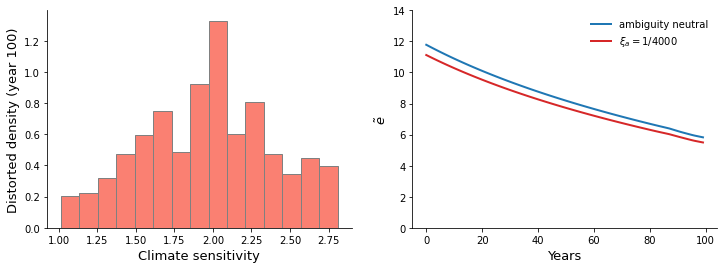

In [28]:
# plot 3
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
ax1.hist(θ_list*1000, weights=πt_avg[-1], density=True, bins=15, color="salmon", ec="grey")
ax1.set_xlabel('Climate sensitivity', fontsize=13)
ax1.set_ylabel('Distorted density (year 100)', fontsize=13)


ax2.plot(et_neutral, color='C0', label='ambiguity neutral', linewidth=2.)
ax2.plot(et_avg, color='C3', label=r'$\xi_a = 1/4000$', linewidth=2.)
ax2.set_xlabel('Years', fontsize=13)
ax2.set_ylabel(r'$\tilde{e}$', fontsize=13)
ax2.legend(frameon=False, loc='upper right')
ax2.set_ylim(0, 14)
# plt.savefig("../figures/hist_ems.pdf")

In [80]:
et_avg

array([10.3862465 , 10.31195458, 10.23874607, 10.1660573 , 10.09469129,
       10.02397532,  9.9539178 ,  9.88508365,  9.81672551,  9.74923446,
        9.68265336,  9.61652697,  9.55140602,  9.48695838,  9.42294559,
        9.36001544,  9.29758907,  9.2355883 ,  9.17467613,  9.11416571,
        9.05410859,  8.9950296 ,  8.9363361 ,  8.87808405,  8.82074394,
        8.76377418,  8.70720149,  8.65151148,  8.59617764,  8.54119772,
        8.48704679,  8.43326609,  8.37982618,  8.32708527,  8.2747795 ,
        8.22280228,  8.17138203,  8.12047729,  8.06988967,  8.01971044,
        7.9701368 ,  7.9208696 ,  7.87190694,  7.82355191,  7.77553959,
        7.72782191,  7.68053203,  7.63371242,  7.58717822,  7.54092768,
        7.49521593,  7.4498068 ,  7.40467278,  7.35989116,  7.3155516 ,
        7.27147915,  7.22767222,  7.18426977,  7.1412066 ,  7.09840156,
        7.0558531 ,  7.01372695,  6.97187448,  6.93027174,  6.88892343,
        6.84797645,  6.80727285,  6.7668112 ,  6.72660386,  6.68

Text(0, 0.5, 'Distorted density (year 90)')

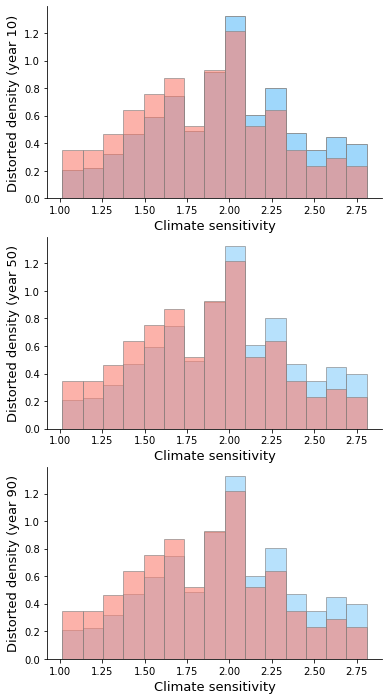

In [30]:
# histogram 10, 50, 90
fig, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(6,12))
ax1.hist(θ_list*1000, weights=πt_avg[10]*np.exp(-10*δ), density=True, bins=15, color='lightskyblue', ec="grey", alpha=0.8)
ax1.set_xlabel('Climate sensitivity', fontsize=13)
ax1.set_ylabel('Distorted density (year 10)', fontsize=13)

ax1.hist(θ_list*1000, density=True, bins=15, color="salmon", ec="grey", alpha=0.6)
ax1.set_xlabel('Climate sensitivity', fontsize=13)
ax1.set_ylabel('Distorted density (year 10)', fontsize=13)


ax2.hist(θ_list*1000, weights=πt_avg[50]*np.exp(-50*δ), density=True, bins=15, color="lightskyblue", ec="grey", alpha=0.6)
ax2.set_xlabel('Climate sensitivity', fontsize=13)
ax2.set_ylabel('Distorted density (year 50)', fontsize=13)

ax2.hist(θ_list*1000, density=True, bins=15, color="salmon", ec="grey", alpha=0.6)
ax2.set_xlabel('Climate sensitivity', fontsize=13)
ax2.set_ylabel('Distorted density (year 50)', fontsize=13)


ax3.hist(θ_list*1000, weights=πt_avg[90]*np.exp(-90*δ), density=True, bins=15, color="lightskyblue", ec="grey", alpha=0.6)
ax3.set_xlabel('Climate sensitivity', fontsize=13)
ax3.set_ylabel('Distorted density (year 90)', fontsize=13)

ax3.hist(θ_list*1000, density=True, bins=15, color="salmon", ec="grey", alpha=0.6)
ax3.set_xlabel('Climate sensitivity', fontsize=13)
ax3.set_ylabel('Distorted density (year 90)', fontsize=13)

# Case 2: bring h back in

$$
\begin{aligned}
0 = \max_{\tilde e} \min_h \min_{\pi^c} &- \delta \phi(y) + \delta\eta \log\tilde e \\
& + \sum \pi^c_i \left[\frac{d\phi}{dy} + (\eta -1)(\gamma_1 + \gamma_2 y) \right]\tilde e \theta_i \\
& + \left[ \frac{d\phi}{dy} + (\eta - 1 )(\gamma_1 + \gamma_2 y)\right]\tilde e \sigma_y h\\
& + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2 + \frac{1}{2}(\eta-1)(\gamma_2 + \gamma_3\mathcal{I}\{y>\bar y\}) (\tilde e)^2 |\sigma_y|^2\\
& + \frac{\xi_m}{2}h'h + \xi_a \sum \pi^c_i (\log \pi^c_i - \log \hat\pi^c_i)
\end{aligned}
$$

Minimize over $h$:
$$
h^* = - \cfrac{\frac{d\phi}{dy} + (\eta - 1 )(\gamma_1 + \gamma_2 y)}{\xi_m}\cdot\tilde e \sigma_y
$$

Plug back in:
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{\pi^c} &- \delta \phi(y) + \delta\eta \log\tilde e \\
& + \sum \pi^c_i \left[\frac{d\phi}{dy} + (\eta -1)(\gamma_1 + \gamma_2 y) \right]\tilde e \theta_i \\
& + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2 + \frac{1}{2}(\eta-1)(\gamma_2 + \gamma_3\mathcal{I}\{y>\bar y\}) (\tilde e)^2 |\sigma_y|^2\\
& - \frac{1}{2\xi_m}\left[ \frac{d\phi}{dy} + (\eta - 1 )(\gamma_1 + \gamma_2 y)\right]^2 (\tilde e)^2 |\sigma_y|^2\\
&  + \xi_a \sum \pi^c_i (\log \pi^c_i - \log \hat\pi^c_i)
\end{aligned}
$$

Optimald distribution:
$$
\pi^c_j \propto \hat\pi^c_j \exp\left( -\frac{1}{\xi_a}\left[\frac{d\phi}{dy} + (\eta -1)(\gamma_1 + \gamma_2 y) \right]\tilde e \theta_j \right)
$$


First order condition for $\tilde e^*$:

$$
  \left[- \frac{1}{\xi_m}\left( \frac{d\phi(y)}{dy}  + (\eta -1)(\gamma_1 + \gamma_2 y) \right)^2 + \frac{d^2\phi(y)}{dy^2} + (\eta-1)(\gamma_2 + \gamma_3\mathcal{I}\{y>\bar y\}) \right] \cdot|\sigma_y|^2(\tilde e)^2 + \sum_j \pi^c_j \left[\frac{d\phi(y)}{dy} + (\eta - 1)(\gamma_1 + \gamma_2 y)\right]\theta_j \tilde e + \delta\eta = 0
$$

$$
A =  \left[- \frac{1}{\xi_m}\left( \frac{d\phi(y)}{dy}  + (\eta -1)(\gamma_1 + \gamma_2 y) \right)^2  + \frac{d^2\phi(y)}{dy^2}+ (\eta-1)(\gamma_2 + \gamma_3\mathcal{I}\{y>\bar y\}) \right] \cdot|\sigma_y|^2
$$

$$
B = \sum_j \pi_j^c \left[\frac{d\phi(y)}{dy} + (\eta - 1)(\gamma_1 + \gamma_2 y)\right]\theta_j
$$

$$
C = \delta\eta
$$
And
$$
\tilde e^* = \frac{-B -  \sqrt{B^2 - 4AC}}{2A}
$$

In [34]:
def solve_smooth_robust(y_grid, args, tol=1e-8, ϵ=0.3, max_iter=10_000):
    δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξₐ, ξₘ = args
    dy = y_grid[1] - y_grid[0]
    dΛ = γ1 + γ2*y_grid + γ3*(y_grid-ȳ)*(y_grid>ȳ)
    ddΛ = γ2 + γ3*(y_grid > ȳ)
    ϕ = - δ*η*y_grid**2
    ems = δ*η
    ems_old = ems
    πo = np.ones((len(θ_list), n_y))/len(θ_list)
    lhs_error = 1
    episode = 0
    while lhs_error > tol and episode < max_iter:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, dy)
        dϕdyy = derivative_1d(ϕ, 2, dy)
        temp = dϕdy + (η-1)*dΛ
        # update belief
        weight = np.array([ - 1/ξₐ*temp*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        π = πo*np.exp(weight)
        π[π <= 1e-15] = 1e-15
        π = π/np.sum(π, axis=0)
        # update control
        a = (dϕdyy - temp**2/ξₘ + (η-1)*ddΛ)*σy**2
        b = (θ_list@π)*temp
        c = δ*η
        Δ = b**2 - 4*a*c
        Δ[Δ < 0] = 0
        root1 = (-b - np.sqrt(Δ))/(2*a)
        root2 = (-b + np.sqrt(Δ))/(2*a)
        if root1.all() > 0:
            ems_new = root1
        else:
            ems_new = root2
        ems_new[ems_new < 1e-15] = 1e-15
        ems = ems_new*1. + ems_old*0.
        # solve for ode
        A = - δ*np.ones(y_grid.shape)
        B = (θ_list@π)*ems
        C = ems**2*σy**2/2
        D = δ*η*np.log(ems) + (θ_list@π)*(η-1)*dΛ*ems \
        + ξₐ*np.sum(π*(np.log(π) - np.log(πo)), axis=0)\
        - temp**2*ems**2*σy**2/(2*ξₘ)\
        + 1/2*(η-1)*ddΛ*ems**2*σy**2
        ϕ_new = solve_ode(A, B, C, D, y_grid, ϕ, ϵ, (False, 0))
        rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        ems_old = ems
        episode += 1
        print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    return ϕ, ems, π

In [81]:
γ3 = np.average(γ3_list, weights=[0.5,0.5,0])
ξₐ = 1000
ξₘ = 1000
args = (δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξₐ, ξₘ)
ϕ_rbt_0, ems_rbt_0, π_rbt_0 = solve_smooth_robust(y_grid, args)

episode: 1,	 ode error: 0.0013141747725647608,	 ft error: 0.0012784564270209278
episode: 2,	 ode error: 0.0012721441762272136,	 ft error: 0.0012352342349843785
episode: 3,	 ode error: 0.0012321978771165254,	 ft error: 0.0011979095444756194
episode: 4,	 ode error: 0.0011973738718880757,	 ft error: 0.0011656107037502127
episode: 5,	 ode error: 0.0011667286578596928,	 ft error: 0.0011387015028535628
episode: 6,	 ode error: 0.0011396080680797845,	 ft error: 0.001114206211837477
episode: 7,	 ode error: 0.0011152526212166796,	 ft error: 0.001091982335866713
episode: 8,	 ode error: 0.0010931397044371155,	 ft error: 0.0010716560047530613
episode: 9,	 ode error: 0.0010728857376607354,	 ft error: 0.0010521748987825953
episode: 10,	 ode error: 0.0010540870407421015,	 ft error: 0.0010350106479637636
episode: 11,	 ode error: 0.0010366977091694966,	 ft error: 0.0010189277770473698
episode: 12,	 ode error: 0.0010204882152373953,	 ft error: 0.0010038225674709233
episode: 13,	 ode error: 0.001005292359

episode: 153,	 ode error: 0.0003997726362172017,	 ft error: 0.00039795739343410447
episode: 154,	 ode error: 0.00039773591410820674,	 ft error: 0.00039594087682446233
episode: 155,	 ode error: 0.00039570926511806514,	 ft error: 0.0003939339792561591
episode: 156,	 ode error: 0.0003936926144150279,	 ft error: 0.0003919366535115945
episode: 157,	 ode error: 0.00039168589058691434,	 ft error: 0.0003899488507214342
episode: 158,	 ode error: 0.0003896890221469696,	 ft error: 0.00038797052352734557
episode: 159,	 ode error: 0.00038770194304043205,	 ft error: 0.0003860016249793846
episode: 160,	 ode error: 0.0003857245872285333,	 ft error: 0.00038404210652738296
episode: 161,	 ode error: 0.0003837568899261022,	 ft error: 0.0003820919210572917
episode: 162,	 ode error: 0.00038179878886143335,	 ft error: 0.00038015102170374054
episode: 163,	 ode error: 0.00037985022711658936,	 ft error: 0.0003782193651239926
episode: 164,	 ode error: 0.00037791114314031783,	 ft error: 0.00037629690320263587
epi

episode: 323,	 ode error: 0.0001663998950621377,	 ft error: 0.0001659953164877039
episode: 324,	 ode error: 0.00016555386163410882,	 ft error: 0.00016515585492417792
episode: 325,	 ode error: 0.00016471237578608304,	 ft error: 0.00016432080337550523
episode: 326,	 ode error: 0.00016387541396999366,	 ft error: 0.00016349014052461736
episode: 327,	 ode error: 0.00016304295142521657,	 ft error: 0.00016266384298027164
episode: 328,	 ode error: 0.0001622149635768311,	 ft error: 0.00016184189239420538
episode: 329,	 ode error: 0.00016139142736134172,	 ft error: 0.0001610242743469807
episode: 330,	 ode error: 0.00016057231797093332,	 ft error: 0.00016021096416833175
episode: 331,	 ode error: 0.00015975761092251327,	 ft error: 0.00015940194020358975
episode: 332,	 ode error: 0.00015894728323164332,	 ft error: 0.00015859718355773028
episode: 333,	 ode error: 0.00015814131076148446,	 ft error: 0.0001577966830904054
episode: 334,	 ode error: 0.00015733966904694105,	 ft error: 0.000157000400045741

episode: 487,	 ode error: 7.361815261279817e-05,	 ft error: 7.361499320043356e-05
episode: 488,	 ode error: 7.326179699149583e-05,	 ft error: 7.325948703680585e-05
episode: 489,	 ode error: 7.290726663857796e-05,	 ft error: 7.290579846908989e-05
episode: 490,	 ode error: 7.255455231011839e-05,	 ft error: 7.255391608113985e-05
episode: 491,	 ode error: 7.2203642610909e-05,	 ft error: 7.2203827617597e-05
episode: 492,	 ode error: 7.185452882140658e-05,	 ft error: 7.185553330709786e-05
episode: 493,	 ode error: 7.150720079020765e-05,	 ft error: 7.150901067796515e-05
episode: 494,	 ode error: 7.116164858855399e-05,	 ft error: 7.116425606227643e-05
episode: 495,	 ode error: 7.081786215736019e-05,	 ft error: 7.082126383735343e-05
episode: 496,	 ode error: 7.047583235162108e-05,	 ft error: 7.048001748805044e-05
episode: 497,	 ode error: 7.013554938681147e-05,	 ft error: 7.014050882390525e-05
episode: 498,	 ode error: 6.979700328573705e-05,	 ft error: 6.980273133903407e-05
episode: 499,	 ode e

episode: 647,	 ode error: 3.433781495332884e-05,	 ft error: 3.437820208067784e-05
episode: 648,	 ode error: 3.417658577501196e-05,	 ft error: 3.42166249435912e-05
episode: 649,	 ode error: 3.401613077791432e-05,	 ft error: 3.405581345860646e-05
episode: 650,	 ode error: 3.385644428970417e-05,	 ft error: 3.3895760180868706e-05
episode: 651,	 ode error: 3.3697524478379414e-05,	 ft error: 3.3736456226142006e-05
episode: 652,	 ode error: 3.353936715747572e-05,	 ft error: 3.3577912021964806e-05
episode: 653,	 ode error: 3.338196773335577e-05,	 ft error: 3.3420111601895994e-05
episode: 654,	 ode error: 3.32253236349756e-05,	 ft error: 3.32630615626726e-05
episode: 655,	 ode error: 3.30694294830709e-05,	 ft error: 3.310674334663921e-05
episode: 656,	 ode error: 3.2914282530509395e-05,	 ft error: 3.2951165203516194e-05
episode: 657,	 ode error: 3.275987876069728e-05,	 ft error: 3.2796320294075275e-05
episode: 658,	 ode error: 3.260621549621735e-05,	 ft error: 3.264220481346651e-05
episode: 659

episode: 818,	 ode error: 1.5496427663878854e-05,	 ft error: 1.4552857671758698e-05
episode: 819,	 ode error: 1.5424345085663055e-05,	 ft error: 1.543802460479693e-05
episode: 820,	 ode error: 1.5355376337908093e-05,	 ft error: 1.4378873107757466e-05
episode: 821,	 ode error: 1.5283965313337778e-05,	 ft error: 1.5297924720163634e-05
episode: 822,	 ode error: 1.521586920766294e-05,	 ft error: 1.4167204499306493e-05
episode: 823,	 ode error: 1.514511561238668e-05,	 ft error: 1.515935516227529e-05
episode: 824,	 ode error: 1.5074480968364757e-05,	 ft error: 1.5088814416276224e-05
episode: 825,	 ode error: 1.5007233001414102e-05,	 ft error: 1.4021861484853997e-05
episode: 826,	 ode error: 1.4937490376754525e-05,	 ft error: 1.4952126169698321e-05
episode: 827,	 ode error: 1.4867855141337412e-05,	 ft error: 1.4882589235408935e-05
episode: 828,	 ode error: 1.4801730562965859e-05,	 ft error: 1.3770330591147961e-05
episode: 829,	 ode error: 1.4732963982644082e-05,	 ft error: 1.4748005565598521e

episode: 982,	 ode error: 7.136322933835957e-06,	 ft error: 7.925078127380785e-06
episode: 983,	 ode error: 7.101563191455628e-06,	 ft error: 7.881596590213666e-06
episode: 984,	 ode error: 7.0669936284792085e-06,	 ft error: 7.838700760108102e-06
episode: 985,	 ode error: 7.032611509835197e-06,	 ft error: 7.796370434035027e-06
episode: 986,	 ode error: 6.998415309307049e-06,	 ft error: 7.754627184391091e-06
episode: 987,	 ode error: 6.96440313131797e-06,	 ft error: 7.713443229695471e-06
episode: 988,	 ode error: 6.930573618664764e-06,	 ft error: 7.67273979522994e-06
episode: 989,	 ode error: 6.896925408516577e-06,	 ft error: 7.632582266145493e-06
episode: 990,	 ode error: 6.863455876824427e-06,	 ft error: 7.592899859062974e-06
episode: 991,	 ode error: 6.830164022006793e-06,	 ft error: 7.55367949562454e-06
episode: 992,	 ode error: 6.7970479317406175e-06,	 ft error: 7.514898665295089e-06
episode: 993,	 ode error: 6.764107772227481e-06,	 ft error: 7.476570173757062e-06
episode: 994,	 od

episode: 1155,	 ode error: 4.235113212733787e-06,	 ft error: 3.4926787478387995e-06
episode: 1156,	 ode error: 4.227123389391571e-06,	 ft error: 3.4756805585012263e-06
episode: 1157,	 ode error: 4.219177529810156e-06,	 ft error: 3.4587458214394946e-06
episode: 1158,	 ode error: 4.211275986291171e-06,	 ft error: 3.4418837452365736e-06
episode: 1159,	 ode error: 4.203417295754416e-06,	 ft error: 3.4250784020315823e-06
episode: 1160,	 ode error: 4.195601762942884e-06,	 ft error: 3.4083372543736168e-06
episode: 1161,	 ode error: 4.1878290807590215e-06,	 ft error: 3.3916677772786547e-06
episode: 1162,	 ode error: 4.18009900309468e-06,	 ft error: 3.375053102226226e-06
episode: 1163,	 ode error: 4.172410268975463e-06,	 ft error: 3.3585073395033436e-06
episode: 1164,	 ode error: 4.164763728921328e-06,	 ft error: 3.342024616330893e-06
episode: 1165,	 ode error: 4.157158204992368e-06,	 ft error: 3.3255932646812187e-06
episode: 1166,	 ode error: 4.14959470147584e-06,	 ft error: 3.309233368049373e

episode: 1313,	 ode error: 3.364619021114807e-06,	 ft error: 1.5394906808842887e-06
episode: 1314,	 ode error: 3.3609125141671964e-06,	 ft error: 1.5349186330629316e-06
episode: 1315,	 ode error: 3.3572223765614487e-06,	 ft error: 1.5303590207802846e-06
episode: 1316,	 ode error: 3.3535497410052068e-06,	 ft error: 1.5258102139976508e-06
episode: 1317,	 ode error: 3.349894291126e-06,	 ft error: 1.521274358637359e-06
episode: 1318,	 ode error: 3.3462550117376293e-06,	 ft error: 1.5167474317368905e-06
episode: 1319,	 ode error: 3.3426319208418624e-06,	 ft error: 1.5122347151360258e-06
episode: 1320,	 ode error: 3.339025891619784e-06,	 ft error: 1.5077319692515432e-06
episode: 1321,	 ode error: 3.335436744390471e-06,	 ft error: 1.5032425141128791e-06
episode: 1322,	 ode error: 3.3318642738811672e-06,	 ft error: 1.4987629845762223e-06
episode: 1323,	 ode error: 3.3283078919644528e-06,	 ft error: 1.4942948103659668e-06
episode: 1324,	 ode error: 3.324767378664489e-06,	 ft error: 1.4898389401

episode: 1480,	 ode error: 2.9393832543871904e-06,	 ft error: 9.333171662948003e-07
episode: 1481,	 ode error: 2.9377809708622553e-06,	 ft error: 9.305360757054978e-07
episode: 1482,	 ode error: 2.93618816043248e-06,	 ft error: 9.27764660235697e-07
episode: 1483,	 ode error: 2.93460450753204e-06,	 ft error: 9.250010384852699e-07
episode: 1484,	 ode error: 2.933028544400344e-06,	 ft error: 9.222455407340013e-07
episode: 1485,	 ode error: 2.9314612310422537e-06,	 ft error: 9.194992465812642e-07
episode: 1486,	 ode error: 2.929903542861663e-06,	 ft error: 9.167607954950012e-07
episode: 1487,	 ode error: 2.9283537221153153e-06,	 ft error: 9.140313689028531e-07
episode: 1488,	 ode error: 2.926811940832919e-06,	 ft error: 9.113093290176918e-07
episode: 1489,	 ode error: 2.925279512717635e-06,	 ft error: 9.085961750222398e-07
episode: 1490,	 ode error: 2.9237545318938326e-06,	 ft error: 9.058923087131484e-07
episode: 1491,	 ode error: 2.9222388597836607e-06,	 ft error: 9.031938465649721e-07
e

episode: 1652,	 ode error: 2.7639278462665345e-06,	 ft error: 5.602813062458023e-07
episode: 1653,	 ode error: 2.7633532539942263e-06,	 ft error: 5.586257864042173e-07
episode: 1654,	 ode error: 2.762781869134444e-06,	 ft error: 5.56975529158547e-07
episode: 1655,	 ode error: 2.762214254428989e-06,	 ft error: 5.553293033524106e-07
episode: 1656,	 ode error: 2.7616506178593887e-06,	 ft error: 5.536893210820553e-07
episode: 1657,	 ode error: 2.7610908670109603e-06,	 ft error: 5.520525451936191e-07
episode: 1658,	 ode error: 2.7605343120260277e-06,	 ft error: 5.504209465642673e-07
episode: 1659,	 ode error: 2.759981602492071e-06,	 ft error: 5.487943757996143e-07
episode: 1660,	 ode error: 2.7594326405359915e-06,	 ft error: 5.471730596280182e-07
episode: 1661,	 ode error: 2.7588876706481982e-06,	 ft error: 5.455558430127646e-07
episode: 1662,	 ode error: 2.758345843959214e-06,	 ft error: 5.439432816089126e-07
episode: 1663,	 ode error: 2.7578075819618486e-06,	 ft error: 5.42334885299256e-0

episode: 1824,	 ode error: 2.7065188506573143e-06,	 ft error: 3.3641853927623977e-07
episode: 1825,	 ode error: 2.7063638057295714e-06,	 ft error: 3.354198368938725e-07
episode: 1826,	 ode error: 2.706209895216331e-06,	 ft error: 3.344253206189844e-07
episode: 1827,	 ode error: 2.7060577480326987e-06,	 ft error: 3.33433317692422e-07
episode: 1828,	 ode error: 2.7059069717626488e-06,	 ft error: 3.3244306295078985e-07
episode: 1829,	 ode error: 2.705757375908932e-06,	 ft error: 3.314556125631289e-07
episode: 1830,	 ode error: 2.705609370432893e-06,	 ft error: 3.304720362177586e-07
episode: 1831,	 ode error: 2.7054628322080877e-06,	 ft error: 3.2949195568713713e-07
episode: 1832,	 ode error: 2.705317787112145e-06,	 ft error: 3.2851291234768193e-07
episode: 1833,	 ode error: 2.7051740480552467e-06,	 ft error: 3.2753855471606697e-07
episode: 1834,	 ode error: 2.7050314149174156e-06,	 ft error: 3.265670502882364e-07
episode: 1835,	 ode error: 2.7048907376678354e-06,	 ft error: 3.255967993947

episode: 1976,	 ode error: 2.6957042937053198e-06,	 ft error: 2.1396143156983868e-07
episode: 1977,	 ode error: 2.6956963808110216e-06,	 ft error: 2.1332546709431263e-07
episode: 1978,	 ode error: 2.6956886977584768e-06,	 ft error: 2.126904707563937e-07
episode: 1979,	 ode error: 2.695681599606983e-06,	 ft error: 2.1205640381392426e-07
episode: 1980,	 ode error: 2.6956750952028714e-06,	 ft error: 2.1142484576732365e-07
episode: 1981,	 ode error: 2.695668937409846e-06,	 ft error: 2.1079546721573344e-07
episode: 1982,	 ode error: 2.6956633017001736e-06,	 ft error: 2.101686919520988e-07
episode: 1983,	 ode error: 2.6956581992937205e-06,	 ft error: 2.0954354821902296e-07
episode: 1984,	 ode error: 2.695653632269119e-06,	 ft error: 2.089202350355479e-07
episode: 1985,	 ode error: 2.695649922097084e-06,	 ft error: 2.0829898110761674e-07
episode: 1986,	 ode error: 2.695647055567154e-06,	 ft error: 2.0767855281554154e-07
episode: 1987,	 ode error: 2.695644259144772e-06,	 ft error: 2.0706028959

episode: 2151,	 ode error: 2.7003320707121936e-06,	 ft error: 1.2696175033753237e-07
episode: 2152,	 ode error: 2.7003808195653466e-06,	 ft error: 1.265839778598806e-07
episode: 2153,	 ode error: 2.7004296653226467e-06,	 ft error: 1.2620767113104744e-07
episode: 2154,	 ode error: 2.700478655938681e-06,	 ft error: 1.2583270589857273e-07
episode: 2155,	 ode error: 2.7005280412990655e-06,	 ft error: 1.2545781074892645e-07
episode: 2156,	 ode error: 2.7005773918558013e-06,	 ft error: 1.2508482904553347e-07
episode: 2157,	 ode error: 2.7006270126181614e-06,	 ft error: 1.2471209097827027e-07
episode: 2158,	 ode error: 2.7006767115446677e-06,	 ft error: 1.2434055828939677e-07
episode: 2159,	 ode error: 2.700726278551959e-06,	 ft error: 1.239698774075741e-07
episode: 2160,	 ode error: 2.700776118380729e-06,	 ft error: 1.2360017893435032e-07
episode: 2161,	 ode error: 2.7008263574042823e-06,	 ft error: 1.2323116942390228e-07
episode: 2162,	 ode error: 2.700876235592559e-06,	 ft error: 1.2286389

episode: 2324,	 ode error: 2.7098282096948804e-06,	 ft error: 7.574616737079007e-08
episode: 2325,	 ode error: 2.709884605303441e-06,	 ft error: 7.552054497964959e-08
episode: 2326,	 ode error: 2.709941077032752e-06,	 ft error: 7.5295394340776e-08
episode: 2327,	 ode error: 2.7099975788469387e-06,	 ft error: 7.507077156669133e-08
episode: 2328,	 ode error: 2.7100538754328213e-06,	 ft error: 7.484612264454146e-08
episode: 2329,	 ode error: 2.71011026526974e-06,	 ft error: 7.462294055830358e-08
episode: 2330,	 ode error: 2.710166768721289e-06,	 ft error: 7.44000051034847e-08
episode: 2331,	 ode error: 2.710222978883031e-06,	 ft error: 7.417773979547423e-08
episode: 2332,	 ode error: 2.7102795865656566e-06,	 ft error: 7.395652396047225e-08
episode: 2333,	 ode error: 2.7103358407055663e-06,	 ft error: 7.373539894402667e-08
episode: 2334,	 ode error: 2.7103922779232043e-06,	 ft error: 7.351597969273982e-08
episode: 2335,	 ode error: 2.710448445388089e-06,	 ft error: 7.329648376667534e-08
ep

episode: 2499,	 ode error: 2.7190591993870228e-06,	 ft error: 4.489479860786405e-08
episode: 2500,	 ode error: 2.7191068789616125e-06,	 ft error: 4.4761080640609574e-08
episode: 2501,	 ode error: 2.719154525631859e-06,	 ft error: 4.462727512764368e-08
episode: 2502,	 ode error: 2.719202195445051e-06,	 ft error: 4.449408932729234e-08
episode: 2503,	 ode error: 2.7192496888096525e-06,	 ft error: 4.436131404346918e-08
episode: 2504,	 ode error: 2.719297085326702e-06,	 ft error: 4.4228448288034336e-08
episode: 2505,	 ode error: 2.719344564076258e-06,	 ft error: 4.4096540759153147e-08
episode: 2506,	 ode error: 2.7193919071771605e-06,	 ft error: 4.396450013072206e-08
episode: 2507,	 ode error: 2.719439117019858e-06,	 ft error: 4.383339451824453e-08
episode: 2508,	 ode error: 2.7194862574633164e-06,	 ft error: 4.370223738447976e-08
episode: 2509,	 ode error: 2.7195334221518123e-06,	 ft error: 4.3571441628309504e-08
episode: 2510,	 ode error: 2.7195806333102975e-06,	 ft error: 4.3441459515273

episode: 2672,	 ode error: 2.7262843963978033e-06,	 ft error: 2.6755427653494628e-08
episode: 2673,	 ode error: 2.726320117638981e-06,	 ft error: 2.6675573312762157e-08
episode: 2674,	 ode error: 2.726355779897934e-06,	 ft error: 2.659589018923677e-08
episode: 2675,	 ode error: 2.7263913740773393e-06,	 ft error: 2.651646602523187e-08
episode: 2676,	 ode error: 2.7264269056083987e-06,	 ft error: 2.64374182152675e-08
episode: 2677,	 ode error: 2.726462545535823e-06,	 ft error: 2.6358617545574337e-08
episode: 2678,	 ode error: 2.7264979660426283e-06,	 ft error: 2.6279629352273424e-08
episode: 2679,	 ode error: 2.726533289290861e-06,	 ft error: 2.620082787304264e-08
episode: 2680,	 ode error: 2.7265685383954944e-06,	 ft error: 2.612254611696526e-08
episode: 2681,	 ode error: 2.7266037209059367e-06,	 ft error: 2.6044393516833075e-08
episode: 2682,	 ode error: 2.7266388407713943e-06,	 ft error: 2.596624849166007e-08
episode: 2683,	 ode error: 2.7266742047267565e-06,	 ft error: 2.588867945250

episode: 2844,	 ode error: 2.7314976011846067e-06,	 ft error: 1.59866438952568e-08
episode: 2845,	 ode error: 2.731522958961791e-06,	 ft error: 1.593878385756457e-08
episode: 2846,	 ode error: 2.731548046416908e-06,	 ft error: 1.5890886372974904e-08
episode: 2847,	 ode error: 2.731573064129419e-06,	 ft error: 1.5843416890926054e-08
episode: 2848,	 ode error: 2.731598053234822e-06,	 ft error: 1.5795818276061656e-08
episode: 2849,	 ode error: 2.731622940063856e-06,	 ft error: 1.5748623782378218e-08
episode: 2850,	 ode error: 2.7316478086013155e-06,	 ft error: 1.570143924600753e-08
episode: 2851,	 ode error: 2.7316725951970515e-06,	 ft error: 1.5654561686303157e-08
episode: 2852,	 ode error: 2.7316973724584572e-06,	 ft error: 1.5607686659295055e-08
episode: 2853,	 ode error: 2.731722423242604e-06,	 ft error: 1.5560997305523e-08
episode: 2854,	 ode error: 2.7317470608439164e-06,	 ft error: 1.551438829257753e-08
episode: 2855,	 ode error: 2.731771654620259e-06,	 ft error: 1.5467795042486042

In [82]:
yt_rbt_0, et_rbt_0, πt_rbt_0 = simulate_traj(y_grid, ems_rbt_0, π_rbt_0, θ_list)

In [48]:
def compute_h_star(ϕ, ems, y_grid, args):
    η, σy, γ1, γ2, γ3, ȳ, ξₘ = args
    dy = y_grid[1] - y_grid[0]
    dϕdy = derivative_1d(ϕ, 1, dy)
    dΛ = γ1 + γ2*y_grid + γ3*(y_grid - ȳ)*(y_grid>ȳ)
    h_star = dϕdy + (η-1)*dΛ
    h_star *= ems*σy
    h_star *= - 1/ξₘ
    return h_star

In [49]:
args = (η, σy, γ1, γ2, γ3, ȳ, ξₘ)
h_star_0 = compute_h_star(ϕ_rbt_0, ems_rbt_0, y_grid, args)

(0.0, 0.08696789894267677)

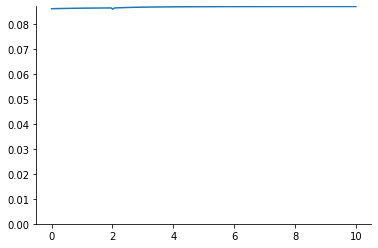

In [50]:
plt.plot(y_grid, h_star_0)
plt.ylim(bottom=0)

In [84]:
γ3 = np.average(γ3_list, weights=[0.5,0.5,0])
ξₐ = 1/4000
ξₘ = 1000
args = (δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξₐ, ξₘ)
ϕ_rbt, ems_rbt, π_rbt = solve_smooth_robust(y_grid, args)

episode: 1,	 ode error: 0.0013141747713963925,	 ft error: 0.001278456418137521
episode: 2,	 ode error: 0.0012713950633105793,	 ft error: 0.0012327576099398785
episode: 3,	 ode error: 0.001230113829000043,	 ft error: 0.0011953343519594936
episode: 4,	 ode error: 0.001194174682673964,	 ft error: 0.0011621753613565763
episode: 5,	 ode error: 0.0011626574861792434,	 ft error: 0.0011339311490412606
episode: 6,	 ode error: 0.0011347603550803057,	 ft error: 0.0011086923049858563
episode: 7,	 ode error: 0.0011097553098447551,	 ft error: 0.0010851743032650096
episode: 8,	 ode error: 0.001086987517838505,	 ft error: 0.0010646420004819588
episode: 9,	 ode error: 0.0010662544625413412,	 ft error: 0.0010456690634160284
episode: 10,	 ode error: 0.0010471894794397846,	 ft error: 0.0010280720605823968
episode: 11,	 ode error: 0.0010295291076358633,	 ft error: 0.0010116685808680523
episode: 12,	 ode error: 0.0010130718651961924,	 ft error: 0.0009963045371409495
episode: 13,	 ode error: 0.00099765807715

episode: 153,	 ode error: 0.00039376242080038345,	 ft error: 0.0003921107753398004
episode: 154,	 ode error: 0.00039174373920124097,	 ft error: 0.000390106947773701
episode: 155,	 ode error: 0.0003897351044590163,	 ft error: 0.0003881130108323444
episode: 156,	 ode error: 0.00038773643643115723,	 ft error: 0.0003861288876490579
episode: 157,	 ode error: 0.0003857476577509546,	 ft error: 0.0003841545039630935
episode: 158,	 ode error: 0.0003837686937198557,	 ft error: 0.0003821897880232813
episode: 159,	 ode error: 0.0003817994722020629,	 ft error: 0.00038023467049348725
episode: 160,	 ode error: 0.00037983992352142836,	 ft error: 0.0003782890843592619
episode: 161,	 ode error: 0.0003778899803607449,	 ft error: 0.0003763529648363971
episode: 162,	 ode error: 0.00037594957766342847,	 ft error: 0.0003744262492813566
episode: 163,	 ode error: 0.0003740186525376559,	 ft error: 0.0003725088771031985
episode: 164,	 ode error: 0.00037209714416293197,	 ft error: 0.00037060078967783344
episode: 

episode: 320,	 ode error: 0.0001652932524744702,	 ft error: 0.0001650435064037605
episode: 321,	 ode error: 0.0001644433113283366,	 ft error: 0.00016419694409373908
episode: 322,	 ode error: 0.0001635979804121147,	 ft error: 0.0001633549508535855
episode: 323,	 ode error: 0.00016275723463141122,	 ft error: 0.0001625175023204038
episode: 324,	 ode error: 0.0001619210489906891,	 ft error: 0.0001616845742103551
episode: 325,	 ode error: 0.00016108939859408114,	 ft error: 0.00016085614232122514
episode: 326,	 ode error: 0.00016026225864608653,	 ft error: 0.00016003218253304863
episode: 327,	 ode error: 0.00015943960445230563,	 ft error: 0.00015921267080947396
episode: 328,	 ode error: 0.0001586214114200782,	 ft error: 0.0001583975831994979
episode: 329,	 ode error: 0.00015780765505913437,	 ft error: 0.00015758689583792823
episode: 330,	 ode error: 0.00015699831098220092,	 ft error: 0.00015678058494748848
episode: 331,	 ode error: 0.00015619335490555557,	 ft error: 0.00015597862683907246
ep

episode: 478,	 ode error: 7.461230385644494e-05,	 ft error: 7.462296163921837e-05
episode: 479,	 ode error: 7.424611741058931e-05,	 ft error: 7.425743877978452e-05
episode: 480,	 ode error: 7.388181707857378e-05,	 ft error: 7.389379428186793e-05
episode: 481,	 ode error: 7.351939228585687e-05,	 ft error: 7.353201760589012e-05
episode: 482,	 ode error: 7.315883252226264e-05,	 ft error: 7.317209827567099e-05
episode: 483,	 ode error: 7.280012734168866e-05,	 ft error: 7.281402587905328e-05
episode: 484,	 ode error: 7.244326636176408e-05,	 ft error: 7.245779006607538e-05
episode: 485,	 ode error: 7.208823926354126e-05,	 ft error: 7.210338055049781e-05
episode: 486,	 ode error: 7.173503579116535e-05,	 ft error: 7.175078710786043e-05
episode: 487,	 ode error: 7.138364575157152e-05,	 ft error: 7.139999957636127e-05
episode: 488,	 ode error: 7.103405901418035e-05,	 ft error: 7.105100785590827e-05
episode: 489,	 ode error: 7.068626551052343e-05,	 ft error: 7.07038019077492e-05
episode: 490,	 od

episode: 647,	 ode error: 3.290872139857337e-05,	 ft error: 3.29313792185824e-05
episode: 648,	 ode error: 3.275160286317228e-05,	 ft error: 3.277366813149903e-05
episode: 649,	 ode error: 3.259525124316566e-05,	 ft error: 3.261671320096508e-05
episode: 650,	 ode error: 3.2439662654449534e-05,	 ft error: 3.246051042899804e-05
episode: 651,	 ode error: 3.228483323434181e-05,	 ft error: 3.2305055833597995e-05
episode: 652,	 ode error: 3.213075914145706e-05,	 ft error: 3.215034545369737e-05
episode: 653,	 ode error: 3.1977436555598185e-05,	 ft error: 3.1996375345529536e-05
episode: 654,	 ode error: 3.18248616776283e-05,	 ft error: 3.184314158385475e-05
episode: 655,	 ode error: 3.167303072936054e-05,	 ft error: 3.1690640262353284e-05
episode: 656,	 ode error: 3.152193995344934e-05,	 ft error: 3.153886749128939e-05
episode: 657,	 ode error: 3.13715856132701e-05,	 ft error: 3.138781939926912e-05
episode: 658,	 ode error: 3.122196399281288e-05,	 ft error: 3.123749213217638e-05
episode: 659,	

episode: 818,	 ode error: 1.4654984410641014e-05,	 ft error: 1.3624413546057628e-05
episode: 819,	 ode error: 1.4585298251426388e-05,	 ft error: 1.459299216332218e-05
episode: 820,	 ode error: 1.4518830383084165e-05,	 ft error: 1.3553208259113141e-05
episode: 821,	 ode error: 1.4449845668380954e-05,	 ft error: 1.4457812964792835e-05
episode: 822,	 ode error: 1.4384021862660543e-05,	 ft error: 1.3432578526983985e-05
episode: 823,	 ode error: 1.4315707381710703e-05,	 ft error: 1.432394289009135e-05
episode: 824,	 ode error: 1.4250596591008197e-05,	 ft error: 1.3280717979143505e-05
episode: 825,	 ode error: 1.41829288126911e-05,	 ft error: 1.419142491657551e-05
episode: 826,	 ode error: 1.4118584950453665e-05,	 ft error: 1.3105056289481703e-05
episode: 827,	 ode error: 1.405154572245459e-05,	 ft error: 1.4060293739755666e-05
episode: 828,	 ode error: 1.398802153190575e-05,	 ft error: 1.2907540038834913e-05
episode: 829,	 ode error: 1.3921596063043505e-05,	 ft error: 1.3930586903951325e-05

episode: 986,	 ode error: 6.581211899777967e-06,	 ft error: 7.700538090701e-06
episode: 987,	 ode error: 6.550960415064775e-06,	 ft error: 6.541422218828141e-06
episode: 988,	 ode error: 6.5168386909525465e-06,	 ft error: 7.597585992211164e-06
episode: 989,	 ode error: 6.486889535522382e-06,	 ft error: 6.476804205133672e-06
episode: 990,	 ode error: 6.453180458789527e-06,	 ft error: 7.5050917059995194e-06
episode: 991,	 ode error: 6.420221373399466e-06,	 ft error: 7.51908861717591e-06
episode: 992,	 ode error: 6.3907213798633945e-06,	 ft error: 6.37945825316307e-06
episode: 993,	 ode error: 6.357441322370596e-06,	 ft error: 7.4123357720704925e-06
episode: 994,	 ode error: 6.324931403186174e-06,	 ft error: 7.422079993148664e-06
episode: 995,	 ode error: 6.295877775704898e-06,	 ft error: 6.2835532221861e-06
episode: 996,	 ode error: 6.263069939019261e-06,	 ft error: 7.309600201256076e-06
episode: 997,	 ode error: 6.231037612826579e-06,	 ft error: 7.315901323357021e-06
episode: 998,	 ode 

episode: 1113,	 ode error: 4.063779248851323e-06,	 ft error: 4.207299707445489e-06
episode: 1114,	 ode error: 4.054504037662545e-06,	 ft error: 4.185344355464582e-06
episode: 1115,	 ode error: 4.045306038909431e-06,	 ft error: 4.1634836452318176e-06
episode: 1116,	 ode error: 4.036184240491963e-06,	 ft error: 4.141718721572171e-06
episode: 1117,	 ode error: 4.027137621086111e-06,	 ft error: 4.120050693575314e-06
episode: 1118,	 ode error: 4.018165151708337e-06,	 ft error: 4.098480592314621e-06
episode: 1119,	 ode error: 4.009265798308407e-06,	 ft error: 4.0770093921727035e-06
episode: 1120,	 ode error: 4.0004385236099916e-06,	 ft error: 4.055638008297151e-06
episode: 1121,	 ode error: 3.991682288905559e-06,	 ft error: 4.034367296600524e-06
episode: 1122,	 ode error: 3.982996055829373e-06,	 ft error: 4.013198031324605e-06
episode: 1123,	 ode error: 3.9743787885590715e-06,	 ft error: 3.992130934368787e-06
episode: 1124,	 ode error: 3.965829455110316e-06,	 ft error: 3.971166659145579e-06


episode: 1247,	 ode error: 3.244881765598537e-06,	 ft error: 2.0649293798237953e-06
episode: 1248,	 ode error: 3.24099928013721e-06,	 ft error: 2.0597525201074274e-06
episode: 1249,	 ode error: 3.2371414057210724e-06,	 ft error: 2.0545832282378718e-06
episode: 1250,	 ode error: 3.233307931647738e-06,	 ft error: 2.0494213945343454e-06
episode: 1251,	 ode error: 3.2294986461394e-06,	 ft error: 2.0442669063670355e-06
episode: 1252,	 ode error: 3.225713336334321e-06,	 ft error: 2.0391196578599855e-06
episode: 1253,	 ode error: 3.2219517886269457e-06,	 ft error: 2.0339795406508028e-06
episode: 1254,	 ode error: 3.2182137886350515e-06,	 ft error: 2.028846449823411e-06
episode: 1255,	 ode error: 3.214499121404499e-06,	 ft error: 2.0237202816991706e-06
episode: 1256,	 ode error: 3.2108075715140197e-06,	 ft error: 2.018600934970231e-06
episode: 1257,	 ode error: 3.2071389232176273e-06,	 ft error: 2.0134883112315114e-06
episode: 1258,	 ode error: 3.2034929605927187e-06,	 ft error: 2.008382311384

episode: 1407,	 ode error: 2.613809058393411e-06,	 ft error: 1.3323268648057773e-06
episode: 1408,	 ode error: 2.6196575172428922e-06,	 ft error: 1.3891396686884403e-06
episode: 1409,	 ode error: 2.6050291699321283e-06,	 ft error: 1.3822595925962653e-06
episode: 1410,	 ode error: 2.5935482789705717e-06,	 ft error: 1.3206310957534588e-06
episode: 1411,	 ode error: 2.600041178228642e-06,	 ft error: 1.3712457462566885e-06
episode: 1412,	 ode error: 2.5884801658194686e-06,	 ft error: 1.3153185131227023e-06
episode: 1413,	 ode error: 2.594952275250214e-06,	 ft error: 1.3603164929210099e-06
episode: 1414,	 ode error: 2.5833274563403217e-06,	 ft error: 1.3094306881035005e-06
episode: 1415,	 ode error: 2.589770464160731e-06,	 ft error: 1.3495027567644868e-06
episode: 1416,	 ode error: 2.5757465880559666e-06,	 ft error: 1.3429029660968115e-06
episode: 1417,	 ode error: 2.564830799185562e-06,	 ft error: 1.2979577458776168e-06
episode: 1418,	 ode error: 2.571818725531855e-06,	 ft error: 1.3324371

episode: 1581,	 ode error: 2.3730221790845365e-06,	 ft error: 8.671494203596475e-07
episode: 1582,	 ode error: 2.3756948849962137e-06,	 ft error: 8.422971624344466e-07
episode: 1583,	 ode error: 2.3606108290128293e-06,	 ft error: 8.590890400913173e-07
episode: 1584,	 ode error: 2.3662217714231224e-06,	 ft error: 8.590777843496082e-07
episode: 1585,	 ode error: 2.371531061105554e-06,	 ft error: 8.584189004299618e-07
episode: 1586,	 ode error: 2.374180443254117e-06,	 ft error: 8.36378137395825e-07
episode: 1587,	 ode error: 2.3590680504647406e-06,	 ft error: 8.504423255432474e-07
episode: 1588,	 ode error: 2.364663306314639e-06,	 ft error: 8.504642497186854e-07
episode: 1589,	 ode error: 2.369959134668339e-06,	 ft error: 8.498393551728545e-07
episode: 1590,	 ode error: 2.3725958904840887e-06,	 ft error: 8.305272972362425e-07
episode: 1591,	 ode error: 2.3574635825036883e-06,	 ft error: 8.419488706570832e-07
episode: 1592,	 ode error: 2.3630528192585334e-06,	 ft error: 8.420031332121807e-

episode: 1756,	 ode error: 2.449181369293949e-06,	 ft error: 7.178749387183141e-07
episode: 1757,	 ode error: 2.4495725725226145e-06,	 ft error: 5.015160581036312e-07
episode: 1758,	 ode error: 2.451004555598839e-06,	 ft error: 4.9927904121246e-07
episode: 1759,	 ode error: 2.452422335570009e-06,	 ft error: 4.971090232971006e-07
episode: 1760,	 ode error: 2.453826877602547e-06,	 ft error: 4.949915954436761e-07
episode: 1761,	 ode error: 2.4535021886341814e-06,	 ft error: 7.199261424506442e-07
episode: 1762,	 ode error: 2.453867666321033e-06,	 ft error: 4.932788188564501e-07
episode: 1763,	 ode error: 2.4552741523165738e-06,	 ft error: 4.911028108484095e-07
episode: 1764,	 ode error: 2.456666363956166e-06,	 ft error: 4.889944435019593e-07
episode: 1765,	 ode error: 2.456325954683998e-06,	 ft error: 7.187559116749361e-07
episode: 1766,	 ode error: 2.4566753486224757e-06,	 ft error: 4.873346935718725e-07
episode: 1767,	 ode error: 2.4580673326383756e-06,	 ft error: 4.851922925236396e-07
e

episode: 1916,	 ode error: 2.462137742393342e-06,	 ft error: 4.582918345860665e-07
episode: 1917,	 ode error: 2.4616786309377293e-06,	 ft error: 6.151469607191633e-07
episode: 1918,	 ode error: 2.461902091554385e-06,	 ft error: 4.5909961576597513e-07
episode: 1919,	 ode error: 2.461442920415611e-06,	 ft error: 6.161688083950827e-07
episode: 1920,	 ode error: 2.4616669267417944e-06,	 ft error: 4.60031747533581e-07
episode: 1921,	 ode error: 2.462944858643045e-06,	 ft error: 4.4770131886473497e-07
episode: 1922,	 ode error: 2.4624745411782755e-06,	 ft error: 6.23449099221296e-07
episode: 1923,	 ode error: 2.4626878809602595e-06,	 ft error: 4.492381045981264e-07
episode: 1924,	 ode error: 2.4622174674016756e-06,	 ft error: 6.251299304478135e-07
episode: 1925,	 ode error: 2.462431764240847e-06,	 ft error: 4.5097694892128526e-07
episode: 1926,	 ode error: 2.4636996583522167e-06,	 ft error: 4.3905720085076394e-07
episode: 1927,	 ode error: 2.4632188862431354e-06,	 ft error: 6.322800708928138

episode: 2081,	 ode error: 2.55132393417321e-06,	 ft error: 2.729614328086013e-07
episode: 2082,	 ode error: 2.552046253589133e-06,	 ft error: 2.721313973700716e-07
episode: 2083,	 ode error: 2.5510142302903366e-06,	 ft error: 8.432659171058362e-07
episode: 2084,	 ode error: 2.550684583850851e-06,	 ft error: 2.714626223347209e-07
episode: 2085,	 ode error: 2.5514160064238583e-06,	 ft error: 2.7061673936457087e-07
episode: 2086,	 ode error: 2.5503889272492737e-06,	 ft error: 8.363882844641957e-07
episode: 2087,	 ode error: 2.5500636122391548e-06,	 ft error: 2.701821481589558e-07
episode: 2088,	 ode error: 2.550801135415041e-06,	 ft error: 2.69438121813792e-07
episode: 2089,	 ode error: 2.5497787368168037e-06,	 ft error: 8.290735266600995e-07
episode: 2090,	 ode error: 2.549457126554348e-06,	 ft error: 2.6893662889252806e-07
episode: 2091,	 ode error: 2.5501987596358465e-06,	 ft error: 2.6815412719020476e-07
episode: 2092,	 ode error: 2.549180316448478e-06,	 ft error: 8.221854504858461e-

episode: 2250,	 ode error: 2.5148610757348136e-06,	 ft error: 3.2545746756161103e-07
episode: 2251,	 ode error: 2.5156937243628113e-06,	 ft error: 3.243634326410838e-07
episode: 2252,	 ode error: 2.5165201158046336e-06,	 ft error: 3.2328420727460266e-07
episode: 2253,	 ode error: 2.517340660660437e-06,	 ft error: 3.221707045123849e-07
episode: 2254,	 ode error: 2.5181557108249495e-06,	 ft error: 3.21023811561405e-07
episode: 2255,	 ode error: 2.5172211737193163e-06,	 ft error: 8.291811220972889e-07
episode: 2256,	 ode error: 2.5169978430738898e-06,	 ft error: 3.195905745832321e-07
episode: 2257,	 ode error: 2.5178351959952118e-06,	 ft error: 3.1842440836871155e-07
episode: 2258,	 ode error: 2.518664095369481e-06,	 ft error: 3.1720325933034166e-07
episode: 2259,	 ode error: 2.5194851886729103e-06,	 ft error: 3.159339059116695e-07
episode: 2260,	 ode error: 2.5202990532500417e-06,	 ft error: 3.146207764685253e-07
episode: 2261,	 ode error: 2.521106196913959e-06,	 ft error: 3.132671806682

episode: 2427,	 ode error: 2.5386064134049055e-06,	 ft error: 7.590439630537442e-07
episode: 2428,	 ode error: 2.5382731382712323e-06,	 ft error: 3.584450213265737e-07
episode: 2429,	 ode error: 2.537255040309177e-06,	 ft error: 7.549809257166122e-07
episode: 2430,	 ode error: 2.536928304123652e-06,	 ft error: 3.6156714654696686e-07
episode: 2431,	 ode error: 2.5359168811998857e-06,	 ft error: 7.508734359747601e-07
episode: 2432,	 ode error: 2.5355966331154327e-06,	 ft error: 3.644856905761033e-07
episode: 2433,	 ode error: 2.5345918133629097e-06,	 ft error: 7.473121295166937e-07
episode: 2434,	 ode error: 2.5342780050888387e-06,	 ft error: 3.6722387731363826e-07
episode: 2435,	 ode error: 2.533279719018494e-06,	 ft error: 7.437084322455453e-07
episode: 2436,	 ode error: 2.5329723027663173e-06,	 ft error: 3.698021964227786e-07
episode: 2437,	 ode error: 2.531980481377356e-06,	 ft error: 7.400582455417231e-07
episode: 2438,	 ode error: 2.5316794084501875e-06,	 ft error: 3.72238682967707

episode: 2603,	 ode error: 2.561526130787908e-06,	 ft error: 2.439451834747771e-07
episode: 2604,	 ode error: 2.562067913423915e-06,	 ft error: 2.430582602547249e-07
episode: 2605,	 ode error: 2.562606785904732e-06,	 ft error: 2.4214789143735726e-07
episode: 2606,	 ode error: 2.563142764298019e-06,	 ft error: 2.4121437879517005e-07
episode: 2607,	 ode error: 2.5636758647499852e-06,	 ft error: 2.402580460969528e-07
episode: 2608,	 ode error: 2.5642061034741154e-06,	 ft error: 2.392792388071034e-07
episode: 2609,	 ode error: 2.5647334967415195e-06,	 ft error: 2.382783236461646e-07
episode: 2610,	 ode error: 2.565258060871229e-06,	 ft error: 2.3742564844719816e-07
episode: 2611,	 ode error: 2.565779812220765e-06,	 ft error: 2.366391402506644e-07
episode: 2612,	 ode error: 2.566298767180445e-06,	 ft error: 2.3583030572353153e-07
episode: 2613,	 ode error: 2.5668149421629216e-06,	 ft error: 2.349993939258314e-07
episode: 2614,	 ode error: 2.5673283535952674e-06,	 ft error: 2.341466729532948

episode: 2778,	 ode error: 2.5050898888667804e-06,	 ft error: 3.726452555673684e-07
episode: 2779,	 ode error: 2.504189923701293e-06,	 ft error: 7.07988636628835e-07
episode: 2780,	 ode error: 2.503986932992199e-06,	 ft error: 3.7691464118786805e-07
episode: 2781,	 ode error: 2.5048478187625844e-06,	 ft error: 3.6721603575059125e-07
episode: 2782,	 ode error: 2.5039464908992192e-06,	 ft error: 7.141485814978384e-07
episode: 2783,	 ode error: 2.503743230042885e-06,	 ft error: 3.71167155610123e-07
episode: 2784,	 ode error: 2.5046039527256824e-06,	 ft error: 3.634468978437148e-07
episode: 2785,	 ode error: 2.503701949317682e-06,	 ft error: 7.196972983657587e-07
episode: 2786,	 ode error: 2.5034989990787107e-06,	 ft error: 3.6638621657425485e-07
episode: 2787,	 ode error: 2.5043604674925674e-06,	 ft error: 3.595257335245461e-07
episode: 2788,	 ode error: 2.5034582539237393e-06,	 ft error: 7.24557030091592e-07
episode: 2789,	 ode error: 2.503255963865012e-06,	 ft error: 3.6245196501546084e

episode: 2951,	 ode error: 2.5661799262299096e-06,	 ft error: 2.2190000240063235e-07
episode: 2952,	 ode error: 2.5667202813235875e-06,	 ft error: 2.1641879999895197e-07
episode: 2953,	 ode error: 2.565490617935167e-06,	 ft error: 8.644034330794933e-07
episode: 2954,	 ode error: 2.5649670672026146e-06,	 ft error: 2.310978718458867e-07
episode: 2955,	 ode error: 2.565514203120133e-06,	 ft error: 2.2516554347891868e-07
episode: 2956,	 ode error: 2.564292079449478e-06,	 ft error: 8.565185205764807e-07
episode: 2957,	 ode error: 2.563774975313925e-06,	 ft error: 2.389951898884579e-07
episode: 2958,	 ode error: 2.564327978686891e-06,	 ft error: 2.3267246875707803e-07
episode: 2959,	 ode error: 2.563112847813148e-06,	 ft error: 8.490553992171468e-07
episode: 2960,	 ode error: 2.5626017956808405e-06,	 ft error: 2.4576989503718083e-07
episode: 2961,	 ode error: 2.5631601494017922e-06,	 ft error: 2.39116257766403e-07
episode: 2962,	 ode error: 2.561951685830339e-06,	 ft error: 8.415267050213004

episode: 3126,	 ode error: 2.5211771869925207e-06,	 ft error: 3.057669336013295e-07
episode: 3127,	 ode error: 2.5218962522648527e-06,	 ft error: 3.046916645608559e-07
episode: 3128,	 ode error: 2.52261184839961e-06,	 ft error: 3.0358135352792637e-07
episode: 3129,	 ode error: 2.5233240174450254e-06,	 ft error: 3.024361446233674e-07
episode: 3130,	 ode error: 2.524032793606323e-06,	 ft error: 3.0125617947000344e-07
episode: 3131,	 ode error: 2.5247382045298986e-06,	 ft error: 3.000416031138468e-07
episode: 3132,	 ode error: 2.525440272415551e-06,	 ft error: 2.987925700146758e-07
episode: 3133,	 ode error: 2.5261390149598447e-06,	 ft error: 2.9750925015226137e-07
episode: 3134,	 ode error: 2.5268344461796166e-06,	 ft error: 2.9619183499381607e-07
episode: 3135,	 ode error: 2.5275265771041843e-06,	 ft error: 2.948405434383128e-07
episode: 3136,	 ode error: 2.52821541637697e-06,	 ft error: 2.9383297163454447e-07
episode: 3137,	 ode error: 2.5289009707625825e-06,	 ft error: 2.9282688928748

episode: 3303,	 ode error: 2.52336212119489e-06,	 ft error: 7.352486945435185e-07
episode: 3304,	 ode error: 2.5230592661367466e-06,	 ft error: 3.8122389707980397e-07
episode: 3305,	 ode error: 2.522072255462275e-06,	 ft error: 7.318084403277563e-07
episode: 3306,	 ode error: 2.5217760241474604e-06,	 ft error: 3.8332892765095366e-07
episode: 3307,	 ode error: 2.520795627842902e-06,	 ft error: 7.283186809666405e-07
episode: 3308,	 ode error: 2.520505951429891e-06,	 ft error: 3.8534867038049947e-07
episode: 3309,	 ode error: 2.5195320791558348e-06,	 ft error: 7.247860849916392e-07
episode: 3310,	 ode error: 2.5192488862718155e-06,	 ft error: 3.8729195171495945e-07
episode: 3311,	 ode error: 2.518281445586907e-06,	 ft error: 7.212175251921268e-07
episode: 3312,	 ode error: 2.5180046625283576e-06,	 ft error: 3.8916653257586864e-07
episode: 3313,	 ode error: 2.517043559113947e-06,	 ft error: 7.176200424174883e-07
episode: 3314,	 ode error: 2.516773110079252e-06,	 ft error: 3.909792425117279

episode: 3478,	 ode error: 2.5588097764845806e-06,	 ft error: 2.419856176318532e-07
episode: 3479,	 ode error: 2.5593352800431634e-06,	 ft error: 2.411172681423176e-07
episode: 3480,	 ode error: 2.55985805181283e-06,	 ft error: 2.402266215349262e-07
episode: 3481,	 ode error: 2.560378108040621e-06,	 ft error: 2.3931402156248305e-07
episode: 3482,	 ode error: 2.5608954649658793e-06,	 ft error: 2.3837983015769412e-07
episode: 3483,	 ode error: 2.5614101388136902e-06,	 ft error: 2.374244271093525e-07
episode: 3484,	 ode error: 2.5619221457937437e-06,	 ft error: 2.364482095534859e-07
episode: 3485,	 ode error: 2.562431502091552e-06,	 ft error: 2.3559083286069557e-07
episode: 3486,	 ode error: 2.5629382238628656e-06,	 ft error: 2.3481719661303896e-07
episode: 3487,	 ode error: 2.563442327229283e-06,	 ft error: 2.3402219847164693e-07
episode: 3488,	 ode error: 2.5639438282744017e-06,	 ft error: 2.3320612441146693e-07
episode: 3489,	 ode error: 2.56444274303677e-06,	 ft error: 2.3236927710705

episode: 3651,	 ode error: 2.4955361949474198e-06,	 ft error: 3.79488486630201e-07
episode: 3652,	 ode error: 2.4964205536442616e-06,	 ft error: 3.719152893641442e-07
episode: 3653,	 ode error: 2.4955409355552284e-06,	 ft error: 7.12156935564016e-07
episode: 3654,	 ode error: 2.495360843483168e-06,	 ft error: 3.746265792373138e-07
episode: 3655,	 ode error: 2.496245707932351e-06,	 ft error: 3.678862614426663e-07
episode: 3656,	 ode error: 2.49536557721063e-06,	 ft error: 7.171365507911236e-07
episode: 3657,	 ode error: 2.4951858708342225e-06,	 ft error: 3.7061400527208893e-07
episode: 3658,	 ode error: 2.4960717523794264e-06,	 ft error: 3.647408084011169e-07
episode: 3659,	 ode error: 2.496943885719365e-06,	 ft error: 3.6359260412640226e-07
episode: 3660,	 ode error: 2.496055555862317e-06,	 ft error: 7.279673177572795e-07
episode: 3661,	 ode error: 2.4958689868527268e-06,	 ft error: 3.619617479933927e-07
episode: 3662,	 ode error: 2.496746250604657e-06,	 ft error: 3.60622050207815e-07


episode: 3828,	 ode error: 2.5565541754014984e-06,	 ft error: 2.56513116673555e-07
episode: 3829,	 ode error: 2.5553714628104404e-06,	 ft error: 8.357029732120047e-07
episode: 3830,	 ode error: 2.5548914615775064e-06,	 ft error: 2.682612136248319e-07
episode: 3831,	 ode error: 2.5554830127524127e-06,	 ft error: 2.6088920157309647e-07
episode: 3832,	 ode error: 2.5543064066429946e-06,	 ft error: 8.27186553119715e-07
episode: 3833,	 ode error: 2.553831134555521e-06,	 ft error: 2.7196108175660727e-07
episode: 3834,	 ode error: 2.552665910133308e-06,	 ft error: 8.253913628038697e-07
episode: 3835,	 ode error: 2.552201566508505e-06,	 ft error: 2.823946301337236e-07
episode: 3836,	 ode error: 2.5528083388081193e-06,	 ft error: 2.743982181405147e-07
episode: 3837,	 ode error: 2.551648058354806e-06,	 ft error: 8.159846237818884e-07
episode: 3838,	 ode error: 2.5511874611489765e-06,	 ft error: 2.8428273345324867e-07
episode: 3839,	 ode error: 2.5500379048351758e-06,	 ft error: 8.138228583624378

episode: 4004,	 ode error: 2.527429596856025e-06,	 ft error: 2.949364700845688e-07
episode: 4005,	 ode error: 2.5281131627904042e-06,	 ft error: 2.9382138183135326e-07
episode: 4006,	 ode error: 2.528793419208277e-06,	 ft error: 2.9267103999567706e-07
episode: 4007,	 ode error: 2.529470366987522e-06,	 ft error: 2.914856311643973e-07
episode: 4008,	 ode error: 2.5301440074035407e-06,	 ft error: 2.902653914912031e-07
episode: 4009,	 ode error: 2.5308143421942002e-06,	 ft error: 2.890106088245433e-07
episode: 4010,	 ode error: 2.531481373615834e-06,	 ft error: 2.877216244654794e-07
episode: 4011,	 ode error: 2.532145104479453e-06,	 ft error: 2.8647962731220833e-07
episode: 4012,	 ode error: 2.532805538179206e-06,	 ft error: 2.8552376902616733e-07
episode: 4013,	 ode error: 2.533462678712059e-06,	 ft error: 2.8453501018284777e-07
episode: 4014,	 ode error: 2.5341165306876057e-06,	 ft error: 2.8351351713066614e-07
episode: 4015,	 ode error: 2.5347670993277433e-06,	 ft error: 2.8245949447447

episode: 4179,	 ode error: 2.513703537374945e-06,	 ft error: 7.12268167316991e-07
episode: 4180,	 ode error: 2.513445610142801e-06,	 ft error: 3.9490304171394913e-07
episode: 4181,	 ode error: 2.512503213831965e-06,	 ft error: 7.091381392052936e-07
episode: 4182,	 ode error: 2.512251445852345e-06,	 ft error: 3.965879355587639e-07
episode: 4183,	 ode error: 2.5113150869084046e-06,	 ft error: 7.059685851647698e-07
episode: 4184,	 ode error: 2.511069397083908e-06,	 ft error: 3.9822775427938994e-07
episode: 4185,	 ode error: 2.5101389754863938e-06,	 ft error: 7.027654847872415e-07
episode: 4186,	 ode error: 2.5098992816962955e-06,	 ft error: 3.998265452516877e-07
episode: 4187,	 ode error: 2.5089746969248123e-06,	 ft error: 6.99534940182267e-07
episode: 4188,	 ode error: 2.5087409163097743e-06,	 ft error: 4.01387893489887e-07
episode: 4189,	 ode error: 2.5078220676412358e-06,	 ft error: 6.962831303886086e-07
episode: 4190,	 ode error: 2.5075941168678528e-06,	 ft error: 4.0291497849925806e-

episode: 4355,	 ode error: 2.5642035642494255e-06,	 ft error: 2.3201338142375683e-07
episode: 4356,	 ode error: 2.564698242675306e-06,	 ft error: 2.3111032058005984e-07
episode: 4357,	 ode error: 2.5651903885228725e-06,	 ft error: 2.3018770641906422e-07
episode: 4358,	 ode error: 2.5656800176184413e-06,	 ft error: 2.2925999547858863e-07
episode: 4359,	 ode error: 2.564411495886991e-06,	 ft error: 9.526369340479939e-07
episode: 4360,	 ode error: 2.5638626329587398e-06,	 ft error: 2.2879733482805698e-07
episode: 4361,	 ode error: 2.5643820095477853e-06,	 ft error: 2.2809146367948804e-07
episode: 4362,	 ode error: 2.564895014665609e-06,	 ft error: 2.2734496634794582e-07
episode: 4363,	 ode error: 2.565402156384257e-06,	 ft error: 2.2656452868900317e-07
episode: 4364,	 ode error: 2.565903897356757e-06,	 ft error: 2.2575458497967976e-07
episode: 4365,	 ode error: 2.5664006518639148e-06,	 ft error: 2.2491842735505863e-07
episode: 4366,	 ode error: 2.5651363429867054e-06,	 ft error: 9.3699462

episode: 4518,	 ode error: 2.4945824152369897e-06,	 ft error: 3.75398035469543e-07
episode: 4519,	 ode error: 2.495469479579923e-06,	 ft error: 3.686535027825714e-07
episode: 4520,	 ode error: 2.4945915471527537e-06,	 ft error: 7.163641107046925e-07
episode: 4521,	 ode error: 2.494414032367981e-06,	 ft error: 3.7137910114069345e-07
episode: 4522,	 ode error: 2.4953020951151814e-06,	 ft error: 3.6549985908222265e-07
episode: 4523,	 ode error: 2.49617640352411e-06,	 ft error: 3.6434947601795187e-07
episode: 4524,	 ode error: 2.4952902422617387e-06,	 ft error: 7.272063805875233e-07
episode: 4525,	 ode error: 2.4951058372229737e-06,	 ft error: 3.627142976710592e-07
episode: 4526,	 ode error: 2.4959852575295156e-06,	 ft error: 3.6137244880524166e-07
episode: 4527,	 ode error: 2.496852004637033e-06,	 ft error: 3.5998831377642704e-07
episode: 4528,	 ode error: 2.49595878098395e-06,	 ft error: 7.379688756493457e-07
episode: 4529,	 ode error: 2.495768950183349e-06,	 ft error: 3.578918089895226e

episode: 4696,	 ode error: 2.553836058982815e-06,	 ft error: 8.267258611374673e-07
episode: 4697,	 ode error: 2.553362124458811e-06,	 ft error: 2.7242802601764226e-07
episode: 4698,	 ode error: 2.5521982295505165e-06,	 ft error: 8.249329434712831e-07
episode: 4699,	 ode error: 2.551735216449675e-06,	 ft error: 2.8285893906067805e-07
episode: 4700,	 ode error: 2.55234331870502e-06,	 ft error: 2.748611801587734e-07
episode: 4701,	 ode error: 2.5511843573366847e-06,	 ft error: 8.155297081975192e-07
episode: 4702,	 ode error: 2.550725079976618e-06,	 ft error: 2.8474307618940137e-07
episode: 4703,	 ode error: 2.5495768359201946e-06,	 ft error: 8.133702349144567e-07
episode: 4704,	 ode error: 2.5491279761526435e-06,	 ft error: 2.940872399307774e-07
episode: 4705,	 ode error: 2.5479906228760346e-06,	 ft error: 8.101215380820759e-07
episode: 4706,	 ode error: 2.5475518965893977e-06,	 ft error: 3.027998195237469e-07
episode: 4707,	 ode error: 2.546425044532691e-06,	 ft error: 8.067438603727902e

episode: 4873,	 ode error: 2.530531254320474e-06,	 ft error: 2.892893985935915e-07
episode: 4874,	 ode error: 2.531199102214323e-06,	 ft error: 2.879996173719516e-07
episode: 4875,	 ode error: 2.5318636472419992e-06,	 ft error: 2.867563700150363e-07
episode: 4876,	 ode error: 2.532524892805187e-06,	 ft error: 2.857997212039424e-07
episode: 4877,	 ode error: 2.533182842907357e-06,	 ft error: 2.848101739866271e-07
episode: 4878,	 ode error: 2.533837502162223e-06,	 ft error: 2.837878947577662e-07
episode: 4879,	 ode error: 2.5344888758003017e-06,	 ft error: 2.8273308819160015e-07
episode: 4880,	 ode error: 2.535136969663871e-06,	 ft error: 2.8164599858345374e-07
episode: 4881,	 ode error: 2.5357817902004636e-06,	 ft error: 2.8052691098308846e-07
episode: 4882,	 ode error: 2.5364233444509434e-06,	 ft error: 2.79376152096759e-07
episode: 4883,	 ode error: 2.53706164003801e-06,	 ft error: 2.7819409070354667e-07
episode: 4884,	 ode error: 2.537696685151131e-06,	 ft error: 2.769811382567304e-0

episode: 5049,	 ode error: 2.5099689847479486e-06,	 ft error: 7.025986904542666e-07
episode: 5050,	 ode error: 2.509729785281833e-06,	 ft error: 3.999959212463988e-07
episode: 5051,	 ode error: 2.5088056920015292e-06,	 ft error: 6.993691016819274e-07
episode: 5052,	 ode error: 2.5085724029013062e-06,	 ft error: 4.0155629091552053e-07
episode: 5053,	 ode error: 2.5076540429326143e-06,	 ft error: 6.961182415684183e-07
episode: 5054,	 ode error: 2.507426580880491e-06,	 ft error: 4.0308240293005876e-07
episode: 5055,	 ode error: 2.5065138536136777e-06,	 ft error: 6.931547248678616e-07
episode: 5056,	 ode error: 2.5062921350725814e-06,	 ft error: 4.0457708073750786e-07
episode: 5057,	 ode error: 2.505384940255104e-06,	 ft error: 6.903094219856687e-07
episode: 5058,	 ode error: 2.505168881699238e-06,	 ft error: 4.0604283478342296e-07
episode: 5059,	 ode error: 2.504267119693025e-06,	 ft error: 6.87432209605284e-07
episode: 5060,	 ode error: 2.5040566378259008e-06,	 ft error: 4.07481899495724

episode: 5173,	 ode error: 2.5383151042534624e-06,	 ft error: 2.7576061166027327e-07
episode: 5174,	 ode error: 2.538943715195679e-06,	 ft error: 2.74850183631011e-07
episode: 5175,	 ode error: 2.5395691033043284e-06,	 ft error: 2.739094995494555e-07
episode: 5176,	 ode error: 2.5401912788284285e-06,	 ft error: 2.7293878985627334e-07
episode: 5177,	 ode error: 2.5408102524808723e-06,	 ft error: 2.719383181369143e-07
episode: 5178,	 ode error: 2.5414260354194554e-06,	 ft error: 2.7090838165359327e-07
episode: 5179,	 ode error: 2.5420386392145666e-06,	 ft error: 2.6984931153032726e-07
episode: 5180,	 ode error: 2.542648075836882e-06,	 ft error: 2.687614729379728e-07
episode: 5181,	 ode error: 2.543254357632971e-06,	 ft error: 2.6764526497857766e-07
episode: 5182,	 ode error: 2.543857497302852e-06,	 ft error: 2.665011203846953e-07
episode: 5183,	 ode error: 2.5444575078795574e-06,	 ft error: 2.653295052880885e-07
episode: 5184,	 ode error: 2.5450544027083685e-06,	 ft error: 2.644495190653

episode: 5297,	 ode error: 2.5359330548089414e-06,	 ft error: 7.769879909839499e-07
episode: 5298,	 ode error: 2.5355605145468475e-06,	 ft error: 3.5134110012528347e-07
episode: 5299,	 ode error: 2.534502299866685e-06,	 ft error: 7.728468043079658e-07
episode: 5300,	 ode error: 2.5341370401710402e-06,	 ft error: 3.5539119677222936e-07
episode: 5301,	 ode error: 2.533086354420506e-06,	 ft error: 7.686221244890268e-07
episode: 5302,	 ode error: 2.532728291800479e-06,	 ft error: 3.591369806058009e-07
episode: 5303,	 ode error: 2.531685030914433e-06,	 ft error: 7.643235232686804e-07
episode: 5304,	 ode error: 2.5313340961427935e-06,	 ft error: 3.626127304789025e-07
episode: 5305,	 ode error: 2.530298169214028e-06,	 ft error: 7.599603617467847e-07
episode: 5306,	 ode error: 2.529954301928308e-06,	 ft error: 3.658490890674308e-07
episode: 5307,	 ode error: 2.528925626186173e-06,	 ft error: 7.560174972628028e-07
episode: 5308,	 ode error: 2.5285887709055243e-06,	 ft error: 3.6887329163404203e

episode: 5450,	 ode error: 2.5311794540387126e-06,	 ft error: 2.880193237381201e-07
episode: 5451,	 ode error: 2.5318440580378797e-06,	 ft error: 2.8677601293658483e-07
episode: 5452,	 ode error: 2.532505362396484e-06,	 ft error: 2.8581930551496715e-07
episode: 5453,	 ode error: 2.533163371120381e-06,	 ft error: 2.848296999184245e-07
episode: 5454,	 ode error: 2.533818088823177e-06,	 ft error: 2.838073624722437e-07
episode: 5455,	 ode error: 2.534469520736038e-06,	 ft error: 2.827524978275357e-07
episode: 5456,	 ode error: 2.5351176727016764e-06,	 ft error: 2.816653503027548e-07
episode: 5457,	 ode error: 2.5357625511674624e-06,	 ft error: 2.805462049476626e-07
episode: 5458,	 ode error: 2.5364041631758313e-06,	 ft error: 2.79395388514773e-07
episode: 5459,	 ode error: 2.5370425163505133e-06,	 ft error: 2.7821326973690813e-07
episode: 5460,	 ode error: 2.5376776188786986e-06,	 ft error: 2.7700026004421713e-07
episode: 5461,	 ode error: 2.538309479495316e-06,	 ft error: 2.75766274838532

episode: 5622,	 ode error: 2.5120682612679275e-06,	 ft error: 3.9677105692405756e-07
episode: 5623,	 ode error: 2.51113243468639e-06,	 ft error: 7.057891498786958e-07
episode: 5624,	 ode error: 2.5108872772109064e-06,	 ft error: 3.9840981540482473e-07
episode: 5625,	 ode error: 2.5099573849405167e-06,	 ft error: 7.025870808983574e-07
episode: 5626,	 ode error: 2.509718220464099e-06,	 ft error: 4.0000755205845306e-07
episode: 5627,	 ode error: 2.5087941620017553e-06,	 ft error: 6.99357561006105e-07
episode: 5628,	 ode error: 2.5085609076842016e-06,	 ft error: 4.0156785192230204e-07
episode: 5629,	 ode error: 2.5076425823267125e-06,	 ft error: 6.961067702352757e-07
episode: 5630,	 ode error: 2.5074151548503385e-06,	 ft error: 4.0309389450164196e-07
episode: 5631,	 ode error: 2.5065024619900307e-06,	 ft error: 6.931433224841947e-07
episode: 5632,	 ode error: 2.506280777817601e-06,	 ft error: 4.0458850337118013e-07
episode: 5633,	 ode error: 2.5053736172005766e-06,	 ft error: 6.90298087556

episode: 5776,	 ode error: 2.554185460265624e-06,	 ft error: 2.490569215677733e-07
episode: 5777,	 ode error: 2.5547316687685303e-06,	 ft error: 2.4805028013089964e-07
episode: 5778,	 ode error: 2.5552750357044486e-06,	 ft error: 2.470206068166947e-07
episode: 5779,	 ode error: 2.5558155773225334e-06,	 ft error: 2.460326848502392e-07
episode: 5780,	 ode error: 2.556353309907881e-06,	 ft error: 2.4522795870340897e-07
episode: 5781,	 ode error: 2.556888249770795e-06,	 ft error: 2.4439982160747353e-07
episode: 5782,	 ode error: 2.557420413239577e-06,	 ft error: 2.435485610639369e-07
episode: 5783,	 ode error: 2.5579498166551054e-06,	 ft error: 2.426744846508363e-07
episode: 5784,	 ode error: 2.5584764763614026e-06,	 ft error: 2.4177791942137095e-07
episode: 5785,	 ode error: 2.5590004086997265e-06,	 ft error: 2.408592119270322e-07
episode: 5786,	 ode error: 2.5595216300009264e-06,	 ft error: 2.3991872740806536e-07
episode: 5787,	 ode error: 2.5600401565805102e-06,	 ft error: 2.38956849654

episode: 5939,	 ode error: 2.497423152315447e-06,	 ft error: 4.052192213027661e-07
episode: 5940,	 ode error: 2.4965518183361402e-06,	 ft error: 6.801685130166287e-07
episode: 5941,	 ode error: 2.4963744842460738e-06,	 ft error: 4.0727666704432064e-07
episode: 5942,	 ode error: 2.49726408071098e-06,	 ft error: 3.954028635413942e-07
episode: 5943,	 ode error: 2.49638907002305e-06,	 ft error: 6.865702730761888e-07
episode: 5944,	 ode error: 2.4962088258987367e-06,	 ft error: 3.9811629271024884e-07
episode: 5945,	 ode error: 2.495339437367681e-06,	 ft error: 6.870632561264042e-07
episode: 5946,	 ode error: 2.4951657214119442e-06,	 ft error: 4.0102861301414644e-07
episode: 5947,	 ode error: 2.4960591978602075e-06,	 ft error: 3.8956610694251825e-07
episode: 5948,	 ode error: 2.4951872017783122e-06,	 ft error: 6.927638887196941e-07
episode: 5949,	 ode error: 2.495011468263441e-06,	 ft error: 3.9307078746978846e-07
episode: 5950,	 ode error: 2.495900617341103e-06,	 ft error: 3.819624745775759

episode: 6093,	 ode error: 2.5662927861781846e-06,	 ft error: 2.2502509339679863e-07
episode: 6094,	 ode error: 2.5650287938503878e-06,	 ft error: 9.368877268318514e-07
episode: 6095,	 ode error: 2.5644815204371686e-06,	 ft error: 2.2431370097035036e-07
episode: 6096,	 ode error: 2.5650030761527765e-06,	 ft error: 2.2365810752045245e-07
episode: 6097,	 ode error: 2.5655169416531664e-06,	 ft error: 2.229889266060677e-07
episode: 6098,	 ode error: 2.5660238351879624e-06,	 ft error: 2.2228499166332405e-07
episode: 6099,	 ode error: 2.5665244018240638e-06,	 ft error: 2.215510990869844e-07
episode: 6100,	 ode error: 2.5652634942884e-06,	 ft error: 9.236704476625612e-07
episode: 6101,	 ode error: 2.564717157129239e-06,	 ft error: 2.2105580162653146e-07
episode: 6102,	 ode error: 2.5652394014091242e-06,	 ft error: 2.2032001251170996e-07
episode: 6103,	 ode error: 2.565753277162272e-06,	 ft error: 2.1954287920030366e-07
episode: 6104,	 ode error: 2.566259621345217e-06,	 ft error: 2.18731974708

episode: 6251,	 ode error: 2.4961087914528407e-06,	 ft error: 3.644171768860116e-07
episode: 6252,	 ode error: 2.4952228301953583e-06,	 ft error: 7.271392150204337e-07
episode: 6253,	 ode error: 2.4950386250520862e-06,	 ft error: 3.627815990438673e-07
episode: 6254,	 ode error: 2.495918245055495e-06,	 ft error: 3.6143955095084096e-07
episode: 6255,	 ode error: 2.496785191272025e-06,	 ft error: 3.6005521726149386e-07
episode: 6256,	 ode error: 2.4958921652950736e-06,	 ft error: 7.37902502885579e-07
episode: 6257,	 ode error: 2.495702532063647e-06,	 ft error: 3.579583174433595e-07
episode: 6258,	 ode error: 2.4965768897733625e-06,	 ft error: 3.5639799435734554e-07
episode: 6259,	 ode error: 2.497439141692587e-06,	 ft error: 3.5480797295576555e-07
episode: 6260,	 ode error: 2.4965404059576653e-06,	 ft error: 7.473425563814251e-07
episode: 6261,	 ode error: 2.4963464892956404e-06,	 ft error: 3.5286250970924715e-07
episode: 6262,	 ode error: 2.497217331230337e-06,	 ft error: 3.5176363534968

episode: 6410,	 ode error: 2.5599305752293014e-06,	 ft error: 8.586614079139632e-07
episode: 6411,	 ode error: 2.5594223266671413e-06,	 ft error: 2.3675078205757466e-07
episode: 6412,	 ode error: 2.559984632192038e-06,	 ft error: 2.3079214791591845e-07
episode: 6413,	 ode error: 2.558777760064358e-06,	 ft error: 8.50887301173664e-07
episode: 6414,	 ode error: 2.5582758504755438e-06,	 ft error: 2.445696850363518e-07
episode: 6415,	 ode error: 2.5588438973130306e-06,	 ft error: 2.3822299681508508e-07
episode: 6416,	 ode error: 2.5576439238979634e-06,	 ft error: 8.434407468051649e-07
episode: 6417,	 ode error: 2.5571479609519583e-06,	 ft error: 2.512720735185307e-07
episode: 6418,	 ode error: 2.557721235166028e-06,	 ft error: 2.4459642974233864e-07
episode: 6419,	 ode error: 2.5565278362020137e-06,	 ft error: 8.360451599423446e-07
episode: 6420,	 ode error: 2.556037612356718e-06,	 ft error: 2.570277093128885e-07
episode: 6421,	 ode error: 2.554856368219545e-06,	 ft error: 8.35198203721909

episode: 6579,	 ode error: 2.5149731133404605e-06,	 ft error: 3.158897537528886e-07
episode: 6580,	 ode error: 2.515714610809626e-06,	 ft error: 3.145068618963058e-07
episode: 6581,	 ode error: 2.5164526058313276e-06,	 ft error: 3.130834371848727e-07
episode: 6582,	 ode error: 2.517187142581274e-06,	 ft error: 3.116193006413859e-07
episode: 6583,	 ode error: 2.517918256485013e-06,	 ft error: 3.1057267105283337e-07
episode: 6584,	 ode error: 2.518645975657695e-06,	 ft error: 3.095020156135275e-07
episode: 6585,	 ode error: 2.519370322140609e-06,	 ft error: 3.0839355370330484e-07
episode: 6586,	 ode error: 2.520091312964456e-06,	 ft error: 3.072471797353297e-07
episode: 6587,	 ode error: 2.5208089610669125e-06,	 ft error: 3.0606281504567495e-07
episode: 6588,	 ode error: 2.5215232760699476e-06,	 ft error: 3.048404161043461e-07
episode: 6589,	 ode error: 2.522234264948776e-06,	 ft error: 3.035799825181392e-07
episode: 6590,	 ode error: 2.5229419326011724e-06,	 ft error: 3.0228156424709035

episode: 6754,	 ode error: 2.52457027385527e-06,	 ft error: 3.7690633277603913e-07
episode: 6755,	 ode error: 2.523569847505652e-06,	 ft error: 7.405986237468687e-07
episode: 6756,	 ode error: 2.5232605178563e-06,	 ft error: 3.7929599679825676e-07
episode: 6757,	 ode error: 2.5222669531528618e-06,	 ft error: 7.366177134463896e-07
episode: 6758,	 ode error: 2.5219643566434346e-06,	 ft error: 3.815685160427999e-07
episode: 6759,	 ode error: 2.5209775710940572e-06,	 ft error: 7.330015696730789e-07
episode: 6760,	 ode error: 2.52068164491965e-06,	 ft error: 3.8373658379359243e-07
episode: 6761,	 ode error: 2.5197015533536394e-06,	 ft error: 7.295618434608835e-07
episode: 6762,	 ode error: 2.519412231688381e-06,	 ft error: 3.858113446081335e-07
episode: 6763,	 ode error: 2.51843874624942e-06,	 ft error: 7.260714824976663e-07
episode: 6764,	 ode error: 2.5181559603398764e-06,	 ft error: 3.87802586617377e-07
episode: 6765,	 ode error: 2.517188990620899e-06,	 ft error: 7.225371725464818e-07
ep

episode: 6918,	 ode error: 2.5485620508313355e-06,	 ft error: 2.58665695506329e-07
episode: 6919,	 ode error: 2.549137559049457e-06,	 ft error: 2.576078038154147e-07
episode: 6920,	 ode error: 2.5497100672266615e-06,	 ft error: 2.5652458088276653e-07
episode: 6921,	 ode error: 2.5502795907093433e-06,	 ft error: 2.5542769112781494e-07
episode: 6922,	 ode error: 2.5508461449918357e-06,	 ft error: 2.5459273485702505e-07
episode: 6923,	 ode error: 2.5514097456920707e-06,	 ft error: 2.537322902479433e-07
episode: 6924,	 ode error: 2.5519704085527725e-06,	 ft error: 2.5284663885775477e-07
episode: 6925,	 ode error: 2.552528149418363e-06,	 ft error: 2.5193608560458713e-07
episode: 6926,	 ode error: 2.553082984225422e-06,	 ft error: 2.5100095897567787e-07
episode: 6927,	 ode error: 2.5536349289952045e-06,	 ft error: 2.500416106572997e-07
episode: 6928,	 ode error: 2.5541839998225293e-06,	 ft error: 2.490584150490379e-07
episode: 6929,	 ode error: 2.5547302128604366e-06,	 ft error: 2.4805176900

episode: 7090,	 ode error: 2.4976053247800604e-06,	 ft error: 6.794248323209e-07
episode: 7091,	 ode error: 2.497422272768415e-06,	 ft error: 4.052201116669374e-07
episode: 7092,	 ode error: 2.4965509415256345e-06,	 ft error: 6.801676301464629e-07
episode: 7093,	 ode error: 2.496373610166619e-06,	 ft error: 4.0727755188050646e-07
episode: 7094,	 ode error: 2.497263209360733e-06,	 ft error: 3.9540374564828173e-07
episode: 7095,	 ode error: 2.4963882013818452e-06,	 ft error: 6.865693983129639e-07
episode: 7096,	 ode error: 2.4962079599627246e-06,	 ft error: 3.981171693122806e-07
episode: 7097,	 ode error: 2.4953385741222794e-06,	 ft error: 6.870623881979898e-07
episode: 7098,	 ode error: 2.495164860855364e-06,	 ft error: 4.0102948421540574e-07
episode: 7099,	 ode error: 2.4960583399904427e-06,	 ft error: 3.895669754260441e-07
episode: 7100,	 ode error: 2.4951863465750342e-06,	 ft error: 6.927630282158963e-07
episode: 7101,	 ode error: 2.4950106157252405e-06,	 ft error: 3.9307165058723636

episode: 7258,	 ode error: 2.5644598992242648e-06,	 ft error: 2.1842511026733588e-07
episode: 7259,	 ode error: 2.5649853742704446e-06,	 ft error: 2.177928747533938e-07
episode: 7260,	 ode error: 2.565501851552773e-06,	 ft error: 2.1711785228491673e-07
episode: 7261,	 ode error: 2.5642534858242205e-06,	 ft error: 9.005210646270689e-07
episode: 7262,	 ode error: 2.563716485373224e-06,	 ft error: 2.1673795085053182e-07
episode: 7263,	 ode error: 2.564248928205832e-06,	 ft error: 2.1604271869165212e-07
episode: 7264,	 ode error: 2.564771563690635e-06,	 ft error: 2.1530361569988e-07
episode: 7265,	 ode error: 2.5635296090932027e-06,	 ft error: 8.899574434802678e-07
episode: 7266,	 ode error: 2.5629975077828696e-06,	 ft error: 2.1497727632768804e-07
episode: 7267,	 ode error: 2.563534412952282e-06,	 ft error: 2.1438835040576976e-07
episode: 7268,	 ode error: 2.5623025282282244e-06,	 ft error: 8.792473470247327e-07
episode: 7269,	 ode error: 2.5617793663805597e-06,	 ft error: 2.1707301529200

episode: 7434,	 ode error: 2.508127632817425e-06,	 ft error: 3.271485980148777e-07
episode: 7435,	 ode error: 2.50890515164794e-06,	 ft error: 3.256291235727756e-07
episode: 7436,	 ode error: 2.509677997282922e-06,	 ft error: 3.244531417377165e-07
episode: 7437,	 ode error: 2.510446407529433e-06,	 ft error: 3.233483956976979e-07
episode: 7438,	 ode error: 2.51121058349738e-06,	 ft error: 3.2220422420403683e-07
episode: 7439,	 ode error: 2.5119706946040866e-06,	 ft error: 3.2102065785725536e-07
episode: 7440,	 ode error: 2.512726882964117e-06,	 ft error: 3.197976196125015e-07
episode: 7441,	 ode error: 2.5134792672555422e-06,	 ft error: 3.185349527895509e-07
episode: 7442,	 ode error: 2.514227946088176e-06,	 ft error: 3.172324480882338e-07
episode: 7443,	 ode error: 2.51497300095434e-06,	 ft error: 3.158898692392128e-07
episode: 7444,	 ode error: 2.5157144987810755e-06,	 ft error: 3.145069770356853e-07
episode: 7445,	 ode error: 2.5164524941604554e-06,	 ft error: 3.130835519310482e-07
e

episode: 7591,	 ode error: 2.543312761188346e-06,	 ft error: 7.987039382766533e-07
episode: 7592,	 ode error: 2.542901473477047e-06,	 ft error: 3.2507951291486464e-07
episode: 7593,	 ode error: 2.541803035638259e-06,	 ft error: 7.94338808063344e-07
episode: 7594,	 ode error: 2.541399980737931e-06,	 ft error: 3.3128944867492444e-07
episode: 7595,	 ode error: 2.540310092026695e-06,	 ft error: 7.898154522299288e-07
episode: 7596,	 ode error: 2.5399149677495392e-06,	 ft error: 3.3697275102217983e-07
episode: 7597,	 ode error: 2.5388333188862346e-06,	 ft error: 7.851671363657646e-07
episode: 7598,	 ode error: 2.5384458926426957e-06,	 ft error: 3.4217871043573655e-07
episode: 7599,	 ode error: 2.537372240237162e-06,	 ft error: 7.810285967968511e-07
episode: 7600,	 ode error: 2.536992334716329e-06,	 ft error: 3.469552820623926e-07
episode: 7601,	 ode error: 2.5359264873056186e-06,	 ft error: 7.769813852494719e-07
episode: 7602,	 ode error: 2.535553967099747e-06,	 ft error: 3.513477006671558e-

episode: 7770,	 ode error: 2.5414165854969486e-06,	 ft error: 2.709179320002179e-07
episode: 7771,	 ode error: 2.542029218089066e-06,	 ft error: 2.69858832964894e-07
episode: 7772,	 ode error: 2.542638683422681e-06,	 ft error: 2.6877096557612984e-07
episode: 7773,	 ode error: 2.543244993845177e-06,	 ft error: 2.67654728820325e-07
episode: 7774,	 ode error: 2.5438481620528313e-06,	 ft error: 2.6651055554568115e-07
episode: 7775,	 ode error: 2.5444482010812783e-06,	 ft error: 2.653389118839611e-07
episode: 7776,	 ode error: 2.545045124276396e-06,	 ft error: 2.64458899686589e-07
episode: 7777,	 ode error: 2.5456389452778276e-06,	 ft error: 2.635610905678728e-07
episode: 7778,	 ode error: 2.54622967799838e-06,	 ft error: 2.6263577558120293e-07
episode: 7779,	 ode error: 2.5468173366070043e-06,	 ft error: 2.616832476404207e-07
episode: 7780,	 ode error: 2.547401935509711e-06,	 ft error: 2.6070382762310995e-07
episode: 7781,	 ode error: 2.54798348933255e-06,	 ft error: 2.5969786457876365e-07

episode: 7945,	 ode error: 2.5009650703043305e-06,	 ft error: 6.786480026323612e-07
episode: 7946,	 ode error: 2.5007708643220343e-06,	 ft error: 4.116711926789122e-07
episode: 7947,	 ode error: 2.4998898975184584e-06,	 ft error: 6.759728752211055e-07
episode: 7948,	 ode error: 2.4997009408442034e-06,	 ft error: 4.1302129325423065e-07
episode: 7949,	 ode error: 2.498824925258069e-06,	 ft error: 6.744732996763481e-07
episode: 7950,	 ode error: 2.498641138421896e-06,	 ft error: 4.1435273509758214e-07
episode: 7951,	 ode error: 2.4977699824382284e-06,	 ft error: 6.735416134204253e-07
episode: 7952,	 ode error: 2.497591287157e-06,	 ft error: 4.156666480921908e-07
episode: 7953,	 ode error: 2.498481383217876e-06,	 ft error: 4.033656441151945e-07
episode: 7954,	 ode error: 2.4976053030373617e-06,	 ft error: 6.794248091102999e-07
episode: 7955,	 ode error: 2.497422251098683e-06,	 ft error: 4.0522013376731447e-07
episode: 7956,	 ode error: 2.496550919925129e-06,	 ft error: 6.801676090175309e-0

episode: 8114,	 ode error: 2.566023287771087e-06,	 ft error: 2.222855579233259e-07
episode: 8115,	 ode error: 2.5665238561254863e-06,	 ft error: 2.215516635428738e-07
episode: 8116,	 ode error: 2.565262950297387e-06,	 ft error: 9.236698996402856e-07
episode: 8117,	 ode error: 2.5647166148423206e-06,	 ft error: 2.210563625898443e-07
episode: 8118,	 ode error: 2.5652388608259752e-06,	 ft error: 2.2032057176342898e-07
episode: 8119,	 ode error: 2.5657527382764956e-06,	 ft error: 2.195434367172992e-07
episode: 8120,	 ode error: 2.566259084151067e-06,	 ft error: 2.1873253046774307e-07
episode: 8121,	 ode error: 2.565003059156715e-06,	 ft error: 9.119337088016785e-07
episode: 8122,	 ode error: 2.564459886658199e-06,	 ft error: 2.1842512365940112e-07
episode: 8123,	 ode error: 2.5649853617478553e-06,	 ft error: 2.1779288812232939e-07
episode: 8124,	 ode error: 2.5655018390695946e-06,	 ft error: 2.1711786560759302e-07
episode: 8125,	 ode error: 2.5642534733819706e-06,	 ft error: 9.005210514663

episode: 8285,	 ode error: 2.5003586245674406e-06,	 ft error: 3.4354161845134845e-07
episode: 8286,	 ode error: 2.501189067082379e-06,	 ft error: 3.420467163788484e-07
episode: 8287,	 ode error: 2.5020114430046765e-06,	 ft error: 3.405033732750695e-07
episode: 8288,	 ode error: 2.501077797059832e-06,	 ft error: 7.850522019611783e-07
episode: 8289,	 ode error: 2.500853784705322e-06,	 ft error: 3.387782202106856e-07
episode: 8290,	 ode error: 2.501693465565538e-06,	 ft error: 3.3770539970926866e-07
episode: 8291,	 ode error: 2.5025235252664163e-06,	 ft error: 3.365645552995863e-07
episode: 8292,	 ode error: 2.503344862595457e-06,	 ft error: 3.35364042832372e-07
episode: 8293,	 ode error: 2.5041582707066145e-06,	 ft error: 3.341097522373734e-07
episode: 8294,	 ode error: 2.504964442008096e-06,	 ft error: 3.328061250774487e-07
episode: 8295,	 ode error: 2.5057639780723504e-06,	 ft error: 3.314563775299225e-07
episode: 8296,	 ode error: 2.5065573991956943e-06,	 ft error: 3.300627206386427e-

episode: 8440,	 ode error: 2.5537955131177555e-06,	 ft error: 8.266854340544898e-07
episode: 8441,	 ode error: 2.5533216997165355e-06,	 ft error: 2.7246860044803184e-07
episode: 8442,	 ode error: 2.5521579253103737e-06,	 ft error: 8.248927556413673e-07
episode: 8443,	 ode error: 2.5516950326202664e-06,	 ft error: 2.8289927341690335e-07
episode: 8444,	 ode error: 2.55230325516047e-06,	 ft error: 2.74901393176874e-07
episode: 8445,	 ode error: 2.551144413232183e-06,	 ft error: 8.154898775009078e-07
episode: 8446,	 ode error: 2.5506852552227175e-06,	 ft error: 2.847830512150059e-07
episode: 8447,	 ode error: 2.5495371299063814e-06,	 ft error: 8.133306391919226e-07
episode: 8448,	 ode error: 2.549088388790284e-06,	 ft error: 2.9412697822445155e-07
episode: 8449,	 ode error: 2.5479511535585176e-06,	 ft error: 8.100821876263117e-07
episode: 8450,	 ode error: 2.5475125452278187e-06,	 ft error: 3.028393223460565e-07
episode: 8451,	 ode error: 2.5463858105213605e-06,	 ft error: 8.06704744012176

episode: 8599,	 ode error: 2.517918138510806e-06,	 ft error: 3.1057279262225457e-07
episode: 8600,	 ode error: 2.518645858060357e-06,	 ft error: 3.095021368128744e-07
episode: 8601,	 ode error: 2.5193702049178626e-06,	 ft error: 3.0839367448631805e-07
episode: 8602,	 ode error: 2.5200911961176567e-06,	 ft error: 3.072473001945279e-07
episode: 8603,	 ode error: 2.5208088445922657e-06,	 ft error: 3.060629350885395e-07
episode: 8604,	 ode error: 2.5215231599685917e-06,	 ft error: 3.048405357771363e-07
episode: 8605,	 ode error: 2.5222341492183798e-06,	 ft error: 3.0358010179772543e-07
episode: 8606,	 ode error: 2.522941817240218e-06,	 ft error: 3.022816831566022e-07
episode: 8607,	 ode error: 2.5236461673417364e-06,	 ft error: 3.009453870134182e-07
episode: 8608,	 ode error: 2.524347201640707e-06,	 ft error: 2.9957138339420375e-07
episode: 8609,	 ode error: 2.5250449214207164e-06,	 ft error: 2.983788040256119e-07
episode: 8610,	 ode error: 2.5257393274157698e-06,	 ft error: 2.973692556547

episode: 8773,	 ode error: 2.522266885566463e-06,	 ft error: 7.366176443812655e-07
episode: 8774,	 ode error: 2.521964289274039e-06,	 ft error: 3.8156858469159027e-07
episode: 8775,	 ode error: 2.520977503941231e-06,	 ft error: 7.330015003072695e-07
episode: 8776,	 ode error: 2.5206815779817127e-06,	 ft error: 3.8373665196822504e-07
episode: 8777,	 ode error: 2.5197014866289104e-06,	 ft error: 7.295617748120931e-07
episode: 8778,	 ode error: 2.5194121651763725e-06,	 ft error: 3.858114123779973e-07
episode: 8779,	 ode error: 2.518438679950674e-06,	 ft error: 7.260714143114688e-07
episode: 8780,	 ode error: 2.5181558942529835e-06,	 ft error: 3.8780265398247193e-07
episode: 8781,	 ode error: 2.5171889247437994e-06,	 ft error: 7.225371048460069e-07
episode: 8782,	 ode error: 2.5169126033058463e-06,	 ft error: 3.8971897837331015e-07
episode: 8783,	 ode error: 2.5159520567627166e-06,	 ft error: 7.18965774785622e-07
episode: 8784,	 ode error: 2.5156821255874857e-06,	 ft error: 3.9156795061020

episode: 8922,	 ode error: 2.5414165831035723e-06,	 ft error: 2.7091793456760865e-07
episode: 8923,	 ode error: 2.5420292157042005e-06,	 ft error: 2.6985883553228473e-07
episode: 8924,	 ode error: 2.5426386810462726e-06,	 ft error: 2.687709680972613e-07
episode: 8925,	 ode error: 2.5432449914750024e-06,	 ft error: 2.6765473134145645e-07
episode: 8926,	 ode error: 2.543848159691168e-06,	 ft error: 2.6651055808994223e-07
episode: 8927,	 ode error: 2.5444481987277464e-06,	 ft error: 2.6533891440509255e-07
episode: 8928,	 ode error: 2.545045121931321e-06,	 ft error: 2.644589022077204e-07
episode: 8929,	 ode error: 2.545638942941372e-06,	 ft error: 2.6356109304274494e-07
episode: 8930,	 ode error: 2.5462296756699476e-06,	 ft error: 2.626357781023344e-07
episode: 8931,	 ode error: 2.5468173342859985e-06,	 ft error: 2.6168325013842253e-07
episode: 8932,	 ode error: 2.547401933196728e-06,	 ft error: 2.6070383012111176e-07
episode: 8933,	 ode error: 2.5479834870273735e-06,	 ft error: 2.59697867

episode: 9072,	 ode error: 2.5156821255319203e-06,	 ft error: 3.915679506795907e-07
episode: 9073,	 ode error: 2.514727907126403e-06,	 ft error: 7.153645515308357e-07
episode: 9074,	 ode error: 2.5144642899954574e-06,	 ft error: 3.933562305509971e-07
episode: 9075,	 ode error: 2.513516303121561e-06,	 ft error: 7.120841809491834e-07
episode: 9076,	 ode error: 2.5132589218916797e-06,	 ft error: 3.9508968735502137e-07
episode: 9077,	 ode error: 2.5123170684867874e-06,	 ft error: 7.089552113194916e-07
episode: 9078,	 ode error: 2.512065843394192e-06,	 ft error: 3.967734998426102e-07
episode: 9079,	 ode error: 2.511130024264647e-06,	 ft error: 7.057867088452093e-07
episode: 9080,	 ode error: 2.5108848742298804e-06,	 ft error: 3.984122433353665e-07
episode: 9081,	 ode error: 2.5099549893651337e-06,	 ft error: 7.025846551766968e-07
episode: 9082,	 ode error: 2.509715832284872e-06,	 ft error: 4.000099651281971e-07
episode: 9083,	 ode error: 2.5087917811830143e-06,	 ft error: 6.993551505731407e

episode: 9232,	 ode error: 2.5541839608437264e-06,	 ft error: 2.490584559422526e-07
episode: 9233,	 ode error: 2.5547301740069675e-06,	 ft error: 2.4805180971754215e-07
episode: 9234,	 ode error: 2.555273545588421e-06,	 ft error: 2.4702213175427834e-07
episode: 9235,	 ode error: 2.5558140918392476e-06,	 ft error: 2.460342063646352e-07
episode: 9236,	 ode error: 2.5563518290415074e-06,	 ft error: 2.4522947554561636e-07
episode: 9237,	 ode error: 2.5568867735072933e-06,	 ft error: 2.444013337543627e-07
episode: 9238,	 ode error: 2.5574189415660453e-06,	 ft error: 2.4355006851550787e-07
episode: 9239,	 ode error: 2.5579483495571237e-06,	 ft error: 2.426759874302187e-07
episode: 9240,	 ode error: 2.5584750138235753e-06,	 ft error: 2.4177941759795374e-07
episode: 9241,	 ode error: 2.55899895070823e-06,	 ft error: 2.408607054776857e-07
episode: 9242,	 ode error: 2.559520176541666e-06,	 ft error: 2.3992021635591926e-07
episode: 9243,	 ode error: 2.5600387076415054e-06,	 ft error: 2.3895833399

episode: 9374,	 ode error: 2.507412796002846e-06,	 ft error: 4.030962779307442e-07
episode: 9375,	 ode error: 2.5065001104140655e-06,	 ft error: 6.931409379333047e-07
episode: 9376,	 ode error: 2.506278433504923e-06,	 ft error: 4.045908721360866e-07
episode: 9377,	 ode error: 2.505371280116708e-06,	 ft error: 6.902957182947089e-07
episode: 9378,	 ode error: 2.505155262942779e-06,	 ft error: 4.0605654301935823e-07
episode: 9379,	 ode error: 2.5042535421167873e-06,	 ft error: 6.874185883252542e-07
episode: 9380,	 ode error: 2.5040431013850523e-06,	 ft error: 4.074955250547389e-07
episode: 9381,	 ode error: 2.503146714334691e-06,	 ft error: 6.845147583478539e-07
episode: 9382,	 ode error: 2.502941767179958e-06,	 ft error: 4.0890980910340824e-07
episode: 9383,	 ode error: 2.5020506161833205e-06,	 ft error: 6.815894791623034e-07
episode: 9384,	 ode error: 2.501851080351561e-06,	 ft error: 4.103011705970198e-07
episode: 9385,	 ode error: 2.5009650689555287e-06,	 ft error: 6.786480014527493e-

episode: 9535,	 ode error: 2.562086210184289e-06,	 ft error: 2.355347714320481e-07
episode: 9536,	 ode error: 2.5625915114422648e-06,	 ft error: 2.3471312553258183e-07
episode: 9537,	 ode error: 2.5630942152426723e-06,	 ft error: 2.338705475807279e-07
episode: 9538,	 ode error: 2.5635943376524665e-06,	 ft error: 2.3300735868536648e-07
episode: 9539,	 ode error: 2.5640918946801634e-06,	 ft error: 2.3212389612300063e-07
episode: 9540,	 ode error: 2.564586902281641e-06,	 ft error: 2.312205129214225e-07
episode: 9541,	 ode error: 2.565079376348376e-06,	 ft error: 2.3029757723521302e-07
episode: 9542,	 ode error: 2.5655693327111297e-06,	 ft error: 2.293694504005665e-07
episode: 9543,	 ode error: 2.5643011357951036e-06,	 ft error: 9.525272485234419e-07
episode: 9544,	 ode error: 2.5637525975999854e-06,	 ft error: 2.2890615361537137e-07
episode: 9545,	 ode error: 2.5642722986345796e-06,	 ft error: 2.2819996524370278e-07
episode: 9546,	 ode error: 2.5647856272545335e-06,	 ft error: 2.274531516

episode: 9707,	 ode error: 2.496108452655762e-06,	 ft error: 3.64417521922511e-07
episode: 9708,	 ode error: 2.495222492461828e-06,	 ft error: 7.271388746561229e-07
episode: 9709,	 ode error: 2.4950382883834592e-06,	 ft error: 3.627819419177447e-07
episode: 9710,	 ode error: 2.4959179094501452e-06,	 ft error: 3.614398927260602e-07
episode: 9711,	 ode error: 2.4967848567269708e-06,	 ft error: 3.6005555796118455e-07
episode: 9712,	 ode error: 2.495891831800882e-06,	 ft error: 7.37902167378494e-07
episode: 9713,	 ode error: 2.4957021996201557e-06,	 ft error: 3.5795865600355786e-07
episode: 9714,	 ode error: 2.4965765583789454e-06,	 ft error: 3.5639833187670983e-07
episode: 9715,	 ode error: 2.497438811344967e-06,	 ft error: 3.548083093996013e-07
episode: 9716,	 ode error: 2.4965400766488737e-06,	 ft error: 7.473422238811941e-07
episode: 9717,	 ode error: 2.4963461610245387e-06,	 ft error: 3.528628446496559e-07
episode: 9718,	 ode error: 2.4972170039946483e-06,	 ft error: 3.517639692492599

episode: 9883,	 ode error: 2.551695032392096e-06,	 ft error: 2.8289927364819983e-07
episode: 9884,	 ode error: 2.5523032549330045e-06,	 ft error: 2.7490139343130015e-07
episode: 9885,	 ode error: 2.551144413004121e-06,	 ft error: 8.154898773852597e-07
episode: 9886,	 ode error: 2.550685254995306e-06,	 ft error: 2.847830514578672e-07
episode: 9887,	 ode error: 2.549537129679187e-06,	 ft error: 8.133306389490613e-07
episode: 9888,	 ode error: 2.5490883885636315e-06,	 ft error: 2.941269784904425e-07
episode: 9889,	 ode error: 2.5479511533308893e-06,	 ft error: 8.100821875453579e-07
episode: 9890,	 ode error: 2.5475125450019794e-06,	 ft error: 3.0283932258891777e-07
episode: 9891,	 ode error: 2.5463858102973643e-06,	 ft error: 8.067047430754259e-07
episode: 9892,	 ode error: 2.5459568199718424e-06,	 ft error: 3.1089190230306396e-07
episode: 9893,	 ode error: 2.544840036106913e-06,	 ft error: 8.028568520534093e-07
episode: 9894,	 ode error: 2.5444201315787725e-06,	 ft error: 3.1829472659413

In [85]:
yt_rbt, et_rbt, πt_rbt = simulate_traj(y_grid, ems_rbt, π_rbt, θ_list)

In [86]:
et_rbt

array([11.12529668, 11.04017605, 10.95629289, 10.87310614, 10.79158089,
       10.71066691, 10.63094309, 10.55225248, 10.47418039, 10.39761035,
       10.32160007, 10.2465579 , 10.17254934, 10.09907532, 10.02682988,
        9.95524644,  9.88428985,  9.81451131,  9.74522537,  9.67673321,
        9.60915321,  9.54204517,  9.47583543,  9.4103403 ,  9.34529786,
        9.28120431,  9.21768717,  9.1546047 ,  9.09247569,  9.03083576,
        8.96961371,  8.90931099,  8.84945309,  8.78999735,  8.73139521,
        8.67322914,  8.61545056,  8.558435  ,  8.50187506,  8.44568892,
        8.39015707,  8.33512161,  8.28044716,  8.2263069 ,  8.17271792,
        8.11947803,  8.06664773,  8.01443058,  7.96255144,  7.91100812,
        7.86004267,  7.80945361,  7.75919015,  7.70935356,  7.65998697,
        7.61093649,  7.56220011,  7.5139701 ,  7.46606871,  7.41847269,
        7.37123664,  7.32442328,  7.27790722,  7.23168658,  7.18585167,
        7.14035759,  7.09515154,  7.05023169,  7.00569133,  6.96

(0.0, 14.0)

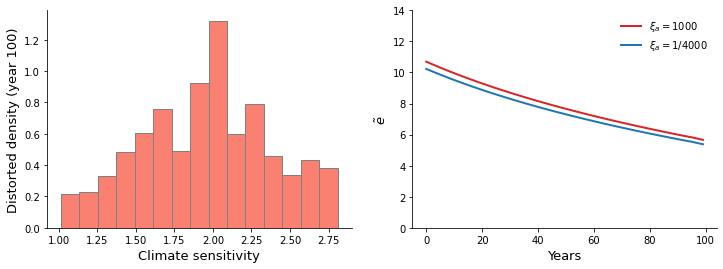

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
ax1.hist(θ_list*1000, weights=πt_rbt[-1], density=True, bins=15, color="salmon", ec="grey")
ax1.set_xlabel('Climate sensitivity', fontsize=13)
ax1.set_ylabel('Distorted density (year 100)', fontsize=13)

ax2.plot(et_rbt_0, color='C3', label=r'$\xi_a = 1000$', linewidth=2.)
ax2.plot(et_rbt, color='C0', label='$\\xi_a = 1/4000$', linewidth=2.)
ax2.set_xlabel('Years', fontsize=13)
ax2.set_ylabel(r'$\tilde{e}$', fontsize=13)
ax2.legend(frameon=False, loc='upper right')
ax2.set_ylim(0, 14)

In [57]:
def simulate_traj_robust(y_grid, ems, π_mat, h_star, θ_list,  dt=1, T=100):
    # initiate
    periods = int(T/dt)
    ems_t = np.zeros(periods)
    y_t = np.zeros(periods)
    h_t = np.zeros(periods)
    π_t = np.zeros((periods, len(θ_list)))
    # interpolate
    get_π = interpolate.interp1d(y_grid, π_mat)
    y0 = θ_list.mean()*290
    y = y0
    for t in range(periods):
        ems_point = np.interp(y, y_grid, ems)
        h_point = np.interp(y, y_grid, h_star)
        π_list = get_π(y)
        ems_t[t] = ems_point
        h_t[t] = h_point
        π_t[t] = π_list
        dy = ems_point*(θ_list@π_list)*dt
        y = dy + y
        y_t[t] = y
    return y_t, ems_t, π_t, h_t

In [58]:
yt_rbt, et_rbt, πt_rbt, ht_rbt = simulate_traj_robust(y_grid, ems_rbt, π_rbt, h_star, θ_list)

Text(0, 0.5, 'Distorted density (year 100)')

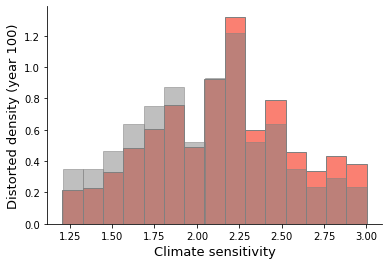

In [59]:
fig, ax1 = plt.subplots(1, 1,figsize=(6,4))
ax1.hist((θ_list + σy*ht_rbt[-1])*1000, weights=πt_rbt[-1], density=True, bins=15, color="salmon", ec="grey")
ax1.set_xlabel('Climate sensitivity', fontsize=13)
ax1.set_ylabel('Distorted density (year 100)', fontsize=13)
ax1.hist((θ_list + σy*ht_rbt[0])*1000,  density=True, bins=15, color="grey", ec="grey", alpha=0.5)
ax1.set_xlabel('Climate sensitivity', fontsize=13)
ax1.set_ylabel('Distorted density (year 100)', fontsize=13)

# Decompose ambiguity among climate models

#1 Partition over temp models

There are 16 temp models

In [60]:
n_temp = 16
n_carb = 9
n_θ = len(θ_list)
θtemp_list = list()
for i in range(n_temp):
    same_temp = θ_list[i*n_carb:i*n_carb+n_carb+1]
    θtemp_list.append(np.average(same_temp))

In [61]:
θtemp_list = np.array(θtemp_list)

In [62]:
ξₐ = 1/4000
γ3 = np.average(γ3_list, weights=[0.5,0.5,0])
args = (δ, η, θtemp_list, σy, γ1, γ2, γ3, ȳ, ξₐ)
ϕ_temp, ems_temp, π_temp = solve_smooth(y_grid, args)

episode: 1,	 ode error: 0.001216767793687331,	 ft error: 0.0011968250720046335
episode: 2,	 ode error: 0.0012544366120497011,	 ft error: 0.0012247870607288486
episode: 3,	 ode error: 0.0012284523737092548,	 ft error: 0.0011967466588596242
episode: 4,	 ode error: 0.0011943606637905783,	 ft error: 0.001162974648637347
episode: 5,	 ode error: 0.0011625444200472944,	 ft error: 0.001133244175313698
episode: 6,	 ode error: 0.0011343087776698646,	 ft error: 0.0011073441610834577
episode: 7,	 ode error: 0.0011091760865694872,	 ft error: 0.0010843996092541647
episode: 8,	 ode error: 0.0010865285630875766,	 ft error: 0.001063154333320354
episode: 9,	 ode error: 0.001065774485569224,	 ft error: 0.0010443157788620507
episode: 10,	 ode error: 0.0010467419871956283,	 ft error: 0.0010268869688394749
episode: 11,	 ode error: 0.0010291282911421469,	 ft error: 0.0010106376485189224
episode: 12,	 ode error: 0.001012715141320228,	 ft error: 0.0009954030066482273
episode: 13,	 ode error: 0.0009973374428857

episode: 151,	 ode error: 0.0003974698515805488,	 ft error: 0.000395763828179412
episode: 152,	 ode error: 0.00039543117936002555,	 ft error: 0.00039374087967839616
episode: 153,	 ode error: 0.00039340274069718723,	 ft error: 0.00039172798109280565
episode: 154,	 ode error: 0.00039138445028446265,	 ft error: 0.00038972505186747147
episode: 155,	 ode error: 0.0003893762257423958,	 ft error: 0.00038773201409918884
episode: 156,	 ode error: 0.0003873779875104423,	 ft error: 0.00038574879244826965
episode: 157,	 ode error: 0.0003853896587398041,	 ft error: 0.000383775314049678
episode: 158,	 ode error: 0.0003834111651884062,	 ft error: 0.00038181150842511496
episode: 159,	 ode error: 0.0003814424351180427,	 ft error: 0.00037985730739623547
episode: 160,	 ode error: 0.00037948339919375846,	 ft error: 0.00037791264499827115
episode: 161,	 ode error: 0.0003775339903855751,	 ft error: 0.0003759774573953989
episode: 162,	 ode error: 0.0003755941438725042,	 ft error: 0.0003740516827971848
episod

episode: 312,	 ode error: 0.0001720774856013396,	 ft error: 0.00017177994882396538
episode: 313,	 ode error: 0.0001711905928064103,	 ft error: 0.00017089712055202064
episode: 314,	 ode error: 0.0001703085064146602,	 ft error: 0.00017001904238832244
episode: 315,	 ode error: 0.0001694312006889552,	 ft error: 0.0001691456897943052
episode: 316,	 ode error: 0.00016855864998054375,	 ft error: 0.00016827703828282045
episode: 317,	 ode error: 0.00016769082873029214,	 ft error: 0.0001674130634190622
episode: 318,	 ode error: 0.00016682771146981279,	 ft error: 0.0001665537408254934
episode: 319,	 ode error: 0.00016596927282258058,	 ft error: 0.00016569904618170725
episode: 320,	 ode error: 0.00016511548750497548,	 ft error: 0.0001648489552295851
episode: 321,	 ode error: 0.00016426633032728954,	 ft error: 0.00016400344377318077
episode: 322,	 ode error: 0.00016342177619471806,	 ft error: 0.0001631624876826295
episode: 323,	 ode error: 0.00016258180010826466,	 ft error: 0.00016232606289542004
e

episode: 479,	 ode error: 7.414095023672187e-05,	 ft error: 7.414841129501268e-05
episode: 480,	 ode error: 7.3776966350592e-05,	 ft error: 7.378510524245578e-05
episode: 481,	 ode error: 7.341485798297194e-05,	 ft error: 7.342366685439417e-05
episode: 482,	 ode error: 7.305461462427652e-05,	 ft error: 7.306408565832534e-05
episode: 483,	 ode error: 7.269622582789341e-05,	 ft error: 7.270635124405808e-05
episode: 484,	 ode error: 7.233968120986633e-05,	 ft error: 7.235045326364302e-05
episode: 485,	 ode error: 7.198497044862877e-05,	 ft error: 7.199638143058629e-05
episode: 486,	 ode error: 7.163208328468294e-05,	 ft error: 7.164412551957193e-05
episode: 487,	 ode error: 7.128100952028828e-05,	 ft error: 7.129367536660067e-05
episode: 488,	 ode error: 7.093173901919609e-05,	 ft error: 7.094502086808785e-05
episode: 489,	 ode error: 7.058426170632778e-05,	 ft error: 7.059815198164991e-05
episode: 490,	 ode error: 7.02385675674875e-05,	 ft error: 7.025305872418453e-05
episode: 491,	 ode 

episode: 647,	 ode error: 3.28465827657559e-05,	 ft error: 3.28688282020632e-05
episode: 648,	 ode error: 3.268963085275797e-05,	 ft error: 3.2711322731244594e-05
episode: 649,	 ode error: 3.253344504987744e-05,	 ft error: 3.255457334860416e-05
episode: 650,	 ode error: 3.237802148093282e-05,	 ft error: 3.23985760790115e-05
episode: 651,	 ode error: 3.2223356290998284e-05,	 ft error: 3.224332697037332e-05
episode: 652,	 ode error: 3.206944564631967e-05,	 ft error: 3.20888220865558e-05
episode: 653,	 ode error: 3.191628573417742e-05,	 ft error: 3.1935057511085316e-05
episode: 654,	 ode error: 3.176387276277587e-05,	 ft error: 3.178202934638515e-05
episode: 655,	 ode error: 3.161220296111133e-05,	 ft error: 3.1629733713821793e-05
episode: 656,	 ode error: 3.146127257886496e-05,	 ft error: 3.1478166751299406e-05
episode: 657,	 ode error: 3.1311077886289444e-05,	 ft error: 3.132732461647488e-05
episode: 658,	 ode error: 3.116161517408814e-05,	 ft error: 3.117720348543944e-05
episode: 659,	

episode: 814,	 ode error: 1.4875345590876794e-05,	 ft error: 1.4232119542184618e-05
episode: 815,	 ode error: 1.4806608320718146e-05,	 ft error: 1.4135223125715432e-05
episode: 816,	 ode error: 1.473828229773893e-05,	 ft error: 1.4035794359060216e-05
episode: 817,	 ode error: 1.4670375626455226e-05,	 ft error: 1.393320234757689e-05
episode: 818,	 ode error: 1.4602898850328539e-05,	 ft error: 1.3826591458524867e-05
episode: 819,	 ode error: 1.4535865939206715e-05,	 ft error: 1.3714764253135633e-05
episode: 820,	 ode error: 1.446929586701787e-05,	 ft error: 1.3595979383926315e-05
episode: 821,	 ode error: 1.4403215273570634e-05,	 ft error: 1.3467581637301626e-05
episode: 822,	 ode error: 1.433766327776562e-05,	 ft error: 1.3325270486058693e-05
episode: 823,	 ode error: 1.4269349677879881e-05,	 ft error: 1.4278612423673787e-05
episode: 824,	 ode error: 1.4203703022508223e-05,	 ft error: 1.3418412919778227e-05
episode: 825,	 ode error: 1.4138810732819873e-05,	 ft error: 1.3241906592862767e

episode: 973,	 ode error: 7.017087929892863e-06,	 ft error: 7.014528936681123e-06
episode: 974,	 ode error: 6.984163279501708e-06,	 ft error: 6.981244709015437e-06
episode: 975,	 ode error: 6.951397017169298e-06,	 ft error: 6.948120453107813e-06
episode: 976,	 ode error: 6.91878846037562e-06,	 ft error: 6.915155476896103e-06
episode: 977,	 ode error: 6.886336930495766e-06,	 ft error: 6.882349185370155e-06
episode: 978,	 ode error: 6.854041753919372e-06,	 ft error: 6.8497006220265746e-06
episode: 979,	 ode error: 6.818520557993427e-06,	 ft error: 7.94780824563135e-06
episode: 980,	 ode error: 6.787330602703919e-06,	 ft error: 6.781530257765622e-06
episode: 981,	 ode error: 6.755407175589034e-06,	 ft error: 6.749478878899836e-06
episode: 982,	 ode error: 6.723665977783483e-06,	 ft error: 6.717547245636372e-06
episode: 983,	 ode error: 6.692098178332309e-06,	 ft error: 6.685745158283944e-06
episode: 984,	 ode error: 6.657330651459203e-06,	 ft error: 7.77968831968771e-06
episode: 985,	 ode

episode: 1137,	 ode error: 3.8661330799620824e-06,	 ft error: 3.885573669805872e-06
episode: 1138,	 ode error: 3.8578581608592825e-06,	 ft error: 3.863491914076386e-06
episode: 1139,	 ode error: 3.849671072287146e-06,	 ft error: 3.841596789751675e-06
episode: 1140,	 ode error: 3.841567850449909e-06,	 ft error: 3.819884806244289e-06
episode: 1141,	 ode error: 3.833544826799197e-06,	 ft error: 3.7983525442060926e-06
episode: 1142,	 ode error: 3.825598605283992e-06,	 ft error: 3.7769966422518397e-06
episode: 1143,	 ode error: 3.8177260417355564e-06,	 ft error: 3.755813832601966e-06
episode: 1144,	 ode error: 3.8099242239856093e-06,	 ft error: 3.7348009189706417e-06
episode: 1145,	 ode error: 3.802190454100748e-06,	 ft error: 3.713954809039799e-06
episode: 1146,	 ode error: 3.794522231073596e-06,	 ft error: 3.6932725193626155e-06
episode: 1147,	 ode error: 3.7869172348127685e-06,	 ft error: 3.6727511521876073e-06
episode: 1148,	 ode error: 3.7793733119158095e-06,	 ft error: 3.6523879236074

episode: 1303,	 ode error: 3.0207785367288e-06,	 ft error: 1.740391617927976e-06
episode: 1304,	 ode error: 3.0179012213581895e-06,	 ft error: 1.7359496237712158e-06
episode: 1305,	 ode error: 3.0150425107288077e-06,	 ft error: 1.7315143160713995e-06
episode: 1306,	 ode error: 3.0122022379146652e-06,	 ft error: 1.7270856461637507e-06
episode: 1307,	 ode error: 3.0093802368719885e-06,	 ft error: 1.72266356858695e-06
episode: 1308,	 ode error: 3.0065763425209677e-06,	 ft error: 1.7182480362721668e-06
episode: 1309,	 ode error: 3.003790390655823e-06,	 ft error: 1.713839005030212e-06
episode: 1310,	 ode error: 3.0010222180353887e-06,	 ft error: 1.7094364329617306e-06
episode: 1311,	 ode error: 2.9982716624393302e-06,	 ft error: 1.7050402774850446e-06
episode: 1312,	 ode error: 2.9955385625848223e-06,	 ft error: 1.7006504970014844e-06
episode: 1313,	 ode error: 2.9928227581627075e-06,	 ft error: 1.6962670538559859e-06
episode: 1314,	 ode error: 2.9901240899477596e-06,	 ft error: 1.691889909

episode: 1476,	 ode error: 2.3122080395599994e-06,	 ft error: 9.879688847117911e-07
episode: 1477,	 ode error: 2.3145957695545178e-06,	 ft error: 9.836589157328583e-07
episode: 1478,	 ode error: 2.3169703387716637e-06,	 ft error: 9.793800642930266e-07
episode: 1479,	 ode error: 2.319331817835445e-06,	 ft error: 9.75132114037584e-07
episode: 1480,	 ode error: 2.3216802770020003e-06,	 ft error: 9.709148474322065e-07
episode: 1481,	 ode error: 2.3240157861580796e-06,	 ft error: 9.667280456241805e-07
episode: 1482,	 ode error: 2.32633841482316e-06,	 ft error: 9.625714887662173e-07
episode: 1483,	 ode error: 2.32864823214809e-06,	 ft error: 9.584449557620278e-07
episode: 1484,	 ode error: 2.330945306919642e-06,	 ft error: 9.543482247057848e-07
episode: 1485,	 ode error: 2.333229707554877e-06,	 ft error: 9.5028107246579e-07
episode: 1486,	 ode error: 2.3355015021071595e-06,	 ft error: 9.462432751239369e-07
episode: 1487,	 ode error: 2.3377607582623634e-06,	 ft error: 9.422346078138041e-07
ep

episode: 1650,	 ode error: 2.499570900538965e-06,	 ft error: 5.532554644277488e-07
episode: 1651,	 ode error: 2.5008418042043123e-06,	 ft error: 5.505221393568387e-07
episode: 1652,	 ode error: 2.502105750871043e-06,	 ft error: 5.477887742022514e-07
episode: 1653,	 ode error: 2.5033627658161924e-06,	 ft error: 5.450555252972666e-07
episode: 1654,	 ode error: 2.504612871848935e-06,	 ft error: 5.423225538786491e-07
episode: 1655,	 ode error: 2.505856089845854e-06,	 ft error: 5.395900249764256e-07
episode: 1656,	 ode error: 2.5070924392005083e-06,	 ft error: 5.368581073444956e-07
episode: 1657,	 ode error: 2.5083219382163982e-06,	 ft error: 5.341269726742242e-07
episode: 1658,	 ode error: 2.5095446044293016e-06,	 ft error: 5.313967953400149e-07
episode: 1659,	 ode error: 2.5107604548754497e-06,	 ft error: 5.286677522836625e-07
episode: 1660,	 ode error: 2.511969506326095e-06,	 ft error: 5.259400225286297e-07
episode: 1661,	 ode error: 2.5131717754678677e-06,	 ft error: 5.232137872956955e-

episode: 1827,	 ode error: 2.638906649595797e-06,	 ft error: 2.312055984859951e-07
episode: 1828,	 ode error: 2.639339172407851e-06,	 ft error: 2.3050406433115328e-07
episode: 1829,	 ode error: 2.6397689610781617e-06,	 ft error: 2.2980468022728204e-07
episode: 1830,	 ode error: 2.6401960302656303e-06,	 ft error: 2.2910744413897252e-07
episode: 1831,	 ode error: 2.6406203945054506e-06,	 ft error: 2.2841235399612136e-07
episode: 1832,	 ode error: 2.6410420682123617e-06,	 ft error: 2.2771940761297701e-07
episode: 1833,	 ode error: 2.641461065683141e-06,	 ft error: 2.2702860278065823e-07
episode: 1834,	 ode error: 2.641877401093841e-06,	 ft error: 2.2633993716307071e-07
episode: 1835,	 ode error: 2.6422910885038524e-06,	 ft error: 2.256534083778609e-07
episode: 1836,	 ode error: 2.6427021418610032e-06,	 ft error: 2.2496901400798075e-07
episode: 1837,	 ode error: 2.643110574996081e-06,	 ft error: 2.2428675138195614e-07
episode: 1838,	 ode error: 2.6435164016311275e-06,	 ft error: 2.23606617

episode: 2004,	 ode error: 2.68331937195663e-06,	 ft error: 1.3598235794332059e-07
episode: 2005,	 ode error: 2.6834371785733595e-06,	 ft error: 1.3557659204789982e-07
episode: 2006,	 ode error: 2.68355397460004e-06,	 ft error: 1.35171990637654e-07
episode: 2007,	 ode error: 2.6836697664892463e-06,	 ft error: 1.3476855061321052e-07
episode: 2008,	 ode error: 2.6837845606561485e-06,	 ft error: 1.3436626900240983e-07
episode: 2009,	 ode error: 2.683898363474717e-06,	 ft error: 1.3396514278683308e-07
episode: 2010,	 ode error: 2.6840111812772346e-06,	 ft error: 1.335651689827559e-07
episode: 2011,	 ode error: 2.6841230203574406e-06,	 ft error: 1.3316634464114835e-07
episode: 2012,	 ode error: 2.6842338869669533e-06,	 ft error: 1.3276866677828608e-07
episode: 2013,	 ode error: 2.684343787319552e-06,	 ft error: 1.3237213251452812e-07
episode: 2014,	 ode error: 2.6844527275882504e-06,	 ft error: 1.3197673892397418e-07
episode: 2015,	 ode error: 2.6845607139054585e-06,	 ft error: 1.3158248309

episode: 2181,	 ode error: 2.692961684136561e-06,	 ft error: 7.997623234963966e-08
episode: 2182,	 ode error: 2.6929721768295385e-06,	 ft error: 7.973663807929003e-08
episode: 2183,	 ode error: 2.6929823493230284e-06,	 ft error: 7.949775265164716e-08
episode: 2184,	 ode error: 2.692992203829996e-06,	 ft error: 7.925957400817252e-08
episode: 2185,	 ode error: 2.693001742548281e-06,	 ft error: 7.902210010189241e-08
episode: 2186,	 ode error: 2.6930109676656416e-06,	 ft error: 7.878532883957383e-08
episode: 2187,	 ode error: 2.6930198813553607e-06,	 ft error: 7.854925817424308e-08
episode: 2188,	 ode error: 2.6930284857803674e-06,	 ft error: 7.831388604736164e-08
episode: 2189,	 ode error: 2.6930367830905804e-06,	 ft error: 7.807921042352062e-08
episode: 2190,	 ode error: 2.693044775424155e-06,	 ft error: 7.784522926731116e-08
episode: 2191,	 ode error: 2.693052464908133e-06,	 ft error: 7.761194056645401e-08
episode: 2192,	 ode error: 2.693059853655841e-06,	 ft error: 7.737934227397547e-0

episode: 2358,	 ode error: 2.6914305571032948e-06,	 ft error: 4.7018591161721954e-08
episode: 2359,	 ode error: 2.6914097779614328e-06,	 ft error: 4.6877668564056694e-08
episode: 2360,	 ode error: 2.691388925509181e-06,	 ft error: 4.67371627626186e-08
episode: 2361,	 ode error: 2.69136800053367e-06,	 ft error: 4.659707256623088e-08
episode: 2362,	 ode error: 2.69134700381726e-06,	 ft error: 4.64573967143278e-08
episode: 2363,	 ode error: 2.6913259361380833e-06,	 ft error: 4.631813405042706e-08
episode: 2364,	 ode error: 2.69130479826717e-06,	 ft error: 4.617928336022222e-08
episode: 2365,	 ode error: 2.6912835909745207e-06,	 ft error: 4.604084342940684e-08
episode: 2366,	 ode error: 2.6912623150231966e-06,	 ft error: 4.5902813078368965e-08
episode: 2367,	 ode error: 2.6912409711709467e-06,	 ft error: 4.57651911159318e-08
episode: 2368,	 ode error: 2.691219560171942e-06,	 ft error: 4.562797633935375e-08
episode: 2369,	 ode error: 2.6911980827763423e-06,	 ft error: 4.549116758058765e-08


episode: 2535,	 ode error: 2.6871655609669778e-06,	 ft error: 2.7639491332239384e-08
episode: 2536,	 ode error: 2.6871405368292136e-06,	 ft error: 2.7556592424593518e-08
episode: 2537,	 ode error: 2.6871155224527385e-06,	 ft error: 2.747393891671298e-08
episode: 2538,	 ode error: 2.687090518075318e-06,	 ft error: 2.7391530114708372e-08
episode: 2539,	 ode error: 2.687065523932495e-06,	 ft error: 2.7309365289995835e-08
episode: 2540,	 ode error: 2.6870405402571558e-06,	 ft error: 2.722744373133875e-08
episode: 2541,	 ode error: 2.687015567278772e-06,	 ft error: 2.714576474484772e-08
episode: 2542,	 ode error: 2.6869906052278455e-06,	 ft error: 2.7064327590374065e-08
episode: 2543,	 ode error: 2.6869656543321123e-06,	 ft error: 2.6983131614505274e-08
episode: 2544,	 ode error: 2.686940714815569e-06,	 ft error: 2.690217605974543e-08
episode: 2545,	 ode error: 2.6869157869033496e-06,	 ft error: 2.6821464534319366e-08
episode: 2546,	 ode error: 2.686890870817445e-06,	 ft error: 2.6741152191

episode: 2712,	 ode error: 2.6830434575784794e-06,	 ft error: 1.6246668524400043e-08
episode: 2713,	 ode error: 2.683022533714059e-06,	 ft error: 1.6197992397613364e-08
episode: 2714,	 ode error: 2.6830016406799028e-06,	 ft error: 1.614946017770384e-08
episode: 2715,	 ode error: 2.682980778512278e-06,	 ft error: 1.6101071442555424e-08
episode: 2716,	 ode error: 2.682959947246529e-06,	 ft error: 1.6052825816311365e-08
episode: 2717,	 ode error: 2.6829391469154534e-06,	 ft error: 1.6004722830596323e-08
episode: 2718,	 ode error: 2.6829183775527697e-06,	 ft error: 1.5956762097988724e-08
episode: 2719,	 ode error: 2.6828976391917087e-06,	 ft error: 1.59089431848077e-08
episode: 2720,	 ode error: 2.6828769318640376e-06,	 ft error: 1.5861265697849257e-08
episode: 2721,	 ode error: 2.6828562556020113e-06,	 ft error: 1.5813729220779765e-08
episode: 2722,	 ode error: 2.6828356104365296e-06,	 ft error: 1.5766333354612826e-08
episode: 2723,	 ode error: 2.6828149963972997e-06,	 ft error: 1.5719077

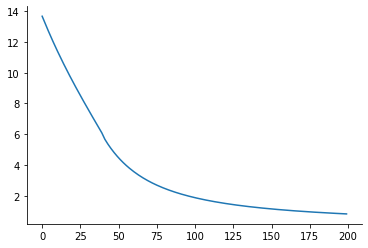

In [63]:
plt.plot(ems_temp)

In [64]:
yt_temp, et_temp, πt_temp = simulate_traj(y_grid, ems_temp, π_temp, θtemp_list)

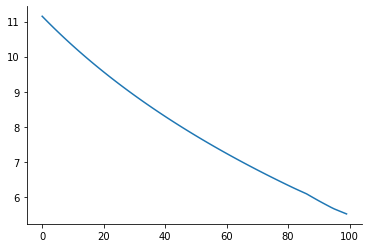

In [65]:
plt.plot(et_temp)

#2 Partition over carbon models

There are 9 carbon models.

In [66]:
θcarb_list = list()
for i in range(n_carb):
    idx_carb = np.arange(i, n_θ+i, n_carb)
    same_carb = θ_list[idx_carb]
    θcarb_list.append(np.average(same_carb))

In [67]:
θcarb_list = np.array(θcarb_list)

In [68]:
ξₐ = 1/4000
γ3 = np.average(γ3_list, weights=[0.5,0.5,0])
args = (δ, η, θcarb_list, σy, γ1, γ2, γ3, ȳ, ξₐ)
ϕ_carb, ems_carb, π_carb = solve_smooth(y_grid, args)

episode: 1,	 ode error: 0.0012172938117424878,	 ft error: 0.0011973882957276429
episode: 2,	 ode error: 0.0012564312846856792,	 ft error: 0.0012275243896106881
episode: 3,	 ode error: 0.0012315623348568838,	 ft error: 0.0012007522924587693
episode: 4,	 ode error: 0.0011983769310525308,	 ft error: 0.0011677007207976423
episode: 5,	 ode error: 0.0011672614660044683,	 ft error: 0.0011385930664411354
episode: 6,	 ode error: 0.0011395505313141201,	 ft error: 0.001113126828122733
episode: 7,	 ode error: 0.0011148203535643014,	 ft error: 0.0010904985450385825
episode: 8,	 ode error: 0.0010924894797554405,	 ft error: 0.0010700342882169753
episode: 9,	 ode error: 0.0010720990601931363,	 ft error: 0.0010505512516076835
episode: 10,	 ode error: 0.0010531887909251143,	 ft error: 0.0010333433001102725
episode: 11,	 ode error: 0.0010357116536272026,	 ft error: 0.001017274011156982
episode: 12,	 ode error: 0.001019428564300845,	 ft error: 0.0010021822285776827
episode: 13,	 ode error: 0.0010041663663

episode: 159,	 ode error: 0.00038635855702551876,	 ft error: 0.0003847005281716262
episode: 160,	 ode error: 0.0003843845995921281,	 ft error: 0.0003827428680908014
episode: 161,	 ode error: 0.0003824203222354865,	 ft error: 0.0003807946519234403
episode: 162,	 ode error: 0.00038046566158359983,	 ft error: 0.00037885582457649475
episode: 163,	 ode error: 0.00037852055620559994,	 ft error: 0.00037692633232463046
episode: 164,	 ode error: 0.0003765849465317279,	 ft error: 0.00037500612278067863
episode: 165,	 ode error: 0.00037465877477508094,	 ft error: 0.00037309514486260725
episode: 166,	 ode error: 0.0003727419848552208,	 ft error: 0.0003711933487581786
episode: 167,	 ode error: 0.0003708345223236468,	 ft error: 0.00036930068588710935
episode: 168,	 ode error: 0.000368936334291184,	 ft error: 0.00036741710886207396
episode: 169,	 ode error: 0.0003670473693573108,	 ft error: 0.00036554257144785773
episode: 170,	 ode error: 0.0003651675775414651,	 ft error: 0.00036367702852035944
episo

episode: 328,	 ode error: 0.0001614625160301557,	 ft error: 0.0001611490313194186
episode: 329,	 ode error: 0.00016064103222372238,	 ft error: 0.0001603321652850903
episode: 330,	 ode error: 0.0001598239755738857,	 ft error: 0.00015951965045002403
episode: 331,	 ode error: 0.0001590113219806452,	 ft error: 0.00015871146471449032
episode: 332,	 ode error: 0.0001582030474330243,	 ft error: 0.0001579075859932851
episode: 333,	 ode error: 0.00015739912801017583,	 ft error: 0.0001571079922199394
episode: 334,	 ode error: 0.0001565995398824957,	 ft error: 0.00015631266135074373
episode: 335,	 ode error: 0.00015580425931267447,	 ft error: 0.00015552157137085448
episode: 336,	 ode error: 0.0001550132626567535,	 ft error: 0.0001547347002941087
episode: 337,	 ode error: 0.00015422652636499807,	 ft error: 0.0001539520261726694
episode: 338,	 ode error: 0.00015344402698288997,	 ft error: 0.00015317352709489734
episode: 339,	 ode error: 0.0001526657411519564,	 ft error: 0.0001523991811924752
episod

episode: 505,	 ode error: 6.70663693134062e-05,	 ft error: 6.708268867676911e-05
episode: 506,	 ode error: 6.674261016497546e-05,	 ft error: 6.675955058497533e-05
episode: 507,	 ode error: 6.642049087080546e-05,	 ft error: 6.643804491434739e-05
episode: 508,	 ode error: 6.610000241234943e-05,	 ft error: 6.611816267691288e-05
episode: 509,	 ode error: 6.578113582319015e-05,	 ft error: 6.579989493544584e-05
episode: 510,	 ode error: 6.54638821887657e-05,	 ft error: 6.54832328038831e-05
episode: 511,	 ode error: 6.514823264613056e-05,	 ft error: 6.516816744656095e-05
episode: 512,	 ode error: 6.48341783836884e-05,	 ft error: 6.485469007865471e-05
episode: 513,	 ode error: 6.452171064096502e-05,	 ft error: 6.45427919655541e-05
episode: 514,	 ode error: 6.42108207083589e-05,	 ft error: 6.423246442265515e-05
episode: 515,	 ode error: 6.390149992688114e-05,	 ft error: 6.392369881579966e-05
episode: 516,	 ode error: 6.359373968796141e-05,	 ft error: 6.361648655886973e-05
episode: 517,	 ode err

episode: 682,	 ode error: 2.885744182400021e-05,	 ft error: 2.8867074670322717e-05
episode: 683,	 ode error: 2.8721850389587414e-05,	 ft error: 2.873056458509623e-05
episode: 684,	 ode error: 2.8586910116919695e-05,	 ft error: 2.85946889072806e-05
episode: 685,	 ode error: 2.8452617812860974e-05,	 ft error: 2.8459444171569093e-05
episode: 686,	 ode error: 2.8318970301817134e-05,	 ft error: 2.832482692313269e-05
episode: 687,	 ode error: 2.8185964425701208e-05,	 ft error: 2.819083372099703e-05
episode: 688,	 ode error: 2.8053597043823232e-05,	 ft error: 2.8057461127680337e-05
episode: 689,	 ode error: 2.7921865032828766e-05,	 ft error: 2.7924705719324188e-05
episode: 690,	 ode error: 2.7790765286605547e-05,	 ft error: 2.779256408028119e-05
episode: 691,	 ode error: 2.7660294716233937e-05,	 ft error: 2.7661032797887675e-05
episode: 692,	 ode error: 2.7530450249850752e-05,	 ft error: 2.7530108478723836e-05
episode: 693,	 ode error: 2.7401228832648716e-05,	 ft error: 2.7399787724026924e-05

episode: 856,	 ode error: 1.282968372414285e-05,	 ft error: 1.2845246799541207e-05
episode: 857,	 ode error: 1.2769724692697493e-05,	 ft error: 1.2785384108741454e-05
episode: 858,	 ode error: 1.2710044177996309e-05,	 ft error: 1.2725799391002934e-05
episode: 859,	 ode error: 1.2650640960389374e-05,	 ft error: 1.2666491467592616e-05
episode: 860,	 ode error: 1.2591513821645878e-05,	 ft error: 1.2607459155105269e-05
episode: 861,	 ode error: 1.2532661544990007e-05,	 ft error: 1.2548701266735612e-05
episode: 862,	 ode error: 1.2474082915211755e-05,	 ft error: 1.2490216612764024e-05
episode: 863,	 ode error: 1.2415776718809816e-05,	 ft error: 1.2432004001458608e-05
episode: 864,	 ode error: 1.2357741744171567e-05,	 ft error: 1.2374062238589464e-05
episode: 865,	 ode error: 1.2299976782018129e-05,	 ft error: 1.2316390050661393e-05
episode: 866,	 ode error: 1.224248062460249e-05,	 ft error: 1.2258986485519374e-05
episode: 867,	 ode error: 1.2185252067386013e-05,	 ft error: 1.220185010331979

episode: 1028,	 ode error: 5.613763984150047e-06,	 ft error: 6.2959905136374585e-06
episode: 1029,	 ode error: 5.586502567774638e-06,	 ft error: 6.266843217556106e-06
episode: 1030,	 ode error: 5.559378846191538e-06,	 ft error: 6.237868583960915e-06
episode: 1031,	 ode error: 5.539904904329571e-06,	 ft error: 6.2090634500577835e-06
episode: 1032,	 ode error: 5.5242183927908e-06,	 ft error: 6.180424760212263e-06
episode: 1033,	 ode error: 5.508601357158123e-06,	 ft error: 6.1519495219107085e-06
episode: 1034,	 ode error: 5.493053831826607e-06,	 ft error: 6.123634836638359e-06
episode: 1035,	 ode error: 5.47757586703265e-06,	 ft error: 6.095477869787666e-06
episode: 1036,	 ode error: 5.462167527384566e-06,	 ft error: 6.067475866640878e-06
episode: 1037,	 ode error: 5.446828890015153e-06,	 ft error: 6.0396261334037344e-06
episode: 1038,	 ode error: 5.431560043322504e-06,	 ft error: 6.011926046087246e-06
episode: 1039,	 ode error: 5.4163610855364206e-06,	 ft error: 5.9843730253889005e-06
e

episode: 1204,	 ode error: 3.788123373692513e-06,	 ft error: 2.6943085791134953e-06
episode: 1205,	 ode error: 3.7822195190188737e-06,	 ft error: 2.6801453328432574e-06
episode: 1206,	 ode error: 3.776346802271456e-06,	 ft error: 2.666035995556778e-06
episode: 1207,	 ode error: 3.7705049892453523e-06,	 ft error: 2.6519804651366683e-06
episode: 1208,	 ode error: 3.7646938470618503e-06,	 ft error: 2.637978650336474e-06
episode: 1209,	 ode error: 3.7589131440746507e-06,	 ft error: 2.624030462222704e-06
episode: 1210,	 ode error: 3.7531626499887494e-06,	 ft error: 2.6101358209980794e-06
episode: 1211,	 ode error: 3.7474421358061737e-06,	 ft error: 2.5962946492245438e-06
episode: 1212,	 ode error: 3.7417513739488218e-06,	 ft error: 2.5825068755933973e-06
episode: 1213,	 ode error: 3.7360901382686e-06,	 ft error: 2.5687724349715557e-06
episode: 1214,	 ode error: 3.730458204063633e-06,	 ft error: 2.5550912661579756e-06
episode: 1215,	 ode error: 3.7248553481407116e-06,	 ft error: 2.5414633126

episode: 1380,	 ode error: 3.085100624361655e-06,	 ft error: 1.2952401362680463e-06
episode: 1381,	 ode error: 3.0825301809019024e-06,	 ft error: 1.2913403655533582e-06
episode: 1382,	 ode error: 3.079972325042762e-06,	 ft error: 1.2874520545838597e-06
episode: 1383,	 ode error: 3.077427012901097e-06,	 ft error: 1.2835751884293645e-06
episode: 1384,	 ode error: 3.0748942006261337e-06,	 ft error: 1.2797097505868698e-06
episode: 1385,	 ode error: 3.072373844363141e-06,	 ft error: 1.275855724669021e-06
episode: 1386,	 ode error: 3.06986590027094e-06,	 ft error: 1.2720130943694175e-06
episode: 1387,	 ode error: 3.067370324545053e-06,	 ft error: 1.2681818409646106e-06
episode: 1388,	 ode error: 3.0648870733440844e-06,	 ft error: 1.2643619481597645e-06
episode: 1389,	 ode error: 3.062416102901015e-06,	 ft error: 1.2605533969191804e-06
episode: 1390,	 ode error: 3.059957369420908e-06,	 ft error: 1.256756167813955e-06
episode: 1391,	 ode error: 3.0575108291052474e-06,	 ft error: 1.252970242814

episode: 1549,	 ode error: 2.7962231182851374e-06,	 ft error: 7.80399091228808e-07
episode: 1550,	 ode error: 2.795201465488975e-06,	 ft error: 7.780850509730985e-07
episode: 1551,	 ode error: 2.7941859753626334e-06,	 ft error: 7.757780715854831e-07
episode: 1552,	 ode error: 2.7931766186537962e-06,	 ft error: 7.734781291499071e-07
episode: 1553,	 ode error: 2.7921733661871793e-06,	 ft error: 7.711852000856964e-07
episode: 1554,	 ode error: 2.7911761888751562e-06,	 ft error: 7.688992610550376e-07
episode: 1555,	 ode error: 2.7901850577292508e-06,	 ft error: 7.666202889629788e-07
episode: 1556,	 ode error: 2.7891999438620346e-06,	 ft error: 7.643482603907533e-07
episode: 1557,	 ode error: 2.7882208184635995e-06,	 ft error: 7.620831517692513e-07
episode: 1558,	 ode error: 2.7872476528155985e-06,	 ft error: 7.598249407552345e-07
episode: 1559,	 ode error: 2.786280418320302e-06,	 ft error: 7.575736036639451e-07
episode: 1560,	 ode error: 2.785319086445466e-06,	 ft error: 7.553291173310421e

episode: 1722,	 ode error: 2.6896224487882596e-06,	 ft error: 4.678732396766935e-07
episode: 1723,	 ode error: 2.689308613372109e-06,	 ft error: 4.664911320192052e-07
episode: 1724,	 ode error: 2.688997227454407e-06,	 ft error: 4.651130254204605e-07
episode: 1725,	 ode error: 2.6886882771755814e-06,	 ft error: 4.63738908465979e-07
episode: 1726,	 ode error: 2.6883817487627403e-06,	 ft error: 4.6236876929025194e-07
episode: 1727,	 ode error: 2.6880776285045753e-06,	 ft error: 4.610025964672341e-07
episode: 1728,	 ode error: 2.6877759027711472e-06,	 ft error: 4.596403786402692e-07
episode: 1729,	 ode error: 2.687476558010688e-06,	 ft error: 4.582821043139229e-07
episode: 1730,	 ode error: 2.6871795807432573e-06,	 ft error: 4.5692776223562237e-07
episode: 1731,	 ode error: 2.686884957568713e-06,	 ft error: 4.555773405051644e-07
episode: 1732,	 ode error: 2.686592675132937e-06,	 ft error: 4.542308279971893e-07
episode: 1733,	 ode error: 2.6863027201687643e-06,	 ft error: 4.5288821397954093

episode: 1896,	 ode error: 2.662253116127026e-06,	 ft error: 2.7917314875345694e-07
episode: 1897,	 ode error: 2.6622089701835603e-06,	 ft error: 2.7834409627863765e-07
episode: 1898,	 ode error: 2.662165704399376e-06,	 ft error: 2.7751747211599936e-07
episode: 1899,	 ode error: 2.662123313307166e-06,	 ft error: 2.766932684245919e-07
episode: 1900,	 ode error: 2.6620817914275357e-06,	 ft error: 2.758714784621234e-07
episode: 1901,	 ode error: 2.662041133316272e-06,	 ft error: 2.750520959142004e-07
episode: 1902,	 ode error: 2.662001333574753e-06,	 ft error: 2.7423511293987274e-07
episode: 1903,	 ode error: 2.6619623867924305e-06,	 ft error: 2.734205239417661e-07
episode: 1904,	 ode error: 2.6619242876365474e-06,	 ft error: 2.72608321356486e-07
episode: 1905,	 ode error: 2.661887030768926e-06,	 ft error: 2.717984991818893e-07
episode: 1906,	 ode error: 2.6618506109105317e-06,	 ft error: 2.709910498777113e-07
episode: 1907,	 ode error: 2.661815022773331e-06,	 ft error: 2.7018596719894744

episode: 2070,	 ode error: 2.663965002108737e-06,	 ft error: 1.6625697821931462e-07
episode: 2071,	 ode error: 2.6640112326858294e-06,	 ft error: 1.6576194459873758e-07
episode: 2072,	 ode error: 2.6640577123128884e-06,	 ft error: 1.6526837177723483e-07
episode: 2073,	 ode error: 2.664104438775865e-06,	 ft error: 1.6477625579963684e-07
episode: 2074,	 ode error: 2.6641514098796836e-06,	 ft error: 1.642855925488666e-07
episode: 2075,	 ode error: 2.6641986234486213e-06,	 ft error: 1.6379637708674455e-07
episode: 2076,	 ode error: 2.664246077289283e-06,	 ft error: 1.6330860602477756e-07
episode: 2077,	 ode error: 2.6642937692480636e-06,	 ft error: 1.628222737655912e-07
episode: 2078,	 ode error: 2.6643416971381274e-06,	 ft error: 1.6233737774179469e-07
episode: 2079,	 ode error: 2.664389858850376e-06,	 ft error: 1.618539132233754e-07
episode: 2080,	 ode error: 2.664438252263947e-06,	 ft error: 1.6137187588508944e-07
episode: 2081,	 ode error: 2.6644868752581955e-06,	 ft error: 1.608912610

episode: 2244,	 ode error: 2.6742307342376872e-06,	 ft error: 9.895191802518818e-08
episode: 2245,	 ode error: 2.674295615874426e-06,	 ft error: 9.865708386809965e-08
episode: 2246,	 ode error: 2.674360502816816e-06,	 ft error: 9.836311930475998e-08
episode: 2247,	 ode error: 2.674425394264175e-06,	 ft error: 9.807002182560254e-08
episode: 2248,	 ode error: 2.674490289435172e-06,	 ft error: 9.77777899156355e-08
episode: 2249,	 ode error: 2.6745551875858816e-06,	 ft error: 9.748642022106013e-08
episode: 2250,	 ode error: 2.6746200879508033e-06,	 ft error: 9.719591064864345e-08
episode: 2251,	 ode error: 2.6746849897813494e-06,	 ft error: 9.690625838813342e-08
episode: 2252,	 ode error: 2.6747498923211264e-06,	 ft error: 9.661746089526894e-08
episode: 2253,	 ode error: 2.6748147948209506e-06,	 ft error: 9.632951585708538e-08
episode: 2254,	 ode error: 2.6748796965464375e-06,	 ft error: 9.604242097218293e-08
episode: 2255,	 ode error: 2.6749445967677024e-06,	 ft error: 9.575617318744827e-

episode: 2417,	 ode error: 2.6850361666809703e-06,	 ft error: 5.903152190446977e-08
episode: 2418,	 ode error: 2.685094034798061e-06,	 ft error: 5.885546862371971e-08
episode: 2419,	 ode error: 2.6851518330890623e-06,	 ft error: 5.867993604913302e-08
episode: 2420,	 ode error: 2.6852095613938377e-06,	 ft error: 5.85049216827079e-08
episode: 2421,	 ode error: 2.6852672195195075e-06,	 ft error: 5.8330424552999194e-08
episode: 2422,	 ode error: 2.6853248072934667e-06,	 ft error: 5.815644323753366e-08
episode: 2423,	 ode error: 2.685382324549182e-06,	 ft error: 5.7982975411781844e-08
episode: 2424,	 ode error: 2.685439771088732e-06,	 ft error: 5.781002071723422e-08
episode: 2425,	 ode error: 2.685497146764015e-06,	 ft error: 5.7637576887185446e-08
episode: 2426,	 ode error: 2.6855544513963e-06,	 ft error: 5.7465642545421566e-08
episode: 2427,	 ode error: 2.685611684813741e-06,	 ft error: 5.729421633885827e-08
episode: 2428,	 ode error: 2.6856688468566894e-06,	 ft error: 5.7123297319180054e

episode: 2590,	 ode error: 2.693915624016937e-06,	 ft error: 3.5196124197981834e-08
episode: 2591,	 ode error: 2.693960077569321e-06,	 ft error: 3.5091071807584015e-08
episode: 2592,	 ode error: 2.694004451942421e-06,	 ft error: 3.4986330233373795e-08
episode: 2593,	 ode error: 2.694048747173478e-06,	 ft error: 3.4881898446081916e-08
episode: 2594,	 ode error: 2.6940929632965913e-06,	 ft error: 3.477777537017983e-08
episode: 2595,	 ode error: 2.694137100337998e-06,	 ft error: 3.467396054307459e-08
episode: 2596,	 ode error: 2.694181158344861e-06,	 ft error: 3.4570453085839656e-08
episode: 2597,	 ode error: 2.694225137363476e-06,	 ft error: 3.44672516453907e-08
episode: 2598,	 ode error: 2.6942690374219774e-06,	 ft error: 3.4364355446884584e-08
episode: 2599,	 ode error: 2.694312858556524e-06,	 ft error: 3.4261763807996726e-08
episode: 2600,	 ode error: 2.6943566008076104e-06,	 ft error: 3.415947554911518e-08
episode: 2601,	 ode error: 2.6944002642115034e-06,	 ft error: 3.40574900688691

episode: 2763,	 ode error: 2.700476134495449e-06,	 ft error: 2.097558849991262e-08
episode: 2764,	 ode error: 2.7005078177498847e-06,	 ft error: 2.0912933456721888e-08
episode: 2765,	 ode error: 2.7005394342979145e-06,	 ft error: 2.0850463913294853e-08
episode: 2766,	 ode error: 2.700570984234677e-06,	 ft error: 2.0788179800242577e-08
episode: 2767,	 ode error: 2.700602467674122e-06,	 ft error: 2.072607951005464e-08
episode: 2768,	 ode error: 2.7006338846790245e-06,	 ft error: 2.0664163354981262e-08
episode: 2769,	 ode error: 2.7006652353600276e-06,	 ft error: 2.0602430479225536e-08
episode: 2770,	 ode error: 2.70069651980609e-06,	 ft error: 2.054088070931511e-08
episode: 2771,	 ode error: 2.7007277381253065e-06,	 ft error: 2.047951274998979e-08
episode: 2772,	 ode error: 2.700758890393138e-06,	 ft error: 2.0418327040712857e-08
episode: 2773,	 ode error: 2.7007899767232625e-06,	 ft error: 2.0357321858325655e-08
episode: 2774,	 ode error: 2.7008209971816e-06,	 ft error: 2.02964981280140

episode: 2936,	 ode error: 2.7050470709384915e-06,	 ft error: 1.2496095096181659e-08
episode: 2937,	 ode error: 2.7050686592084545e-06,	 ft error: 1.2458739849970554e-08
episode: 2938,	 ode error: 2.7050901975682004e-06,	 ft error: 1.2421495325376508e-08
episode: 2939,	 ode error: 2.7051116861093443e-06,	 ft error: 1.2384361106065889e-08
episode: 2940,	 ode error: 2.7051331249230135e-06,	 ft error: 1.234733691448294e-08
episode: 2941,	 ode error: 2.7051545140988173e-06,	 ft error: 1.2310422334294024e-08
episode: 2942,	 ode error: 2.705175853728696e-06,	 ft error: 1.2273617446452908e-08
episode: 2943,	 ode error: 2.7051971439153236e-06,	 ft error: 1.2236921256384797e-08
episode: 2944,	 ode error: 2.705218384738985e-06,	 ft error: 1.2200334666145896e-08
episode: 2945,	 ode error: 2.7052395763303813e-06,	 ft error: 1.2163856033531317e-08
episode: 2946,	 ode error: 2.7052607187546185e-06,	 ft error: 1.2127485196633536e-08
episode: 2947,	 ode error: 2.705281812094367e-06,	 ft error: 1.20912

In [69]:
yt_carb, et_carb, πt_carb = simulate_traj(y_grid, ems_carb, π_carb, θcarb_list)

(0.0, 13.5)

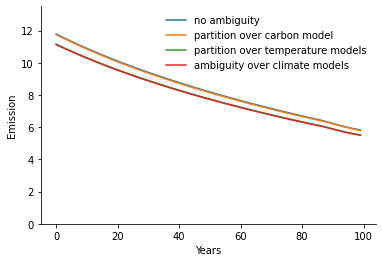

In [70]:
plt.plot(et_neutral, label="no ambiguity")
plt.plot(et_carb, label="partition over carbon model")
plt.plot(et_temp, label="partition over temperature models")
plt.plot(et_avg, label = "ambiguity over climate models")
plt.legend(frameon=False, loc='upper right')
plt.xlabel("Years")
plt.ylabel('Emission')
plt.ylim(0,13.5)
# plt.savefig("../figures/ems_partition.pdf")

In [71]:
ξₐ = 1/10_000
γ3 = np.average(γ3_list, weights=[0.5,0.5,0])
args = (δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξₐ)
ϕ_avg, ems_avg, π_avg = solve_smooth(y_grid, args, tol=1e-6)
args = (δ, η, θtemp_list, σy, γ1, γ2, γ3, ȳ, ξₐ)
ϕ_temp, ems_temp, π_temp = solve_smooth(y_grid, args, tol=1e-6)
args = (δ, η, θcarb_list, σy, γ1, γ2, γ3, ȳ, ξₐ)
ϕ_carb, ems_carb, π_carb = solve_smooth(y_grid, args, tol=1e-6)
yt_avg, et_avg, πt_avg = simulate_traj(y_grid, ems_avg, π_avg, θ_list)
yt_temp, et_temp, πt_temp = simulate_traj(y_grid, ems_temp, π_temp, θtemp_list)
yt_carb, et_carb, πt_carb = simulate_traj(y_grid, ems_carb, π_carb, θcarb_list)

episode: 1,	 ode error: 0.0012172938100895325,	 ft error: 0.0011973882892920133
episode: 2,	 ode error: 0.0012554166231305405,	 ft error: 0.00122626743683655
episode: 3,	 ode error: 0.001227622592030187,	 ft error: 0.0011945800795376102
episode: 4,	 ode error: 0.0011916357642243864,	 ft error: 0.0011587400026746818
episode: 5,	 ode error: 0.0011583504275067644,	 ft error: 0.0011268632828695998
episode: 6,	 ode error: 0.001128857851420804,	 ft error: 0.0011002899828854522
episode: 7,	 ode error: 0.0011028007345271133,	 ft error: 0.0010768044067491834
episode: 8,	 ode error: 0.001079430870452548,	 ft error: 0.001055648408436275
episode: 9,	 ode error: 0.0010581946324702055,	 ft error: 0.001036310055602019
episode: 10,	 ode error: 0.0010387031243510802,	 ft error: 0.0010184505223518306
episode: 11,	 ode error: 0.001020675217176833,	 ft error: 0.001001834626402244
episode: 12,	 ode error: 0.0010038985526075834,	 ft error: 0.0009862885879703804
episode: 13,	 ode error: 0.000988208375180375,

episode: 138,	 ode error: 0.00041711358822947944,	 ft error: 0.00041534937190927196
episode: 139,	 ode error: 0.0004149606651691198,	 ft error: 0.00041321176774780416
episode: 140,	 ode error: 0.00041281927398705617,	 ft error: 0.0004110855424940829
episode: 141,	 ode error: 0.0004106892735378687,	 ft error: 0.00040897055878607685
episode: 142,	 ode error: 0.0004085705276326479,	 ft error: 0.0004068666840486892
episode: 143,	 ode error: 0.00040646290489884467,	 ft error: 0.0004047737903624278
episode: 144,	 ode error: 0.0004043662786408367,	 ft error: 0.0004026917543328036
episode: 145,	 ode error: 0.0004022805267013173,	 ft error: 0.0004006204569600066
episode: 146,	 ode error: 0.0004002055313236993,	 ft error: 0.0003985597835094145
episode: 147,	 ode error: 0.0003981411790155926,	 ft error: 0.0003965096233829226
episode: 148,	 ode error: 0.00039608736041356926,	 ft error: 0.0003944698699912449
episode: 149,	 ode error: 0.00039404397014926426,	 ft error: 0.0003924404206274874
episode:

episode: 312,	 ode error: 0.00016724936127904928,	 ft error: 0.00016703953789003653
episode: 313,	 ode error: 0.00016637543713878152,	 ft error: 0.00016616837750710786
episode: 314,	 ode error: 0.00016550630360264806,	 ft error: 0.0001653019800608215
episode: 315,	 ode error: 0.0001646419347578566,	 ft error: 0.00016444031998107586
episode: 316,	 ode error: 0.00016378230478532286,	 ft error: 0.00016358337178552323
episode: 317,	 ode error: 0.00016292738796056948,	 ft error: 0.00016273111008148952
episode: 318,	 ode error: 0.00016207715865449053,	 ft error: 0.00016188350956532668
episode: 319,	 ode error: 0.00016123159133413548,	 ft error: 0.00016104054502514195
episode: 320,	 ode error: 0.00016039066056342866,	 ft error: 0.00016020219133991895
episode: 321,	 ode error: 0.00015955434100390048,	 ft error: 0.00015936842348162247
episode: 322,	 ode error: 0.00015872260741536174,	 ft error: 0.00015853921651508285
episode: 323,	 ode error: 0.00015789543465650623,	 ft error: 0.000157714545599

episode: 480,	 ode error: 7.08016006430983e-05,	 ft error: 7.082371205074471e-05
episode: 481,	 ode error: 7.04481476981421e-05,	 ft error: 7.04707793503188e-05
episode: 482,	 ode error: 7.009653367420299e-05,	 ft error: 7.011967890474999e-05
episode: 483,	 ode error: 6.974674829986237e-05,	 ft error: 6.977040047290162e-05
episode: 484,	 ode error: 6.939878136702385e-05,	 ft error: 6.942293387689666e-05
episode: 485,	 ode error: 6.905262273052253e-05,	 ft error: 6.907726900160875e-05
episode: 486,	 ode error: 6.870826230766323e-05,	 ft error: 6.873339579357522e-05
episode: 487,	 ode error: 6.836569007778552e-05,	 ft error: 6.839130426069633e-05
episode: 488,	 ode error: 6.802489608186395e-05,	 ft error: 6.805098447262847e-05
episode: 489,	 ode error: 6.768587042205382e-05,	 ft error: 6.771242655935021e-05
episode: 490,	 ode error: 6.734860326129395e-05,	 ft error: 6.737562071111591e-05
episode: 491,	 ode error: 6.701308482286736e-05,	 ft error: 6.704055717838646e-05
episode: 492,	 ode 

episode: 648,	 ode error: 3.0891266276908413e-05,	 ft error: 3.091672216866866e-05
episode: 649,	 ode error: 3.074063077990348e-05,	 ft error: 3.0765566430372246e-05
episode: 650,	 ode error: 3.059074088021215e-05,	 ft error: 3.0615148193501494e-05
episode: 651,	 ode error: 3.0441592737274386e-05,	 ft error: 3.0465463555460575e-05
episode: 652,	 ode error: 3.0293182532186878e-05,	 ft error: 3.0316508635488036e-05
episode: 653,	 ode error: 3.014550646758497e-05,	 ft error: 3.0168279571742472e-05
episode: 654,	 ode error: 2.9998560767489132e-05,	 ft error: 3.002077252456381e-05
episode: 655,	 ode error: 2.9852341677211397e-05,	 ft error: 2.9873983673373943e-05
episode: 656,	 ode error: 2.9706845463213548e-05,	 ft error: 2.9727909217185565e-05
episode: 657,	 ode error: 2.956206841296888e-05,	 ft error: 2.958254537598996e-05
episode: 658,	 ode error: 2.9418006834868197e-05,	 ft error: 2.9437888387195042e-05
episode: 659,	 ode error: 2.9274657058082887e-05,	 ft error: 2.9293934510690733e-05

episode: 811,	 ode error: 1.3978750108095423e-05,	 ft error: 1.3687024814889223e-05
episode: 812,	 ode error: 1.3911417673946342e-05,	 ft error: 1.3613980882921466e-05
episode: 813,	 ode error: 1.3844425037996063e-05,	 ft error: 1.3541140983577837e-05
episode: 814,	 ode error: 1.377777092040843e-05,	 ft error: 1.3468498350395949e-05
episode: 815,	 ode error: 1.3711454063803394e-05,	 ft error: 1.339604588662206e-05
episode: 816,	 ode error: 1.3645473234083928e-05,	 ft error: 1.33237761681948e-05
episode: 817,	 ode error: 1.3579827221443688e-05,	 ft error: 1.325168138256727e-05
episode: 818,	 ode error: 1.3514514841387899e-05,	 ft error: 1.3179753308815528e-05
episode: 819,	 ode error: 1.3449534935881737e-05,	 ft error: 1.3107983288078903e-05
episode: 820,	 ode error: 1.3384886374618633e-05,	 ft error: 1.303636216531956e-05
episode: 821,	 ode error: 1.3320568056423882e-05,	 ft error: 1.2964880244312194e-05
episode: 822,	 ode error: 1.325657891077664e-05,	 ft error: 1.2893527245131747e-05

episode: 982,	 ode error: 5.745532931306324e-06,	 ft error: 6.918598234618527e-06
episode: 983,	 ode error: 5.7142502590414425e-06,	 ft error: 6.886994964039328e-06
episode: 984,	 ode error: 5.683119244808614e-06,	 ft error: 6.855545352813889e-06
episode: 985,	 ode error: 5.652139181765701e-06,	 ft error: 6.8242486867912495e-06
episode: 986,	 ode error: 5.62130936643528e-06,	 ft error: 6.793104255289895e-06
episode: 987,	 ode error: 5.5964608091948575e-06,	 ft error: 6.762111351097759e-06
episode: 988,	 ode error: 5.5821262013477815e-06,	 ft error: 6.731269269986499e-06
episode: 989,	 ode error: 5.567834394618661e-06,	 ft error: 6.70057731122035e-06
episode: 990,	 ode error: 5.553585262827994e-06,	 ft error: 6.670034777139788e-06
episode: 991,	 ode error: 5.539378680168483e-06,	 ft error: 6.639640973207794e-06
episode: 992,	 ode error: 5.525214521201135e-06,	 ft error: 6.609395207824813e-06
episode: 993,	 ode error: 5.511092660856508e-06,	 ft error: 6.57929679246753e-06
episode: 994,	 

episode: 1143,	 ode error: 3.807573062821032e-06,	 ft error: 3.32314163890383e-06
episode: 1144,	 ode error: 3.7985871701519164e-06,	 ft error: 3.306975864559673e-06
episode: 1145,	 ode error: 3.7896280404599433e-06,	 ft error: 3.2908552731007274e-06
episode: 1146,	 ode error: 3.7806955934361437e-06,	 ft error: 3.274779793518978e-06
episode: 1147,	 ode error: 3.771789749052899e-06,	 ft error: 3.2587493698638115e-06
episode: 1148,	 ode error: 3.7629104275626398e-06,	 ft error: 3.2427639608488086e-06
episode: 1149,	 ode error: 3.7540575494981175e-06,	 ft error: 3.22682353957419e-06
episode: 1150,	 ode error: 3.745231035669422e-06,	 ft error: 3.2109280933417805e-06
episode: 1151,	 ode error: 3.7364308071654467e-06,	 ft error: 3.1950776230998956e-06
episode: 1152,	 ode error: 3.7276567853511216e-06,	 ft error: 3.179272143443342e-06
episode: 1153,	 ode error: 3.718908891867632e-06,	 ft error: 3.1635116818732696e-06
episode: 1154,	 ode error: 3.710187048630738e-06,	 ft error: 3.1477962788434

episode: 1322,	 ode error: 2.5597898637450076e-06,	 ft error: 1.753952481725607e-06
episode: 1323,	 ode error: 2.5545284422316943e-06,	 ft error: 1.7487100957558344e-06
episode: 1324,	 ode error: 2.5492827796009697e-06,	 ft error: 1.7434832626691175e-06
episode: 1325,	 ode error: 2.544052828981852e-06,	 ft error: 1.7382719375708122e-06
episode: 1326,	 ode error: 2.538838543639807e-06,	 ft error: 1.7330760756356645e-06
episode: 1327,	 ode error: 2.5336398769758794e-06,	 ft error: 1.7278956322234567e-06
episode: 1328,	 ode error: 2.5284567825257175e-06,	 ft error: 1.7227305626824063e-06
episode: 1329,	 ode error: 2.523289213960875e-06,	 ft error: 1.7175808225342037e-06
episode: 1330,	 ode error: 2.5181371250862614e-06,	 ft error: 1.7124463673352335e-06
episode: 1331,	 ode error: 2.5130004698428548e-06,	 ft error: 1.7073271528847411e-06
episode: 1332,	 ode error: 2.5078792023032004e-06,	 ft error: 1.702223134901019e-06
episode: 1333,	 ode error: 2.502773276675369e-06,	 ft error: 1.6971342

episode: 1503,	 ode error: 2.721803543956e-06,	 ft error: 1.020458428648933e-06
episode: 1504,	 ode error: 2.722596358747031e-06,	 ft error: 1.0174102815438402e-06
episode: 1505,	 ode error: 2.7233832542806276e-06,	 ft error: 1.0143711779685613e-06
episode: 1506,	 ode error: 2.7241642627564558e-06,	 ft error: 1.0113410913355678e-06
episode: 1507,	 ode error: 2.7249394162134487e-06,	 ft error: 1.00831999512672e-06
episode: 1508,	 ode error: 2.7257087465385886e-06,	 ft error: 1.0053078627660548e-06
episode: 1509,	 ode error: 2.726472285459697e-06,	 ft error: 1.0023046679782932e-06
episode: 1510,	 ode error: 2.7272300645499333e-06,	 ft error: 9.993103844072038e-07
episode: 1,	 ode error: 0.0012167677930559155,	 ft error: 0.0011968250691962012
episode: 2,	 ode error: 0.0012540583107567668,	 ft error: 0.0012237980099371075
episode: 3,	 ode error: 0.0012270293113718848,	 ft error: 0.0011945290461741458
episode: 4,	 ode error: 0.0011919494947444465,	 ft error: 0.0011597775977285152
episode: 5

episode: 138,	 ode error: 0.0004204029753558971,	 ft error: 0.0004185643243237216
episode: 139,	 ode error: 0.00041823752796366195,	 ft error: 0.00041641533676325026
episode: 140,	 ode error: 0.00041608368750011026,	 ft error: 0.0004142777700236189
episode: 141,	 ode error: 0.0004139413157066505,	 ft error: 0.0004121514908620588
episode: 142,	 ode error: 0.000411810279096665,	 ft error: 0.0004100363705374551
episode: 143,	 ode error: 0.00040969044881817337,	 ft error: 0.0004079322846894824
episode: 144,	 ode error: 0.0004075817005173674,	 ft error: 0.00040583911321764865
episode: 145,	 ode error: 0.00040548391420314515,	 ft error: 0.0004037567401599801
episode: 146,	 ode error: 0.0004033969741127684,	 ft error: 0.0004016850535725388
episode: 147,	 ode error: 0.0004013207685788368,	 ft error: 0.00039962394540879004
episode: 148,	 ode error: 0.000399255189897607,	 ft error: 0.0003975733114000568
episode: 149,	 ode error: 0.00039720013419890503,	 ft error: 0.00039553305093655244
episode: 

episode: 303,	 ode error: 0.00017742947226986893,	 ft error: 0.0001771566142815447
episode: 304,	 ode error: 0.00017650582249011755,	 ft error: 0.00017623650818074377
episode: 305,	 ode error: 0.00017558720461272124,	 ft error: 0.0001753213925467558
episode: 306,	 ode error: 0.00017467359196123218,	 ft error: 0.0001744112413813263
episode: 307,	 ode error: 0.00017376495794436302,	 ft error: 0.00017350602875526588
episode: 308,	 ode error: 0.00017286127605728235,	 ft error: 0.00017260572880988442
episode: 309,	 ode error: 0.00017196251988285,	 ft error: 0.00017171031575941947
episode: 310,	 ode error: 0.0001710686630928041,	 ft error: 0.00017081976389210035
episode: 311,	 ode error: 0.00017017967944892715,	 ft error: 0.0001699340475717672
episode: 312,	 ode error: 0.0001692955428041318,	 ft error: 0.0001690531412399989
episode: 313,	 ode error: 0.00016841622710356057,	 ft error: 0.00016817701941710766
episode: 314,	 ode error: 0.00016754170638558046,	 ft error: 0.00016730565670373493
ep

episode: 471,	 ode error: 7.536806905739839e-05,	 ft error: 7.537860301410719e-05
episode: 472,	 ode error: 7.499384754897976e-05,	 ft error: 7.500502064372121e-05
episode: 473,	 ode error: 7.462157034879161e-05,	 ft error: 7.463337499432714e-05
episode: 474,	 ode error: 7.425122650315185e-05,	 ft error: 7.426365514887068e-05
episode: 475,	 ode error: 7.388280512668011e-05,	 ft error: 7.389585025917764e-05
episode: 476,	 ode error: 7.351629540186533e-05,	 ft error: 7.352994954336334e-05
episode: 477,	 ode error: 7.315168657872804e-05,	 ft error: 7.316594228719739e-05
episode: 478,	 ode error: 7.278896797438983e-05,	 ft error: 7.280381784301645e-05
episode: 479,	 ode error: 7.242812897269605e-05,	 ft error: 7.244356562877605e-05
episode: 480,	 ode error: 7.206915902383318e-05,	 ft error: 7.208517512906817e-05
episode: 481,	 ode error: 7.171204764394427e-05,	 ft error: 7.172863589317846e-05
episode: 482,	 ode error: 7.135678441470969e-05,	 ft error: 7.137393753603449e-05
episode: 483,	 o

episode: 638,	 ode error: 3.32246994021177e-05,	 ft error: 3.3250470115852214e-05
episode: 639,	 ode error: 3.306394669168333e-05,	 ft error: 3.308924072640644e-05
episode: 640,	 ode error: 3.2903986909131166e-05,	 ft error: 3.292879586458871e-05
episode: 641,	 ode error: 3.2744815979998654e-05,	 ft error: 3.2769131391348814e-05
episode: 642,	 ode error: 3.2586429852520145e-05,	 ft error: 3.261024318697292e-05
episode: 643,	 ode error: 3.2428824497498414e-05,	 ft error: 3.245212715469181e-05
episode: 644,	 ode error: 3.227199590815407e-05,	 ft error: 3.229477921871486e-05
episode: 645,	 ode error: 3.211594010004391e-05,	 ft error: 3.213819532210209e-05
episode: 646,	 ode error: 3.196065311088269e-05,	 ft error: 3.198237143145951e-05
episode: 647,	 ode error: 3.1806131000452565e-05,	 ft error: 3.1827303533076466e-05
episode: 648,	 ode error: 3.165236985046185e-05,	 ft error: 3.167298763278685e-05
episode: 649,	 ode error: 3.149936576443712e-05,	 ft error: 3.151941975777321e-05
episode: 

episode: 806,	 ode error: 1.4794138179839039e-05,	 ft error: 1.4446606355518015e-05
episode: 807,	 ode error: 1.4723849251741753e-05,	 ft error: 1.4368522964977593e-05
episode: 808,	 ode error: 1.4653918131215258e-05,	 ft error: 1.4290553118518717e-05
episode: 809,	 ode error: 1.4584343774144996e-05,	 ft error: 1.4212682197857948e-05
episode: 810,	 ode error: 1.4515125182116401e-05,	 ft error: 1.413489447046427e-05
episode: 811,	 ode error: 1.4446261405770826e-05,	 ft error: 1.4057172950758073e-05
episode: 812,	 ode error: 1.4377751548549944e-05,	 ft error: 1.3979499249120824e-05
episode: 813,	 ode error: 1.4309594770897248e-05,	 ft error: 1.3901853397219981e-05
episode: 814,	 ode error: 1.4241790295110835e-05,	 ft error: 1.382421362099151e-05
episode: 815,	 ode error: 1.4174337410850823e-05,	 ft error: 1.374655610057729e-05
episode: 816,	 ode error: 1.4107235481242869e-05,	 ft error: 1.3668854729892432e-05
episode: 817,	 ode error: 1.4040483950166936e-05,	 ft error: 1.3591080715603481

episode: 973,	 ode error: 6.495986230245173e-06,	 ft error: 7.656148927152422e-06
episode: 974,	 ode error: 6.461702668469232e-06,	 ft error: 7.621513889074135e-06
episode: 975,	 ode error: 6.427584712163166e-06,	 ft error: 7.587046236291288e-06
episode: 976,	 ode error: 6.393631655320217e-06,	 ft error: 7.5527452733416735e-06
episode: 977,	 ode error: 6.359842793943302e-06,	 ft error: 7.518610305988957e-06
episode: 978,	 ode error: 6.3262174261412936e-06,	 ft error: 7.484640641199544e-06
episode: 979,	 ode error: 6.292754852272784e-06,	 ft error: 7.45083558735075e-06
episode: 980,	 ode error: 6.259454374963106e-06,	 ft error: 7.41719445416141e-06
episode: 981,	 ode error: 6.226315299241269e-06,	 ft error: 7.383716553316377e-06
episode: 982,	 ode error: 6.193336932603169e-06,	 ft error: 7.350401198027065e-06
episode: 983,	 ode error: 6.160518585094201e-06,	 ft error: 7.317247703586549e-06
episode: 984,	 ode error: 6.1278595693673756e-06,	 ft error: 7.284255387230802e-06
episode: 985,	 

episode: 1149,	 ode error: 3.5087816225120422e-06,	 ft error: 3.5674273380498223e-06
episode: 1150,	 ode error: 3.500739506731923e-06,	 ft error: 3.5522059479986545e-06
episode: 1151,	 ode error: 3.4927214699473287e-06,	 ft error: 3.537029781425227e-06
episode: 1152,	 ode error: 3.484727438376079e-06,	 ft error: 3.521898155357343e-06
episode: 1153,	 ode error: 3.476757338450936e-06,	 ft error: 3.506810397971294e-06
episode: 1154,	 ode error: 3.468811096822696e-06,	 ft error: 3.4917658492163626e-06
episode: 1155,	 ode error: 3.460888640358724e-06,	 ft error: 3.476763860976728e-06
episode: 1156,	 ode error: 3.452989896145014e-06,	 ft error: 3.461803797256506e-06
episode: 1157,	 ode error: 3.4451147914866783e-06,	 ft error: 3.4468850347348554e-06
episode: 1158,	 ode error: 3.4372637740979833e-06,	 ft error: 3.4320069629510215e-06
episode: 1159,	 ode error: 3.429436514222335e-06,	 ft error: 3.4171689843968496e-06
episode: 1160,	 ode error: 3.4216326359927797e-06,	 ft error: 3.4023705151875

episode: 1325,	 ode error: 2.406779589642777e-06,	 ft error: 1.5833924815050748e-06
episode: 1326,	 ode error: 2.402031030539556e-06,	 ft error: 1.5786628426370242e-06
episode: 1327,	 ode error: 2.397296709996861e-06,	 ft error: 1.57394710519528e-06
episode: 1328,	 ode error: 2.3925765859720964e-06,	 ft error: 1.5692452312240923e-06
episode: 1329,	 ode error: 2.3878706165371584e-06,	 ft error: 1.5645571830568325e-06
episode: 1330,	 ode error: 2.383178759879411e-06,	 ft error: 1.559882922969047e-06
episode: 1331,	 ode error: 2.378500974300926e-06,	 ft error: 1.555222413363496e-06
episode: 1332,	 ode error: 2.373837218217509e-06,	 ft error: 1.5505756168048466e-06
episode: 1333,	 ode error: 2.3691874501594024e-06,	 ft error: 1.5459424957999421e-06
episode: 1334,	 ode error: 2.364551628770582e-06,	 ft error: 1.5413230130175335e-06
episode: 1335,	 ode error: 2.359929712808756e-06,	 ft error: 1.5367171312073251e-06
episode: 1336,	 ode error: 2.3553216611452567e-06,	 ft error: 1.5321248131652

episode: 18,	 ode error: 0.000936247530614838,	 ft error: 0.0009236592628635253
episode: 19,	 ode error: 0.0009250225001169022,	 ft error: 0.0009129707430476145
episode: 20,	 ode error: 0.0009142703869903921,	 ft error: 0.0009021138217038857
episode: 21,	 ode error: 0.0009038860472941137,	 ft error: 0.0008923272367855183
episode: 22,	 ode error: 0.0008939309159680189,	 ft error: 0.0008829020908832722
episode: 23,	 ode error: 0.0008843585168209981,	 ft error: 0.0008737958838433112
episode: 24,	 ode error: 0.0008751318035558322,	 ft error: 0.0008649849715591651
episode: 25,	 ode error: 0.0008662210453947746,	 ft error: 0.0008564501017739359
episode: 26,	 ode error: 0.0008576015161394168,	 ft error: 0.000848173813556991
episode: 27,	 ode error: 0.0008492520110700869,	 ft error: 0.0008401400605836332
episode: 28,	 ode error: 0.0008411539583446993,	 ft error: 0.0008323341212715038
episode: 29,	 ode error: 0.0008332908640989118,	 ft error: 0.0008247425060742044
episode: 30,	 ode error: 0.000

episode: 180,	 ode error: 0.00034476881947752345,	 ft error: 0.00034344352457002053
episode: 181,	 ode error: 0.00034299313253797787,	 ft error: 0.0003416797286791516
episode: 182,	 ode error: 0.0003412260863558894,	 ft error: 0.0003399244567894172
episode: 183,	 ode error: 0.00033946764418732965,	 ft error: 0.0003381776736988834
episode: 184,	 ode error: 0.0003377177699791868,	 ft error: 0.00033643934484838917
episode: 185,	 ode error: 0.00033597642832676065,	 ft error: 0.00033470943628227207
episode: 186,	 ode error: 0.0003342435844331628,	 ft error: 0.0003329879146106672
episode: 187,	 ode error: 0.00033251920407054614,	 ft error: 0.0003312747469731703
episode: 188,	 ode error: 0.0003308032535430097,	 ft error: 0.00032956990100458294
episode: 189,	 ode error: 0.00032909569965122905,	 ft error: 0.0003278733448015131
episode: 190,	 ode error: 0.0003273965096587282,	 ft error: 0.00032618504689108097
episode: 191,	 ode error: 0.00032570565125968737,	 ft error: 0.00032450497620052643
epi

episode: 353,	 ode error: 0.0001409307827736604,	 ft error: 0.00014075096332791248
episode: 354,	 ode error: 0.00014021639630939185,	 ft error: 0.00014003920921027796
episode: 355,	 ode error: 0.00013950585304997186,	 ft error: 0.00013933126803570656
episode: 356,	 ode error: 0.00013879913144990218,	 ft error: 0.00013862711874923495
episode: 357,	 ode error: 0.00013809621007165754,	 ft error: 0.00013792674039239672
episode: 358,	 ode error: 0.00013739706758574466,	 ft error: 0.00013723011210248215
episode: 359,	 ode error: 0.0001367016827706519,	 ft error: 0.0001365372131148975
episode: 360,	 ode error: 0.00013601003451286012,	 ft error: 0.00013584802276140712
episode: 361,	 ode error: 0.00013532210180679087,	 ft error: 0.00013516252047161376
episode: 362,	 ode error: 0.00013463786375478347,	 ft error: 0.0001344806857733749
episode: 363,	 ode error: 0.00013395729956700562,	 ft error: 0.0001338024982919933
episode: 364,	 ode error: 0.00013328038856136673,	 ft error: 0.000133127937751234

episode: 529,	 ode error: 5.895786043608924e-05,	 ft error: 5.899086123366722e-05
episode: 530,	 ode error: 5.867325340400066e-05,	 ft error: 5.87066153986728e-05
episode: 531,	 ode error: 5.83900760411782e-05,	 ft error: 5.8423792376009295e-05
episode: 532,	 ode error: 5.810832056915463e-05,	 ft error: 5.814238439483255e-05
episode: 533,	 ode error: 5.782797925749832e-05,	 ft error: 5.786238373370334e-05
episode: 534,	 ode error: 5.754904442352665e-05,	 ft error: 5.75837827165628e-05
episode: 535,	 ode error: 5.7271508432043226e-05,	 ft error: 5.730657371615563e-05
episode: 536,	 ode error: 5.699536369502473e-05,	 ft error: 5.703074915067626e-05
episode: 537,	 ode error: 5.6720602671384815e-05,	 ft error: 5.675630148564241e-05
episode: 538,	 ode error: 5.644721786663971e-05,	 ft error: 5.6483223232160304e-05
episode: 539,	 ode error: 5.617520183266234e-05,	 ft error: 5.621150694683219e-05
episode: 540,	 ode error: 5.590454716736736e-05,	 ft error: 5.594114523279718e-05
episode: 541,	 

episode: 705,	 ode error: 2.543520714369215e-05,	 ft error: 2.540581580889878e-05
episode: 706,	 ode error: 2.5315259506328682e-05,	 ft error: 2.5284347072209355e-05
episode: 707,	 ode error: 2.5195890298169922e-05,	 ft error: 2.5163430425860965e-05
episode: 708,	 ode error: 2.5077096710891876e-05,	 ft error: 2.504306252535301e-05
episode: 709,	 ode error: 2.495887595250839e-05,	 ft error: 2.492324002692503e-05
episode: 710,	 ode error: 2.4841225247326814e-05,	 ft error: 2.480395958700162e-05
episode: 711,	 ode error: 2.4724141835923163e-05,	 ft error: 2.4685217858884854e-05
episode: 712,	 ode error: 2.460762297510331e-05,	 ft error: 2.4567011492638662e-05
episode: 713,	 ode error: 2.4491665937875014e-05,	 ft error: 2.4449337135690197e-05
episode: 714,	 ode error: 2.437626801338026e-05,	 ft error: 2.4332191433269295e-05
episode: 715,	 ode error: 2.426142650690643e-05,	 ft error: 2.421557102262606e-05
episode: 716,	 ode error: 2.414713873985779e-05,	 ft error: 2.4099472538026877e-05
epi

episode: 877,	 ode error: 1.1362198296902557e-05,	 ft error: 1.1377546522348125e-05
episode: 878,	 ode error: 1.1308662700496713e-05,	 ft error: 1.1324098417008396e-05
episode: 879,	 ode error: 1.1255377940101036e-05,	 ft error: 1.1270900861897378e-05
episode: 880,	 ode error: 1.1202342871065394e-05,	 ft error: 1.1217952707887984e-05
episode: 881,	 ode error: 1.1149556352929124e-05,	 ft error: 1.1165252810895384e-05
episode: 882,	 ode error: 1.1097017249516328e-05,	 ft error: 1.1112800029887867e-05
episode: 883,	 ode error: 1.10447244289954e-05,	 ft error: 1.1060593229176668e-05
episode: 884,	 ode error: 1.0992676763936808e-05,	 ft error: 1.1008631276750632e-05
episode: 885,	 ode error: 1.094087313140374e-05,	 ft error: 1.0956913045525226e-05
episode: 886,	 ode error: 1.0889312412974651e-05,	 ft error: 1.0905437412995583e-05
episode: 887,	 ode error: 1.083799349479032e-05,	 ft error: 1.0854203260982076e-05
episode: 888,	 ode error: 1.078691526763939e-05,	 ft error: 1.0803209476509257e-

episode: 1049,	 ode error: 5.0538926916266e-06,	 ft error: 5.696145285472946e-06
episode: 1050,	 ode error: 5.039414313398453e-06,	 ft error: 5.670047014197377e-06
episode: 1051,	 ode error: 5.025008221666322e-06,	 ft error: 5.644071253580833e-06
episode: 1052,	 ode error: 5.0106747392970495e-06,	 ft error: 5.618214730963393e-06
episode: 1053,	 ode error: 4.9964142085904455e-06,	 ft error: 5.592474242518963e-06
episode: 1054,	 ode error: 4.982226989191658e-06,	 ft error: 5.566846742373807e-06
episode: 1055,	 ode error: 4.9681134538492855e-06,	 ft error: 5.541329257628218e-06
episode: 1056,	 ode error: 4.9540739866099095e-06,	 ft error: 5.51591894766094e-06
episode: 1057,	 ode error: 4.940108979502387e-06,	 ft error: 5.49061306978164e-06
episode: 1058,	 ode error: 4.926218830327814e-06,	 ft error: 5.465408991697784e-06
episode: 1059,	 ode error: 4.912403940179682e-06,	 ft error: 5.4403041924629605e-06
episode: 1060,	 ode error: 4.898664711059774e-06,	 ft error: 5.415296260672757e-06
epi

episode: 1225,	 ode error: 3.5111001447742964e-06,	 ft error: 2.354049042548508e-06
episode: 1226,	 ode error: 3.5062395515957534e-06,	 ft error: 2.3410213609298403e-06
episode: 1227,	 ode error: 3.501405915665276e-06,	 ft error: 2.328044019968741e-06
episode: 1228,	 ode error: 3.4965990173526696e-06,	 ft error: 2.315116949813678e-06
episode: 1229,	 ode error: 3.4918186376177614e-06,	 ft error: 2.3022400908364236e-06
episode: 1230,	 ode error: 3.4870645579682265e-06,	 ft error: 2.289413383385619e-06
episode: 1231,	 ode error: 3.482336560669706e-06,	 ft error: 2.2766367776400065e-06
episode: 1232,	 ode error: 3.4776344286933307e-06,	 ft error: 2.2639102250041993e-06
episode: 1233,	 ode error: 3.472957945893423e-06,	 ft error: 2.2512336838217037e-06
episode: 1234,	 ode error: 3.468306897022025e-06,	 ft error: 2.2386071127367124e-06
episode: 1235,	 ode error: 3.463681067901285e-06,	 ft error: 2.2260304815419074e-06
episode: 1236,	 ode error: 3.459080245327671e-06,	 ft error: 2.21350375718

episode: 1400,	 ode error: 2.937871070471669e-06,	 ft error: 1.2796048906582591e-06
episode: 1401,	 ode error: 2.9357483648416384e-06,	 ft error: 1.2757215964974886e-06
episode: 1402,	 ode error: 2.9336359626340566e-06,	 ft error: 1.2718497173376069e-06
episode: 1403,	 ode error: 2.931533833768385e-06,	 ft error: 1.2679950108993032e-06
episode: 1404,	 ode error: 2.9294419481789387e-06,	 ft error: 1.264151505119456e-06
episode: 1405,	 ode error: 2.9273602759009713e-06,	 ft error: 1.2603191929550876e-06
episode: 1406,	 ode error: 2.9252887869732607e-06,	 ft error: 1.2564980686122218e-06
episode: 1407,	 ode error: 2.9232274515070093e-06,	 ft error: 1.2526881243655568e-06
episode: 1408,	 ode error: 2.9211762396226895e-06,	 ft error: 1.2488893526979572e-06
episode: 1409,	 ode error: 2.91913512148631e-06,	 ft error: 1.2451017454793527e-06
episode: 1410,	 ode error: 2.9171040672971104e-06,	 ft error: 1.2413252946721909e-06
episode: 1411,	 ode error: 2.9150830473036074e-06,	 ft error: 1.237559

(0.0, 13.5)

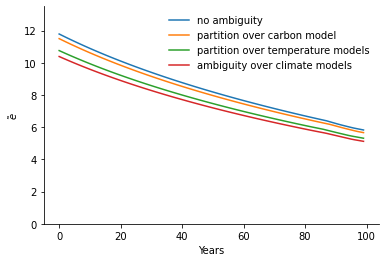

In [72]:
plt.plot(et_neutral, label="no ambiguity")
plt.plot(et_carb, label="partition over carbon model")
plt.plot(et_temp, label="partition over temperature models")
plt.plot(et_avg, label = "ambiguity over climate models")
plt.legend(frameon=False, loc='upper right')
plt.xlabel("Years")
plt.ylabel('$\\tilde e$')
plt.ylim(0,13.5)
# plt.savefig("../figures/ems_partition.pdf")